# Using the Transformer Networks

This notebook will guide you through the usage of a provided efficient implementation of Transformer Networks, to experiment with hyper-parameters and to perform ablation studies. This notebook will let you master accomplishing experiments with Transformer Networks and analyising the outcomes. Complete the code snippets where request and provide your observations. Feel free to refer the paper [Under the Hood of Transformer Networks for Trajectory Forecasting](https://arxiv.org/abs/2203.11878).

 

# Initial setup

Only if you run from Google Colab run those 2 cells to sync with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TF4AML/

/content/drive/MyDrive/TF4AML


Start with the import

In [ ]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import os
import time

from transformer import baselineUtils
from transformer import individual_TF
from transformer.batch import subsequent_mask
from transformer.noam_opt import NoamOpt

In [ ]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: Tesla T4


# Training and Testing

## Data Loading (setup the dataset for train, validation and test)

The subdatasets are 5 (ETH, Hotel, Univ, Zara1 and Zara2) we will leave one of them out for testing and train on the other 4. 

I.e. choosing ```dataset_name = 'zara1'``` the training set is composed by ETH, Hotel, Univ and Zara2 and tested on Zara1.

Moreover you can train and validate on a portion of the dataset setting percentage of the data (default is 50).

------ 

Each sequence is composed by an observed part to train the Encoder and a part we are attempting to predict with the Decoder. 

Generally the standard setup plans to use the first 8 points for the observation and the following 12 for the prediction.

------ 

Each created sequence has the shape (20, 4), where: 
- $N_{obs}+N_{pred} = 8 + 12 = 20$;
- Positions + Speeds = ( $x_i,\ y_i,\ u_i,\ v_i$) = ( $x_i,\ y_i,\ x_{i+1}-x_{i},\ y_{i+1} - y_i$ )

You can easily switch input type from position to speed setting the corresponding variable.

Speeds $u_i, v_i$ are generally more robust input and allow to avoid problems with the reference system.

------ 

Note: that $(u_0, v_0) = (0,0)$ and if speed are used the observed sequence has temporal length of $N_{obs} - 1$.

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = '15epochs0001_01_5'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 100

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_eth_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading students003_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

We compute the mean and standard deviation of positions or speeds across the full training dataset and use those to normalize each entry in the sequence.
This normalization is beneficial prior to processing with neural networks.

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size = 512 # Default is 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

## Model instantiation

We create an instance of our transformer with the chosen configuration. 

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

## Training and Validation Step

Here we create two classes that define the single iteration function for train and validation.

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

## Optimizer

Here we select the **optimizer** proposed in the original Transformer Networks paper of Vaswani et al.

It uses some initial warmup epochs, where the learning rate is increased. Then it slowly decreases according to a number of epoch and the chosen embedding size. The resulting formula is:

LR = $\frac{F}{\sqrt{D}} min( \frac{1}{\sqrt{epoch}},\ epoch \cdot W^{-\frac{3}{2}}) $

where F is a scaling factor, D is the model embedding size, W is the number of warmup epochs.

In [ ]:
# Argument for the optimizer 
factor = 1 # default is 1.
warmup = 1 # default is 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Main 


Then we can train, validate and test our transformer epoch by epoch.

-------

The **losses** used are 2:

1.   $L_2$-loss distance between predicted $(\hat{\textbf{u}}, \hat{\textbf{v}})$ and GT $(\textbf{u}, \textbf{v})$ target speeds;
2.   $L_1$-loss for the target token mask. Note these should be all zero, so the loss is simply the mean.

-------

Moreover, the **metrics** used to validate the model goodness at Validation and Test time are the following:

1.   Mean Average Displacement (MAD): $L_2$-distance between *all* the $N_pred$ GT and predicted future ***positions***;
2.   Final Average Displacement (FAD): $L_2$-distance between the *last* GT and predicted future ***positions***;

-------

Note: If you restart the training for any reason, remember to instanciate again model and optimizer in order to reset them.

-------

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 15   # Total number of epoch
ckp_save_step = 15      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss

# The following variables are added for visualization purposes as required in the next part (Visualization)
# Make 'visualization' dictionary to store metrics
steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']

visualization = {step: {metric: [] for metric in metrics} for step in steps}

print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):
        
        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # Update 'visualization' dictionary
    visualization['train']['loss'].append(train_loss/len(tr_dl))
    visualization['train']['mad'].append(mad)
    visualization['train']['fad'].append(fad)
    visualization['train']['pr_posit'].append(pr_posit)
    visualization['train']['gt_posit'].append(gt_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        
        # Update 'visualization' dictionary
        visualization['val']['loss'].append(val_loss/len(val_dl))
        visualization['val']['mad'].append(mad)
        visualization['val']['fad'].append(fad)
        visualization['val']['pr_posit'].append(pr_posit)
        visualization['val']['gt_posit'].append(gt_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # Update 'visualization' dictionary
        visualization['test']['loss'].append(test_loss/len(test_dl))
        visualization['test']['mad'].append(mad)
        visualization['test']['fad'].append(fad)
        visualization['test']['pr_posit'].append(pr)
        visualization['test']['gt_posit'].append(gt)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'visualization_dict' : visualization
        }, f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 005/015 <---  LR: 0.00295
Total Train Loss: 194.8258 - MAD:  0.2684 - FAD:  0.3388
Total Eval  Loss: 490.7316 - MAD:  1.1653 - FAD:  2.0024
Total Test  Loss: 552.9836 - MAD:  1.6834 - FAD:  2.6660 

---> Epoch 010/015 <---  LR: 0.00197
Total Train Loss: 111.8163 - MAD:  0.1360 - FAD:  0.2007
Total Eval  Loss: 325.2180 - MAD:  0.6452 - FAD:  1.4394
Total Test  Loss: 320.8530 - MAD:  0.6589 - FAD:  1.4638 

---> Epoch 015/015 <---  LR: 0.00158
Total Train Loss: 98.5057 - MAD:  0.1207 - FAD:  0.1770
Total Eval  Loss: 256.2698 - MAD:  0.4702 - FAD:  1.0155
Total Test  Loss: 247.2840 - MAD:  0.4291 - FAD:  0.9450 

Saving checkpoint... 
 
Total time: 615.2585341930389 seconds


## Load a model


Here we leave a snippet of code to quickly load a model from a saved checkpoint. You can load model at specific epoch using this code before the main train-eval-test loop.

In [ ]:
# Instanciate a new model and loading its parameters

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512 #emb_size = 512
ff_size = 1024 #ff_size = 2048
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Loading arguments
epoch = 15
dataset_name = 'zara1'

path = f'save_folder/15epochs0001_01_5/{dataset_name}/00015.pth' # defaualt was save_folder/regr/
checkpoint = torch.load(path) #, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
visualization = checkpoint['visualization_dict']

steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']

# Setup correctly optimizer and its LR as well
factor = 1.
warmup = 1

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optim._step = epoch-1

## Visualization  (***2 POINTS***)

Here you can implement some function to create qualitative plots.

We recommend you the following:

1. Loss plot for Train, Eval and Test;
2. MAD plot for Train, Eval and Test;
3. FAD plot for Train, Eval and Test;
4. Trajectory positions (observed points, GT target points and predicted target points)

In [ ]:
import matplotlib.pyplot as plt

path_save="plots/plots_gaussian"

# Create 'plots' directory
if not os.path.isdir(path_save):
    os.mkdir(f'/content/drive/MyDrive/TF4AML/{path_save}')

def plot_metrics(objects:list,metric='LOSS',sub_path='default_configuration'):

     labels=['train','val','test']
     colors=['blue','orange','green']

     plt.style.use('ggplot')

     fig=plt.figure(figsize=(32,12))
     

     plt.plot(list(objects[0]),color=colors[0],label='train')
     plt.plot(list(objects[1]),color=colors[1],label='val')
     plt.plot(list(objects[2]),color=colors[2],label='test')

     plt.title(f'{metric} for {sub_path}',fontsize=18,va='center',color='black')
     plt.xlabel('epoch')
     #plt.yscale('log')
     plt.ylabel('value')
     plt.legend()


     plt.savefig(f'/content/drive/MyDrive/TF4AML/{path_save}/{metric}_{sub_path}.png')
     
     plt.show()
  
     return

def plot_trajection(pred_obj:list,gt_obj:list,sub_path='default_configuration'):

     labels=['train','val','test']

     colors=['blue','orange','green']

     plt.style.use('ggplot')

     fig = plt.figure(figsize=(32,32))
     

     plt.suptitle(f'mean trajection position across epochs for {sub_path}',fontsize=18,color='black')

     

     pos=[221,222,223]

     for j in range(3):

       ax = fig.add_subplot(pos[j],projection='3d')

       x_pred=np.mean(list(pred_obj[j]),axis=(1,2))[:,0] #mean across samples, sequence.
       y_pred=np.mean(list(pred_obj[j]),axis=(1,2))[:,1]
       z_pred= [i for i in range(len(x_pred))]

       x_true=np.mean(list(gt_obj[j]),axis=(1,2))[:,0]
       y_true=np.mean(list(gt_obj[j]),axis=(1,2))[:,1]

       ax.scatter(x_pred,y_pred,z_pred,color='r',label='predictions')
       ax.scatter(x_true,y_true,z_pred,color='g',label='ground truth')
       ax.set_title(labels[j],color='black')
       ax.set_xlabel('x')
       ax.set_ylabel('y')
       ax.set_zlabel('epoch')
       ax.legend()

     plt.savefig(f'/content/drive/MyDrive/TF4AML/{path_save}/trajection_{sub_path}.png')

     plt.show()

     return

In [ ]:
print( [visualization[step]['loss'][-1] for step in steps ])

[98.50565849829998, 256.2697563171387, 247.28397092819213]


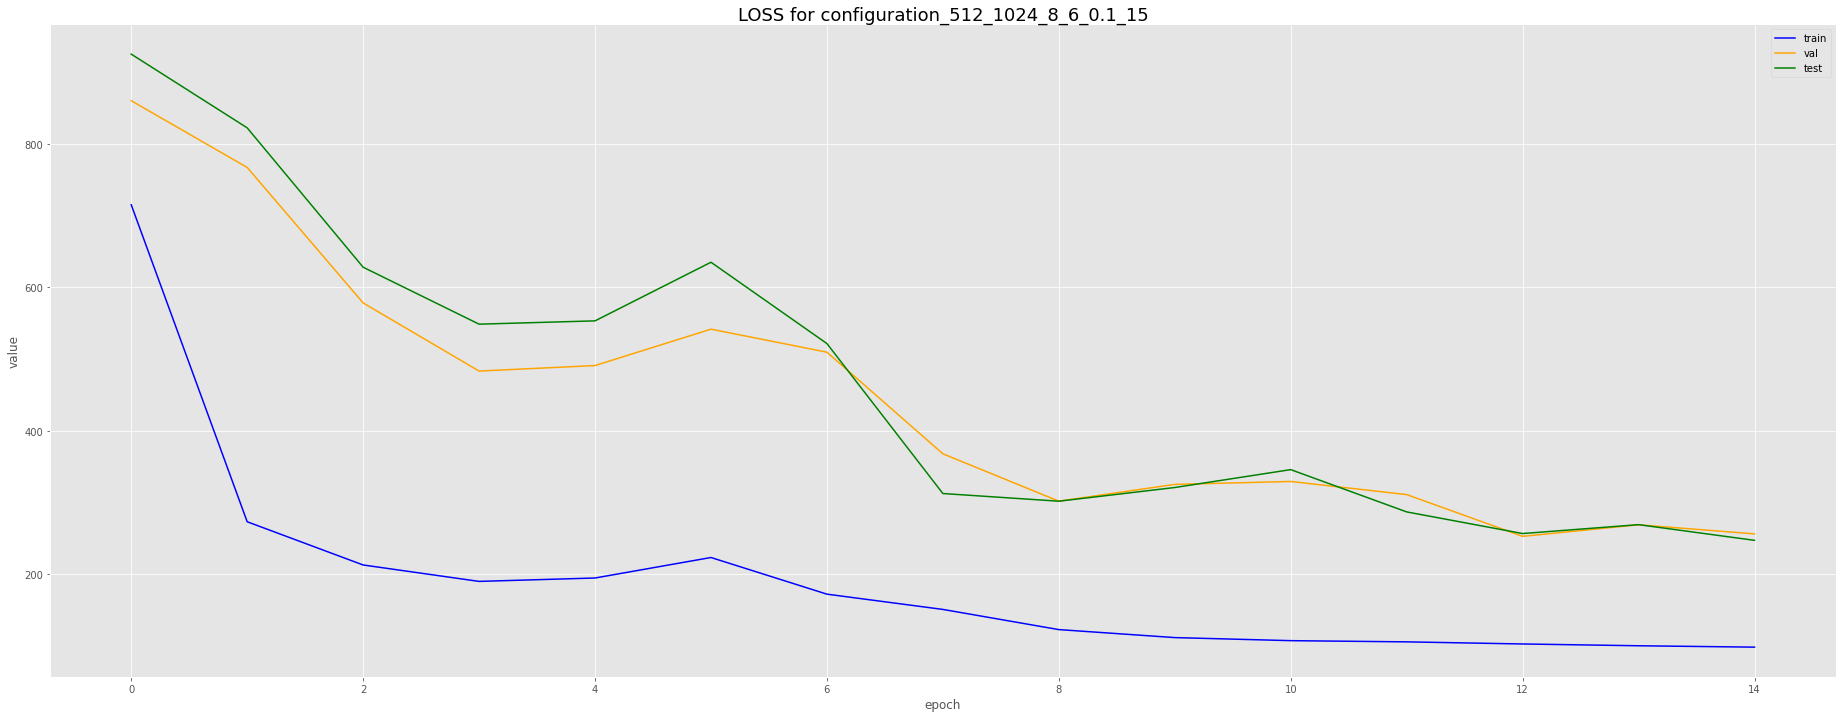

In [ ]:
loss_obj = [ visualization[step]['loss'] for step in steps ]
plot_metrics(loss_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

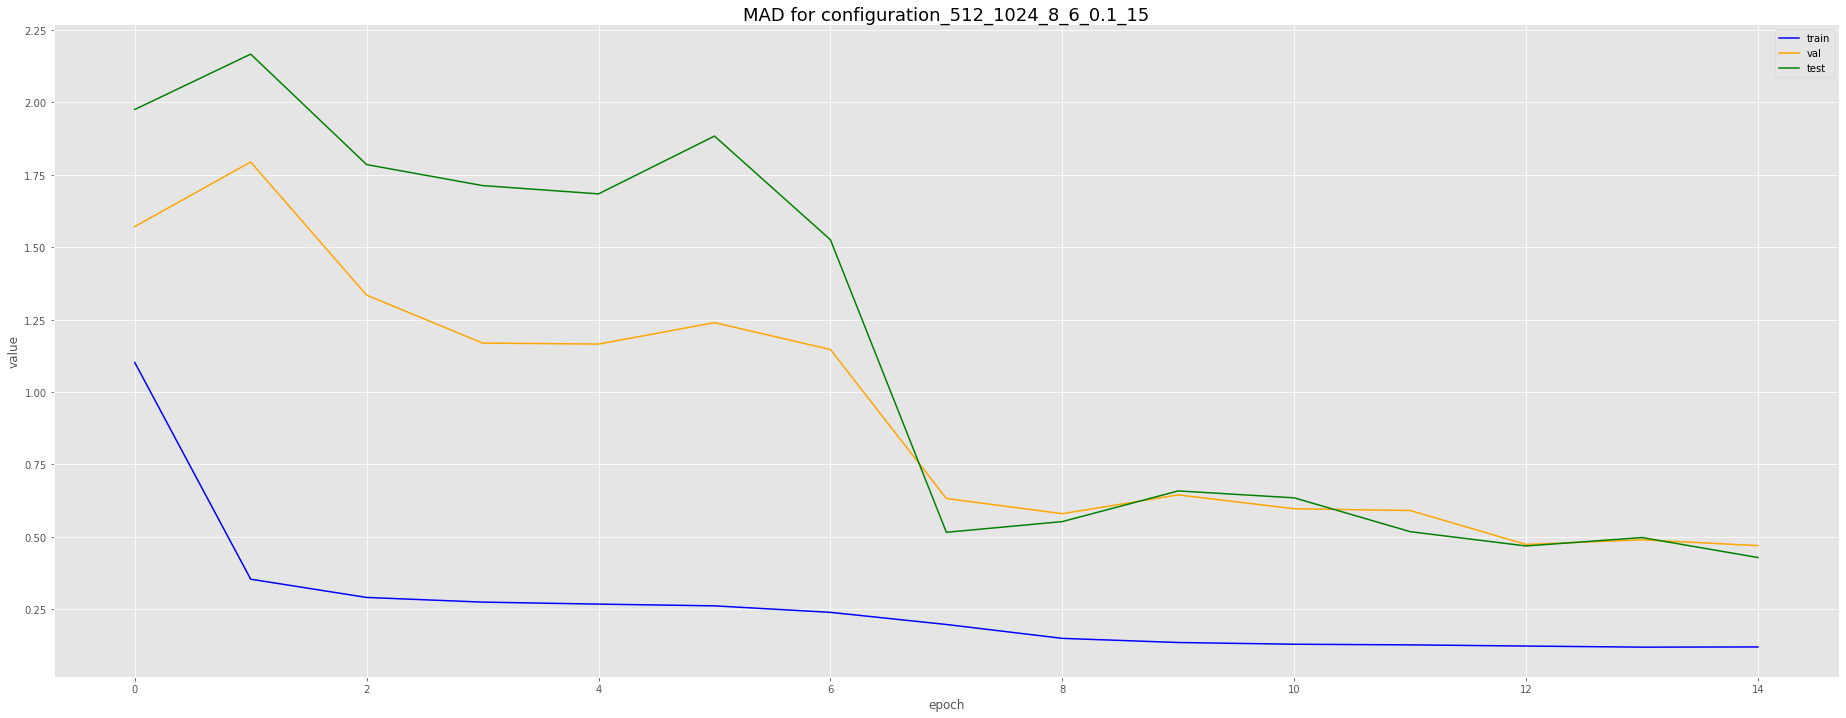

In [ ]:
mad_obj = [ visualization[step]['mad'] for step in steps ]
plot_metrics(mad_obj,metric='MAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

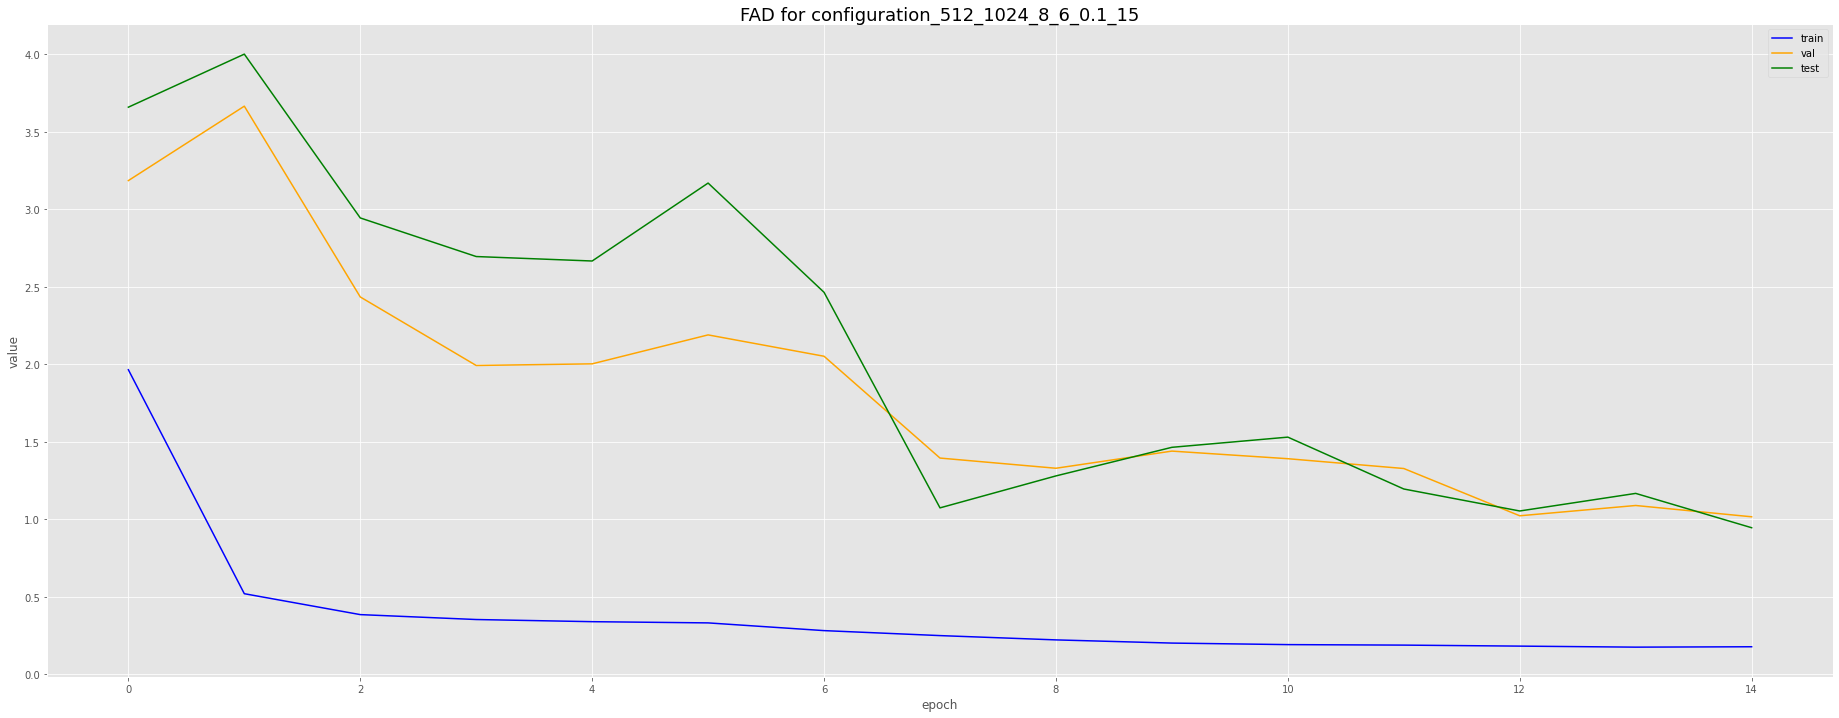

In [ ]:
fad_obj = [ visualization[step]['fad'] for step in steps ]
plot_metrics(fad_obj,metric='FAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

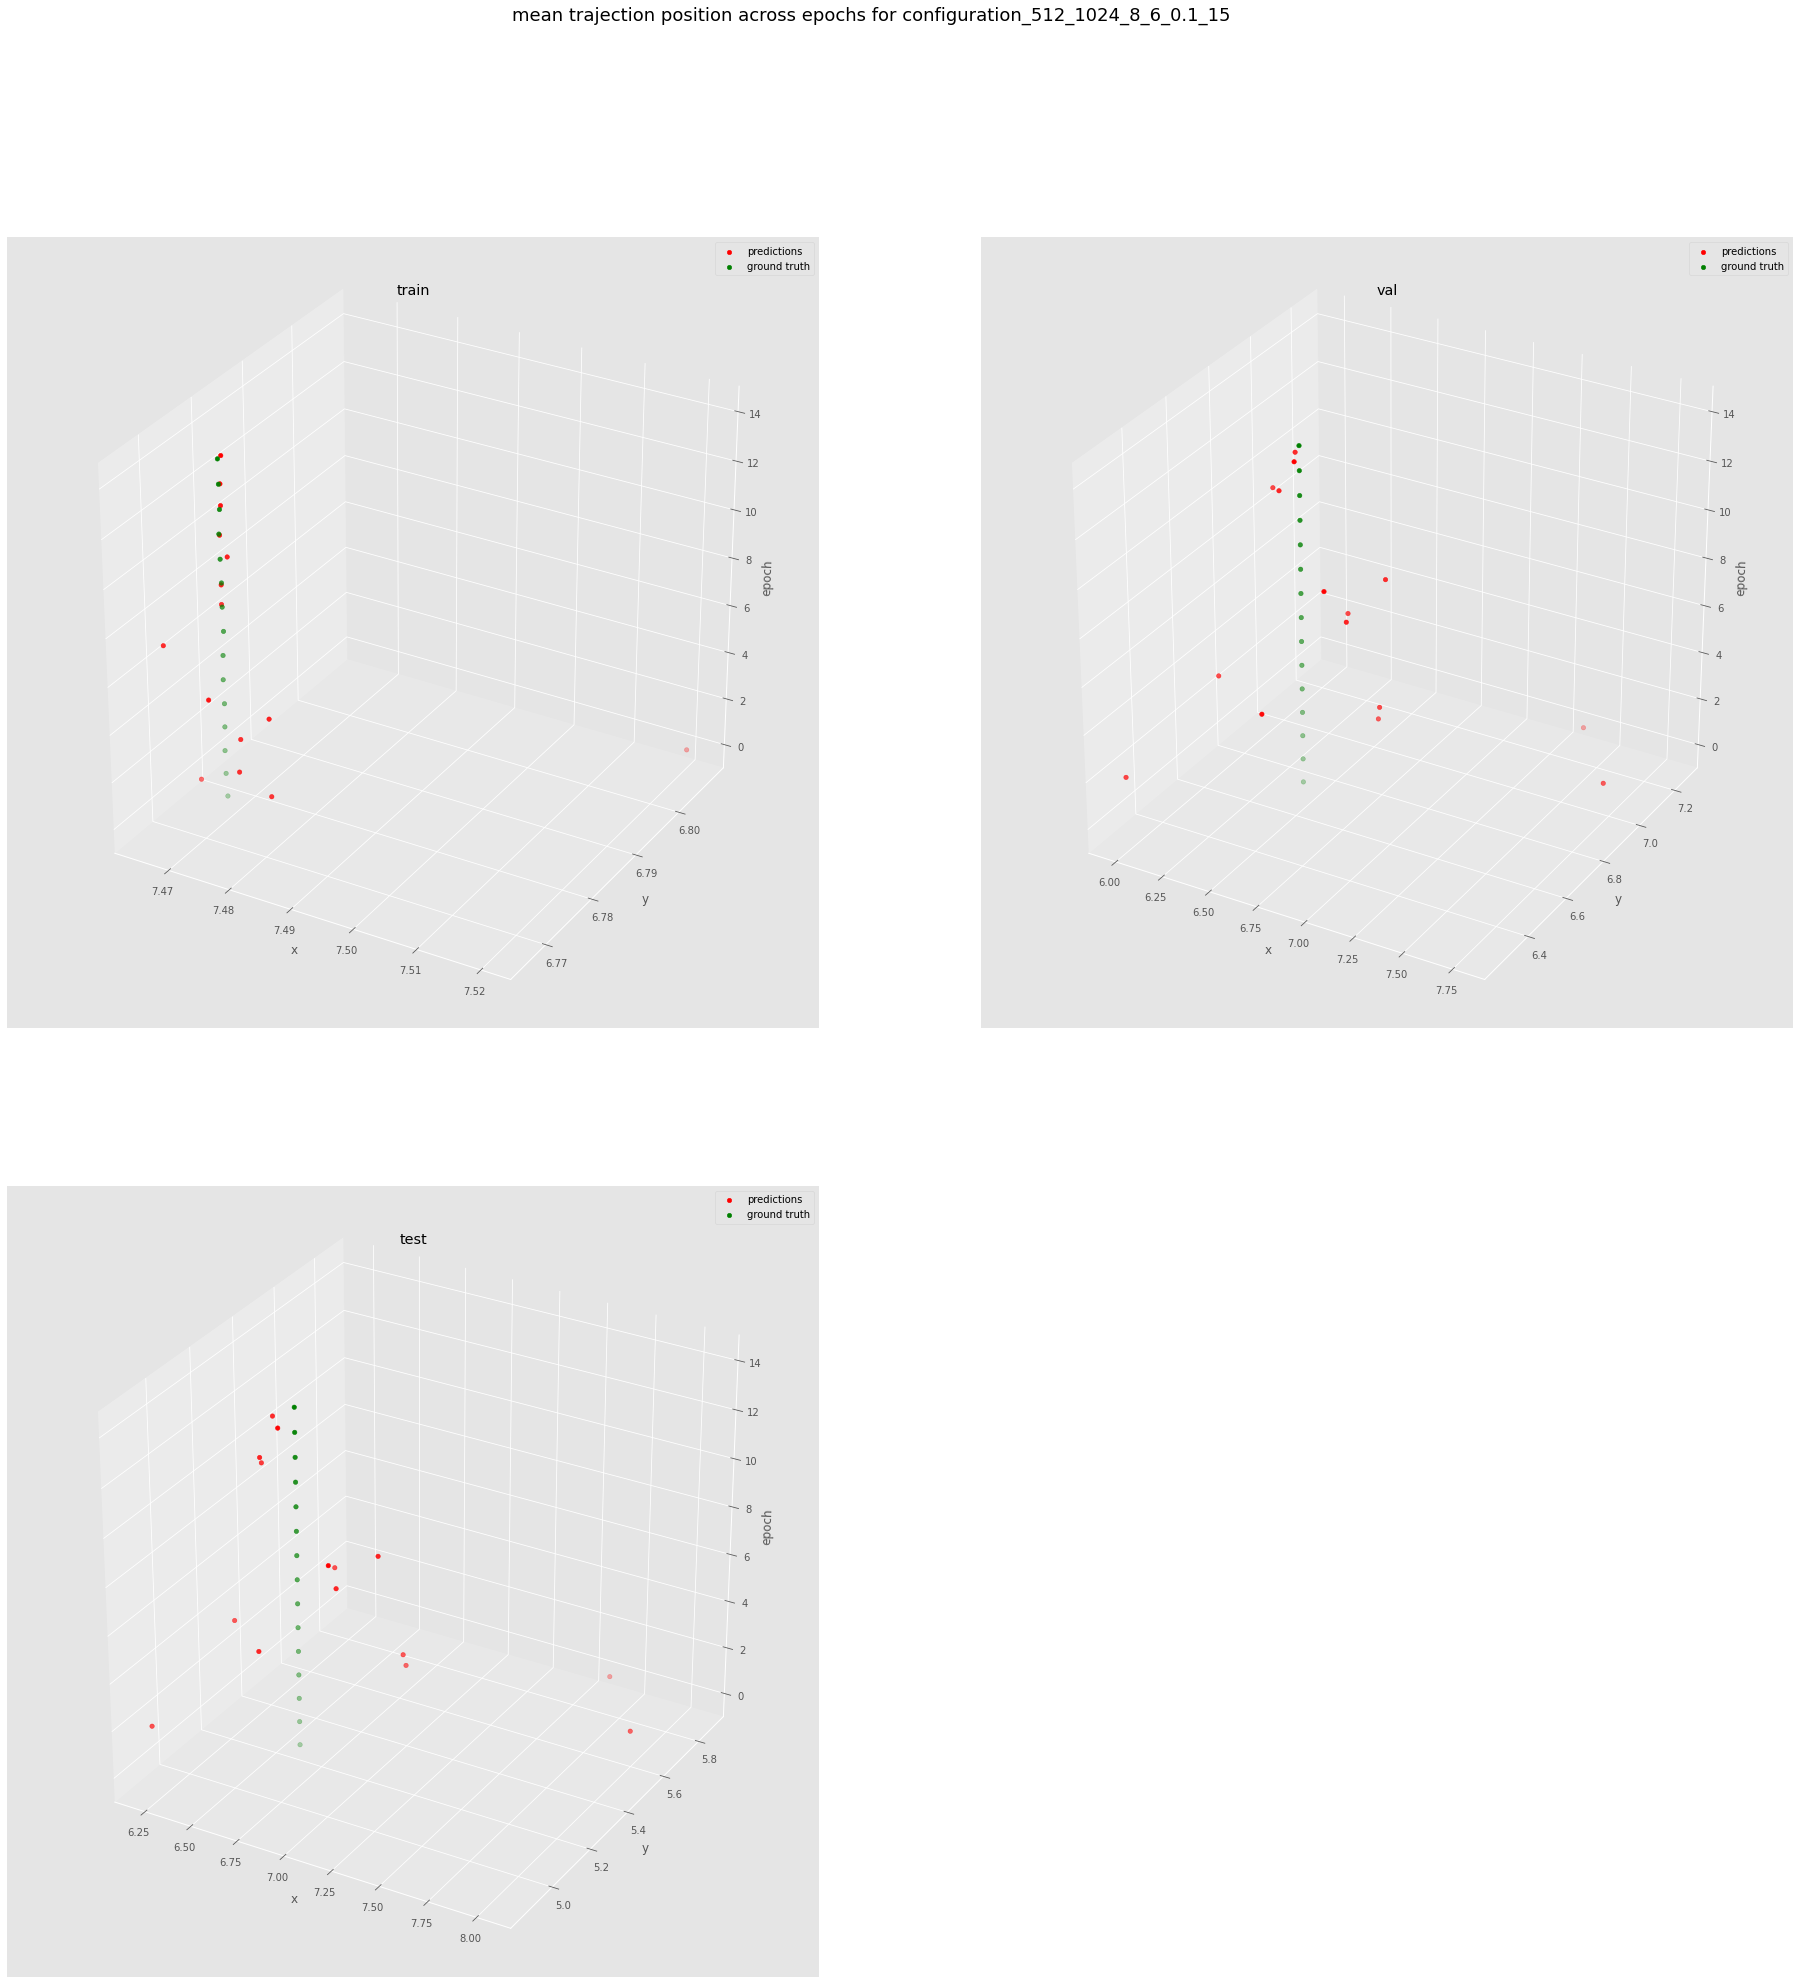

In [ ]:
pred_obj = [ visualization[step]['pr_posit'] for step in steps ]
gt_obj = [ visualization[step]['gt_posit'] for step in steps ]
plot_trajection(pred_obj,gt_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

## Report  (***4 POINTS***)

Here you can report comments and results for the experiments up to this point.

Perform experiments that improves the performances or that gives meaningfull insights.

I.e. what happens if we change model hyperparamenters? What if we change learning rate?

Please explain extensively the results and organize them clearly with tables, plots...

----

We have performed different steps in order to find the best hyperparameters for the model:

* check initial loss
* overfit a small sample
* find LR that makes loss go down
* coarse grid, train for 1-5 epochs
* refine grid,train for longer
* look at loss curves
* if the loss is still decreasing, then train for longer

The hyperparameters we decided to tune are the following:
* embedding size
* feed forward size
* number of heads
* number of layers
* dropout probability

Regarding just the learning rate, given the Noam Optimizer:
* learning rate
* factor
* warm up

In order to have more accurate results, we decided to use all the training data (100% of them) to train the model.


In the following lines we will present tables and plots relatively to a specifi phase.

In the first table we show the results of the learning rate search, keeping fixed the other hyperparameters to: emb_size=512, ff_size=1024, number of heads=8, number of layers=6, dropout probability=0.1. We have trained in this case for 15 epochs.

| lr    | factor | warmup | val loss     | val MAD    | val FAD   |
|-------|--------|--------|--------------|------------|-----------|
| **0** | **1**  | **1**  | **256.8982** | **0.4838** | **1.054** |
| 0.001 | 1      | 1      | 290.538      | 0.5187     | 1.1893    |
| 0.01  | 1      | 1      | 267.5802     | 0.5271     | 1.146     |
| 0     | 0.1    | 1      | 403.5887     | 0.9751     | 1.5883    |
| 0.001 | 0.1    | 1      | 374.0863     | 0.9209     | 1.4512    |
| 0.01  | 0.1    | 1      | 378.658      | 0.8998     | 1.399     |
| 0     | 1      | 5      | 348.2557     | 0.7095     | 1.5564    |
| 0.001 | 1      | 5      | 281.8635     | 0.5475     | 1.1758    |
| 0.01  | 1      | 5      | 298.4798     | 0.5945     | 1.3653    |
| 0     | 0.1    | 5      | 391.1568     | 0.9951     | 1.5724    |
| 0.001 | 0.1    | 5      | 401.189      | 1.0075     | 1.6306    |
| 0.01  | 0.1    | 5      | 387.2731     | 0.9997     | 1.5798    |

it is observable that the first combination gives us the best results on the validation, therefore we will use it in the coarse grid.

In the next table we show the results obtained in the coarse grid step by training for just 5 epochs using the previous optimizer parameters found in the previous step.

| heads | layers | dropout | emb_size | ff_size | val loss | val MAD | val FAD |
|-------|--------|---------|----------|---------|----------|---------|---------|
| 8     | 6      | 0.1     | 512      | 1024    | 606.3104 | 1.2772  | 2.291   |
| 8     | 6      | 0.2     | 512      | 1024    | 498.0555 | 1.0507  | 1.7039  |
| 8     | 6      | 0       | 512      | 1024    | 635.4574 | 1.4567  | 2.8616  |
| 8     | 4      | 0.1     | 512      | 1024    | 515.1579 | 1.2928  | 2.3019  |
| 8     | 2      | 0.1     | 512      | 1024    | 488.3644 | 1.2904  | 2.2662  |
| 8     | 8      | 0.1     | 512      | 1024    | 444.5741 | 1.1081  | 1.9094  |
| 1     | 6      | 0.1     | 512      | 1024    | 529.1522 | 1.2591  | 2.2287  |
| 4     | 6      | 0.1     | 512      | 1024    | 538.9811 | 1.3298  | 2.3902  |
| 16    | 6      | 0.1     | 512      | 1024    | 417.4706 | 1.0988  | 1.8281  |
| 32    | 6      | 0.1     | 512      | 1024    | 454.4422 | 1.1777  | 2.045   |
| 8     | 6      | 0.1     | 256      | 1024    | 385.2811 | 0.8771  | 1.6492  |
| 8     | 6      | 0.1     | 1024     | 1024    | 523.1433 | 1.3916  | 2.5237  |
| 8     | 6      | 0.1     | 512      | 512     | 475.7431 | 1.2453  | 2.1559  |
| 8     | 6      | 0.1     | 512      | 2048    | 574.3154 | 1.2301  | 2.1464  |

From these we will take the most promising in order to perform fine-grain step.

| heads | layers | dropout | emb_size | ff_size | val loss | val MAD | val FAD |
|-------|--------|---------|----------|---------|----------|---------|---------|
| 8     | 6      | 0.1     | 512      | 1024    | 276.9671 | 0.532   | 1.147   |
| **8** | **8**  | **0.1** | **512**  | **1024**| **263.1298** | **0.473**   | **1.0282**  |
| 8     | 2      | 0.1     | 512      | 1024    | 274.9601 | 0.5138  | 1.1363  |
| 16    | 6      | 0.1     | 512      | 1024    | 272.5204 | 0.5245  | 1.1435  |
| 32    | 6      | 0.1     | 512      | 1024    | 288.8598 | 0.5564  | 1.2193  |
| 8     | 6      | 0.1     | 256      | 1024    | 284.6334 | 0.5601  | 1.2359  |

we show the graphs of the best configuration


In [ ]:
from PIL import Image

In [ ]:
path_FAD='/content/drive/MyDrive/TF4AML/plots/plots_report1/FAD_configuration_512_1024_8_8_0.1_15.png'
path_MAD='/content/drive/MyDrive/TF4AML/plots/plots_report1/MAD_configuration_512_1024_8_8_0.1_15.png'
path_loss='/content/drive/MyDrive/TF4AML/plots/plots_report1/LOSS_configuration_512_1024_8_8_0.1_15.png'
path_trajection='/content/drive/MyDrive/TF4AML/plots/plots_report1/trajection_configuration_512_1024_8_8_0.1_15.png'

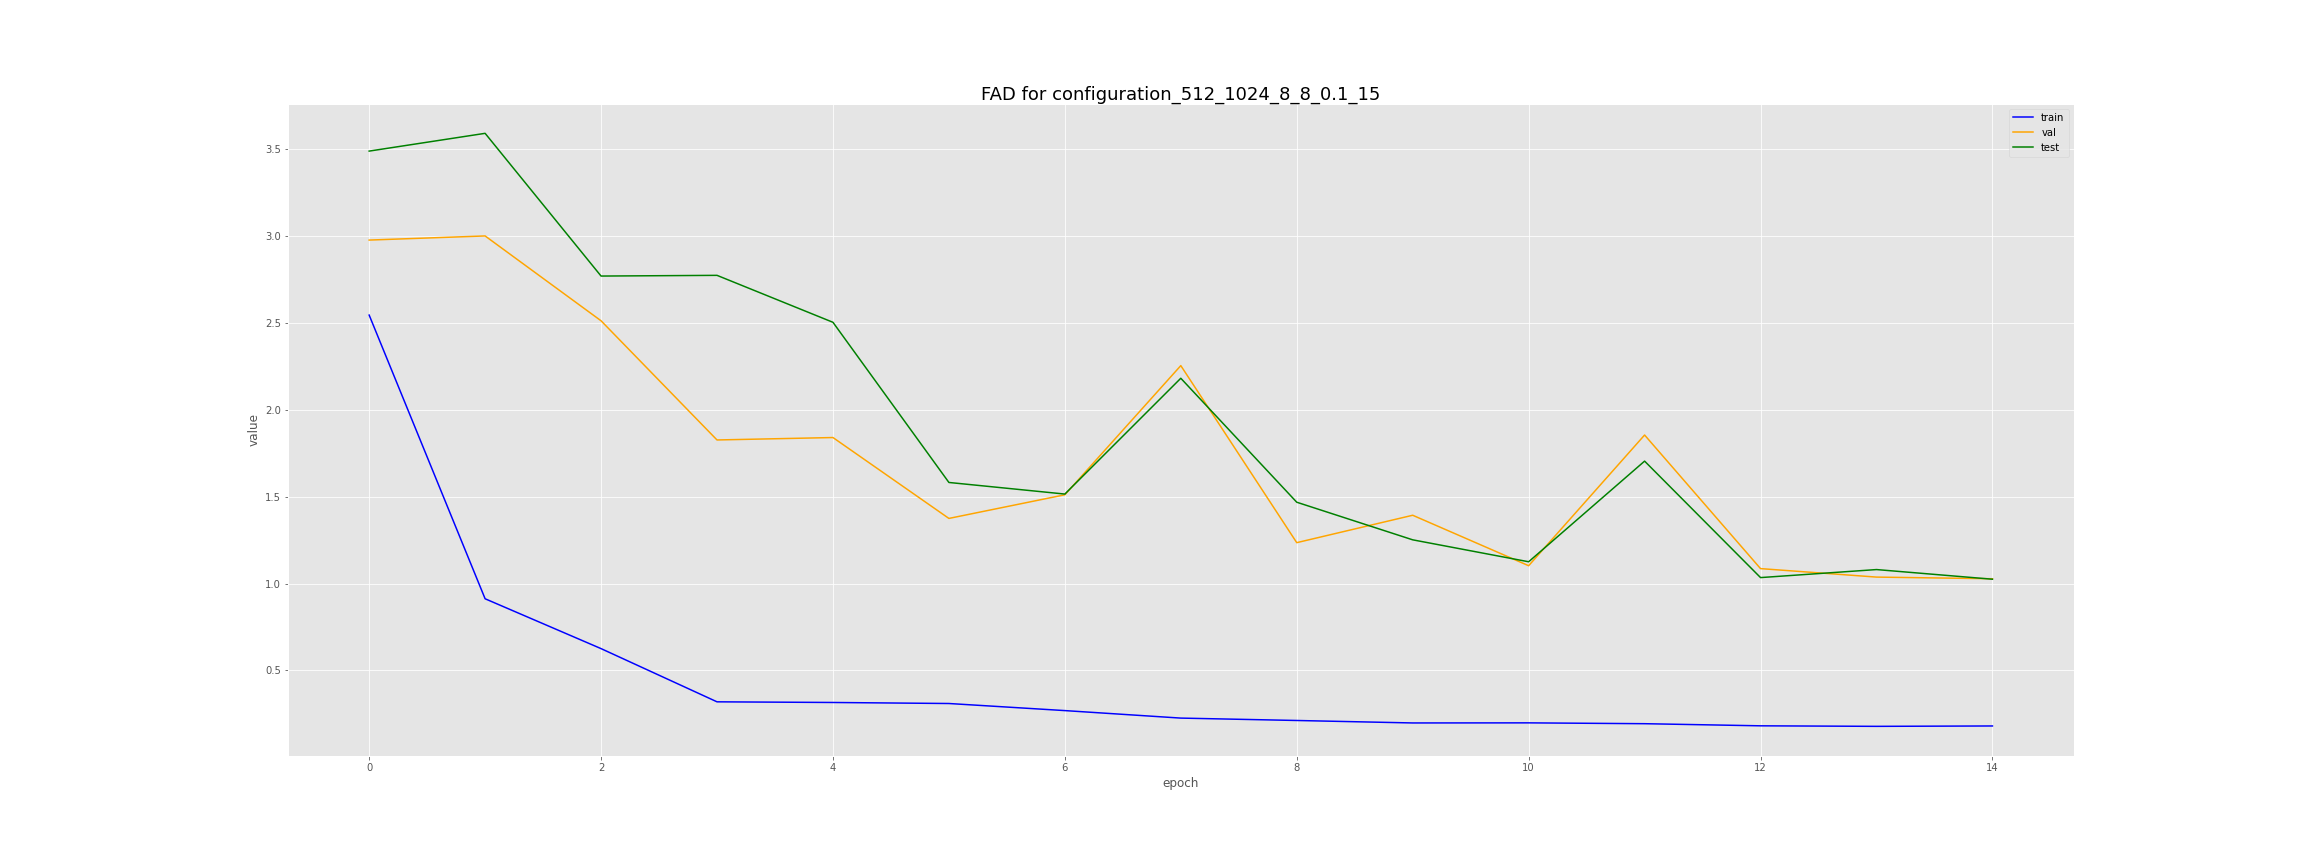

In [ ]:
img = Image.open(path_FAD)
img

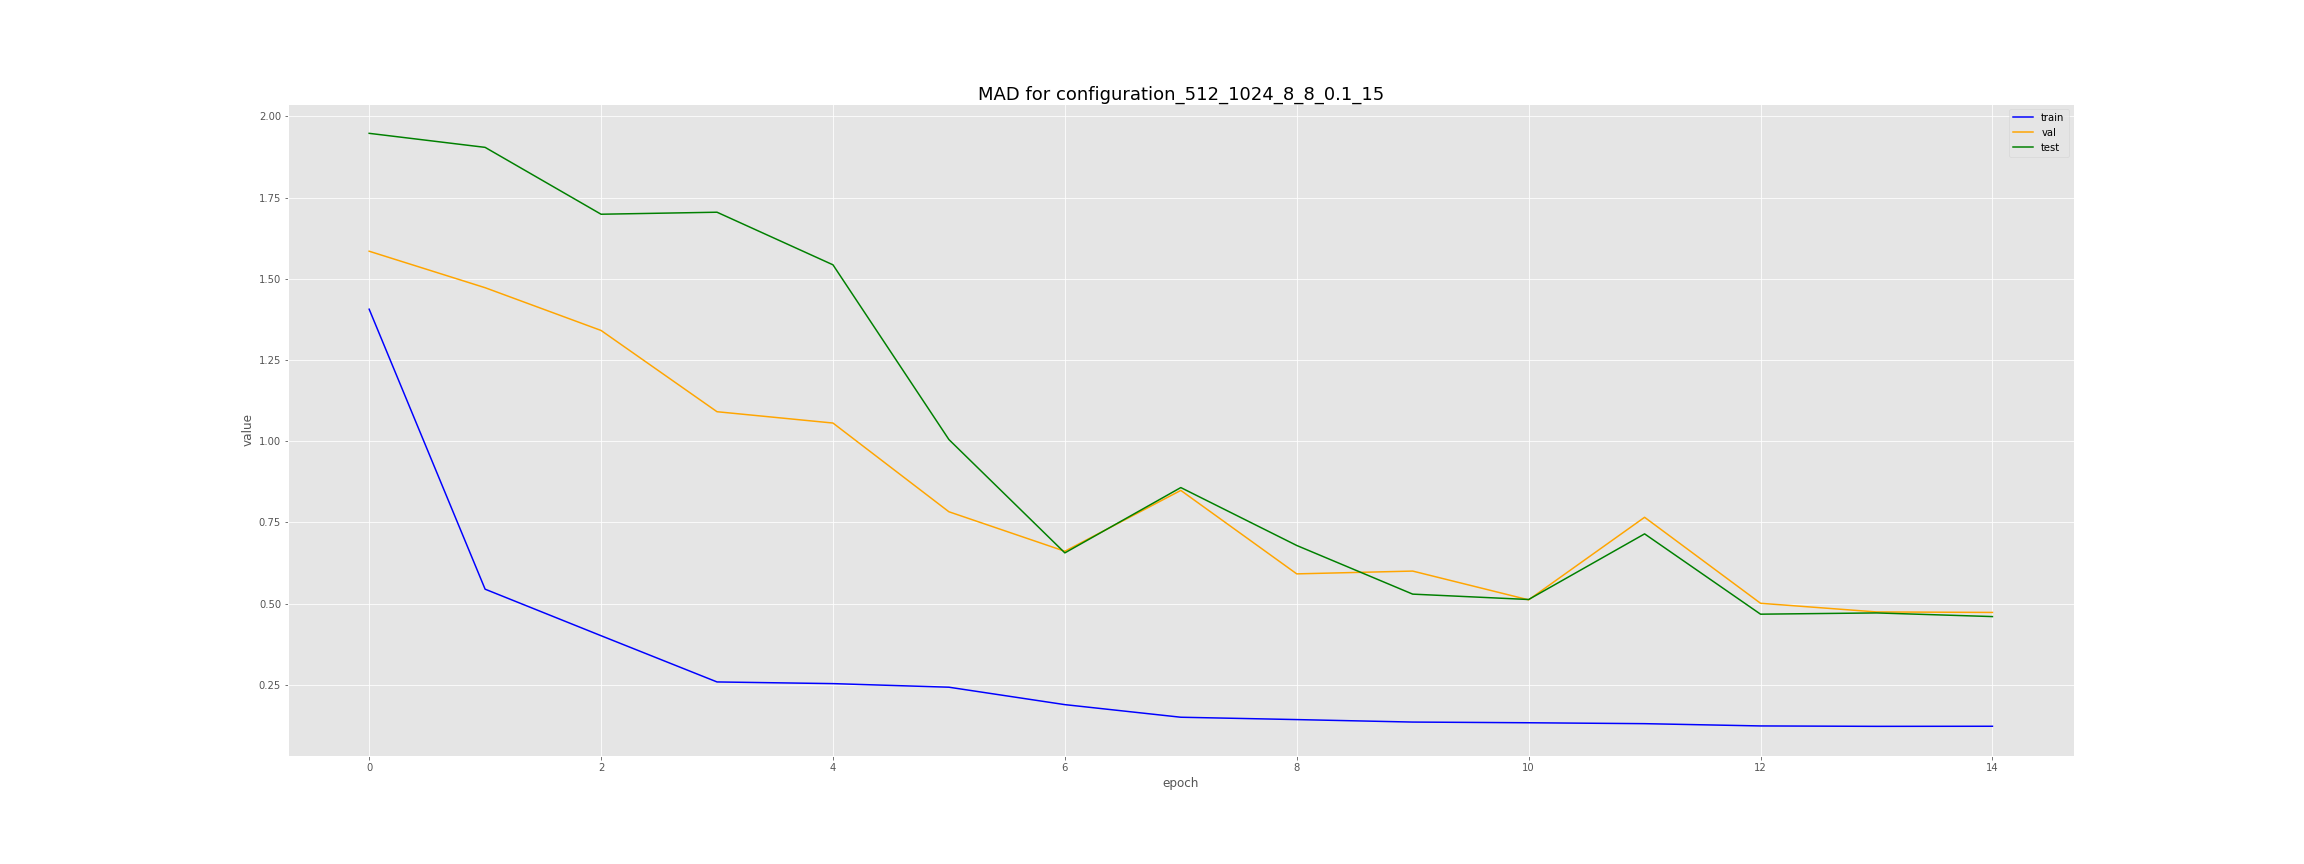

In [ ]:
img = Image.open(path_MAD)
img

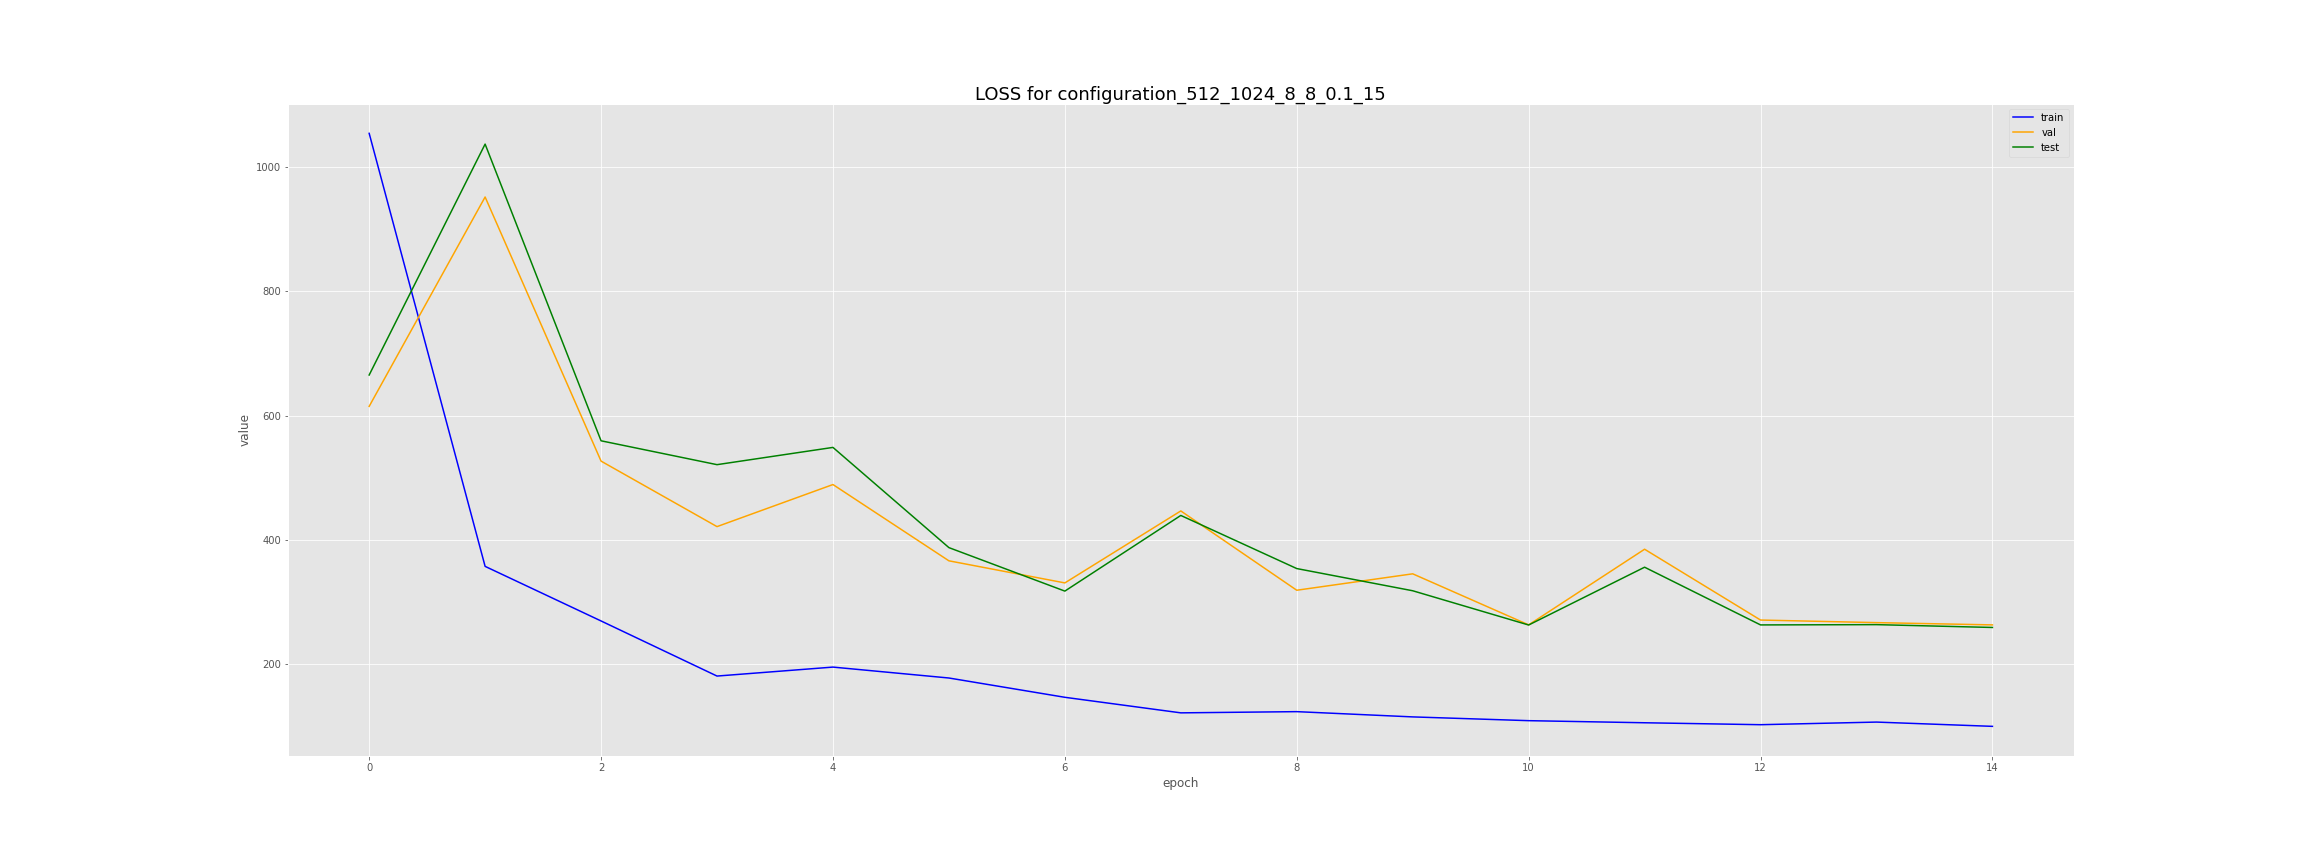

In [ ]:
img = Image.open(path_loss)
img

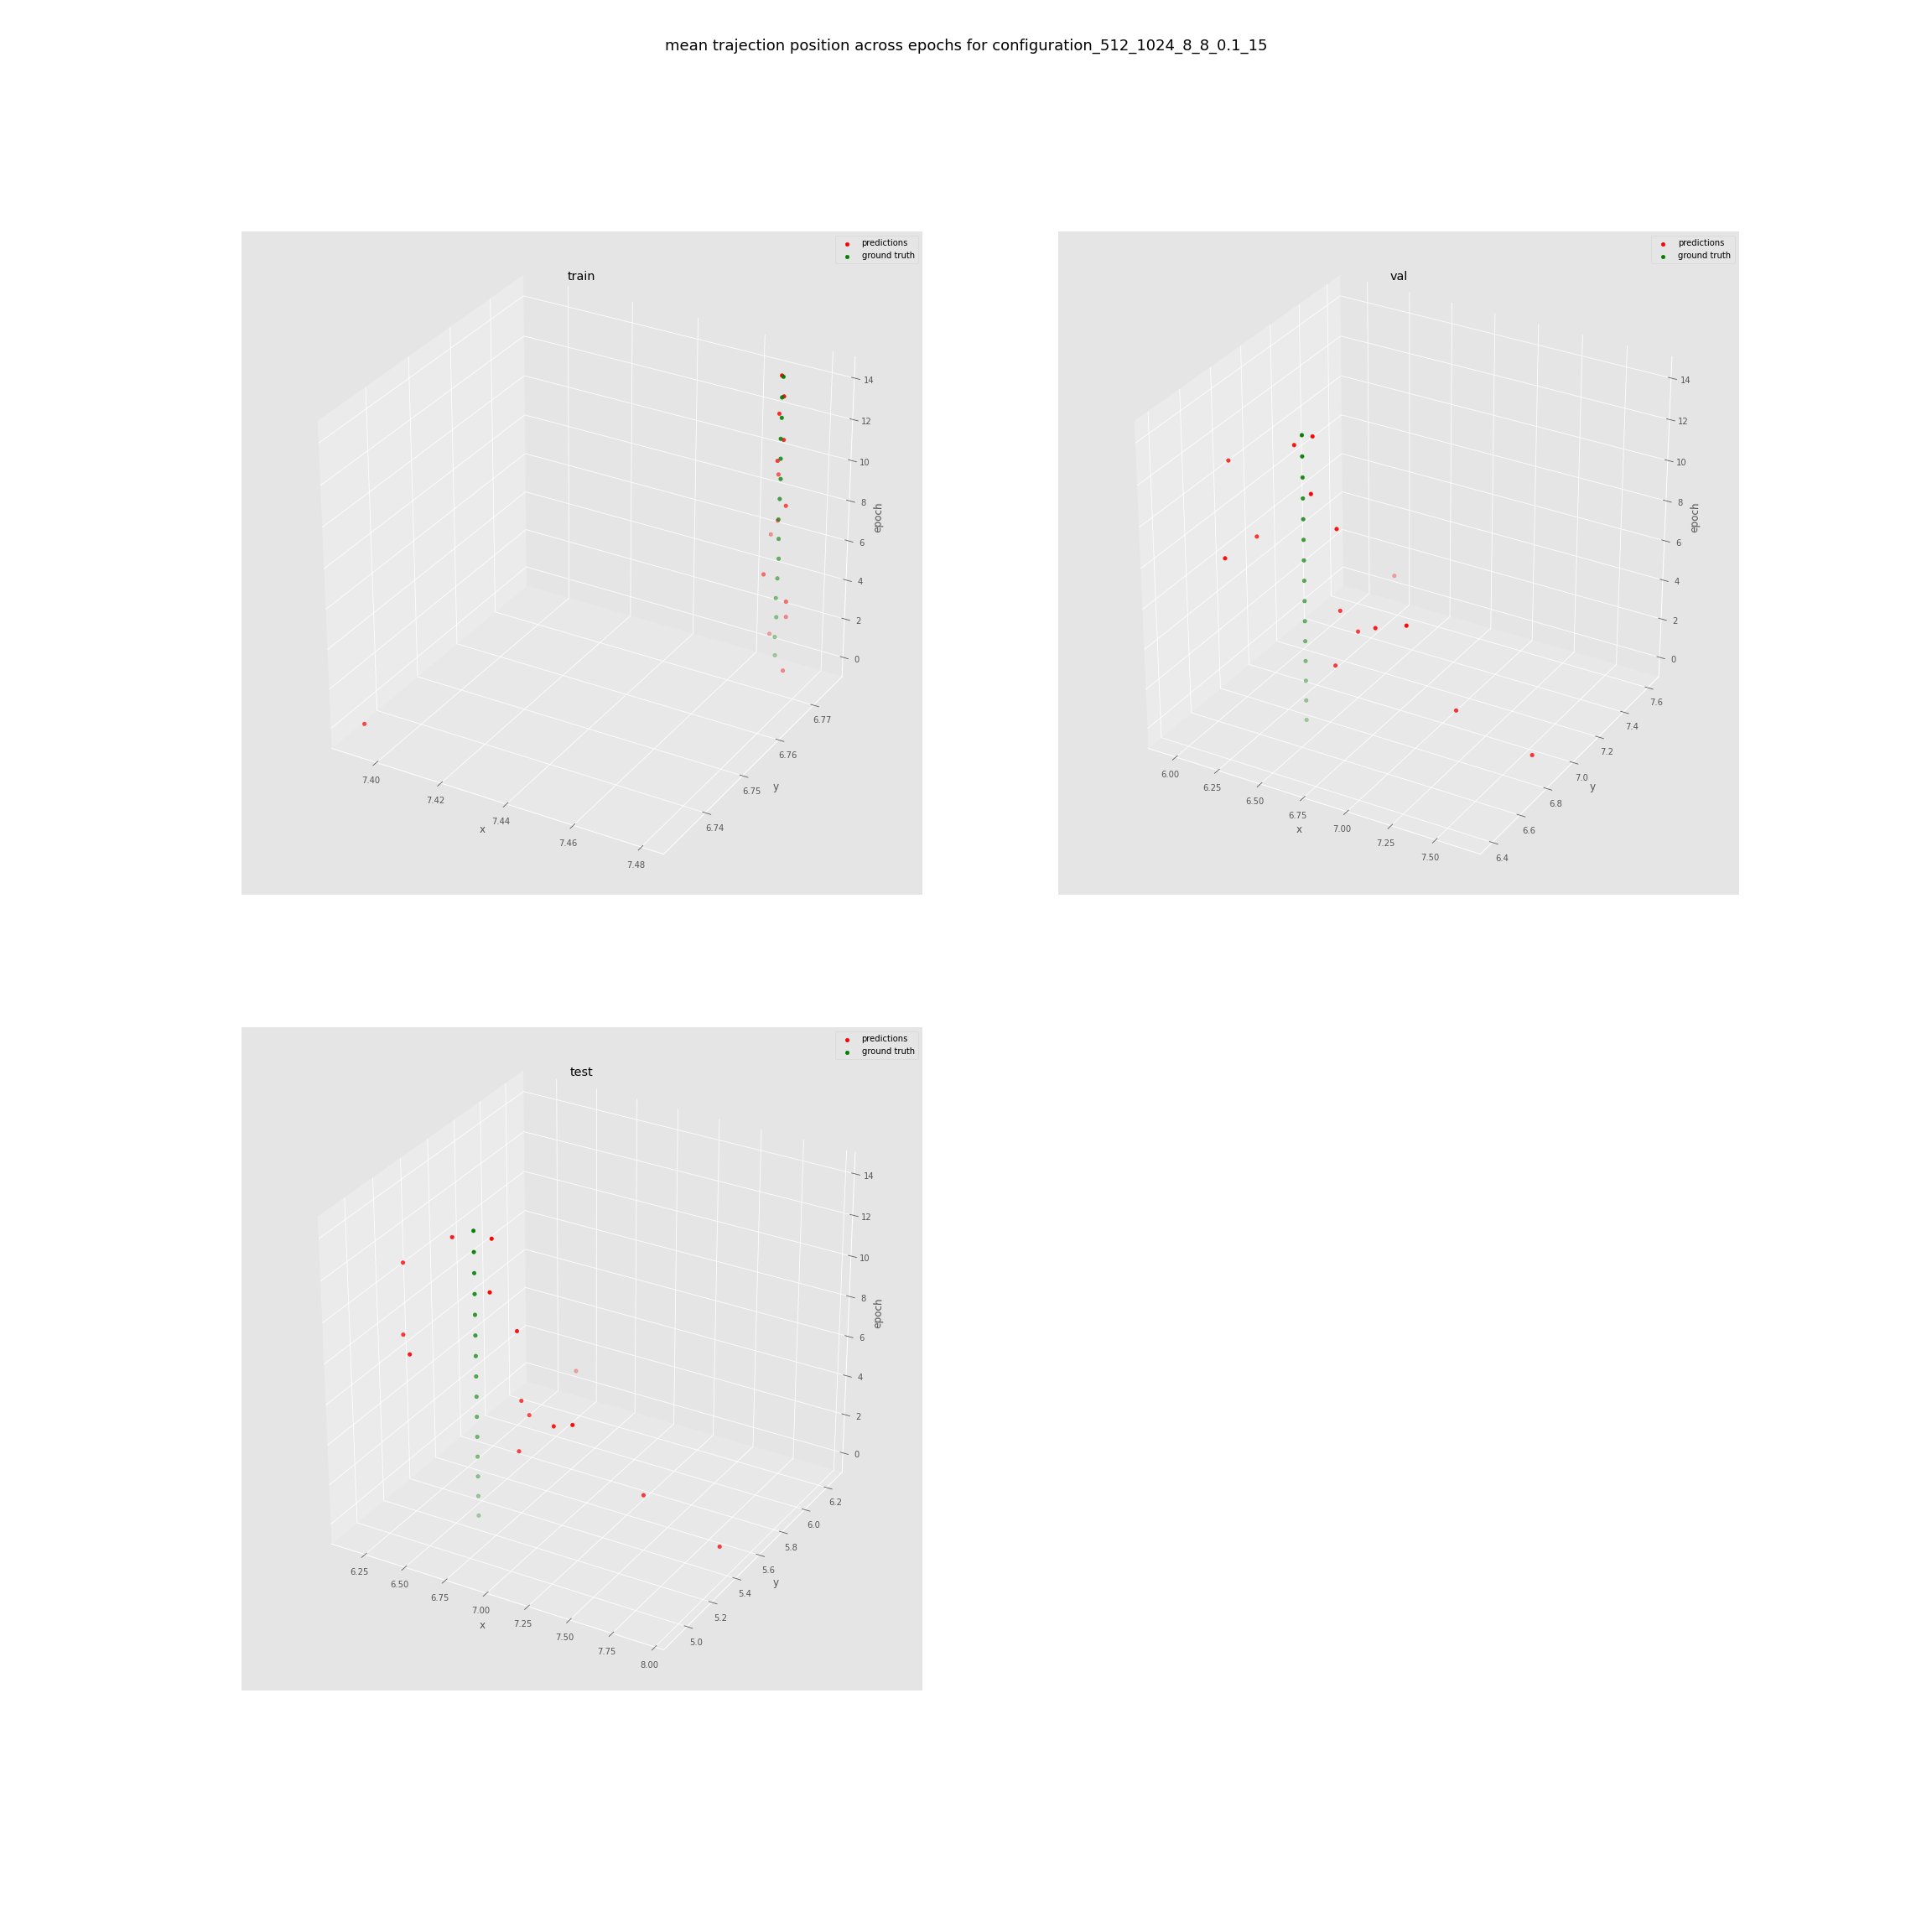

In [ ]:
img = Image.open(path_trajection)
img

# Ablation Studies


Here we ask you to change some settings in order to compare the benefit of some specific mechanism.

Please follow the instructions and create a small report for each point adding your comments supported by plots, tables with results or whatever you think is usefull.

Each extra study included to improve general performance or to draft a more complete analysis will be considered.

---

**Note:** to have a fair comparison we suggest to fix the setup (i.e. Regressive TF with speeds, obs=8, pred=12, ...) and change just the analysed module.

---

## 1. Substitute for the Prediction Framework  (***6 POINTS***)

---

The standard task is the regression of future speeds/positions. 

We propose to implement to different frameworks: Gaussian and Quantized.

---

### a.  Gaussian


Predicting normal distribution parameters mean vector $\mu = (\mu_x, \mu_y)$ and covariance matrix $\Sigma = \biggl( \begin{smallmatrix}\sigma_x^2 & \rho \sigma_x \sigma_y\\ \rho \sigma_x \sigma_y & \sigma_y^2 \end{smallmatrix}\biggr)$ of future predicition. 

Then the model output dimension is 5: 2 for mean parameters $\mu_x, \mu_y$ and 3 for the covariance parameters $\sigma_x, \sigma_y, \rho$.

---

Note: consider carefully the following code snippet. In this way we force $\sigma_x, \sigma_y$ to be positive and $\rho$ to be in $[-1, 1]$

The following lines are meant to be a hint. Integrate those into the code of the previous cells.

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'gauss'
obs_num = 8
preds_num = 12

torch.manual_seed(1234)

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_eth_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading students003_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

In [ ]:
batch_size = 512 # Default is 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 8
dropout = 0.2

Next prediction can be now sampled from the predicted distribution making the forecasting stochastic.

The loss used in this case is the NLL.  

Note: To relax the assumption you can also use predicted mean as input for following step (particularly in eval and test), avoiding the sampling and assuming identity as covariance matrix.

In [ ]:
# Here your code 
class gaussian_model(individual_TF.IndividualTF):

  def __init__(self,enc_inp_size,dec_inp_size,dec_out_size,N=6,
                   d_model=512, d_ff=2048, h=8, dropout=0.1,mean=[0,0],std=[0,0]):

    super(gaussian_model,self).__init__(enc_inp_size,dec_inp_size,dec_out_size,N=6,d_model=512, d_ff=2048, h=8, dropout=0.1,mean=[0,0],std=[0,0])
    


  def forward(self, *input):
        
        self.out=self.model.generator(self.model(*input)) #base model
        out=self.my_act(self.out) 
        return out

  def my_act(self,out,preds_num=12):
    X = out
    mean_parameters=torch.zeros((12,2))
    cov_matrixes=torch.zeros((12,2,2))

    mask=X[:,:,2]
      
    for step in range(out.size()[1]): #for each prediction step get the means and the covariance matrix
        x=X[:,step,0]
        y=X[:,step,1]
        
        x_y=torch.stack((x,y),dim=0) #stack vectors togheter to do the covariance matrix after
        
        mux = torch.mean(x)
        muy = torch.mean(y)

        

        mean_parameters[step,0]=mux
        mean_parameters[step,1]=muy
        
        cov_matrixes[step]=torch.cov(x_y)

        
    return mean_parameters,cov_matrixes,mask #the mask is used in the eval step  
    

In [ ]:
model = gaussian_model(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


In [ ]:
# Argument for the optimizer 
factor = 1 # default is 1.
warmup = 1 # default is 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):
    #print("eval_step")
    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    #print("the input size is",inp.size())

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq
    #print("the src att size is ",src_att.size())
    #print("the size of the start of the seq is ",start_of_seq.size())
    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):

        out_with_mask=None
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        pred_means,pred_cov_mat, pred_mask = model(inp, dec_inp, src_att, trg_att)

        pred_mask=pred_mask[:,i]

        #print('initial_mask',pred_mask.size())
       
        means= pred_means[i]
        covariance= pred_cov_mat[i]

        mnorms=torch.distributions.MultivariateNormal(means.to(device),covariance.to(device)) #multivariate normal for that step

        out=mnorms.sample([len(batch['src'])]) #samples batch_size predictions from the esimated multivariate normal
        out=torch.unsqueeze(out,1)
        pred_mask=torch.unsqueeze(pred_mask,1)
        pred_mask=torch.unsqueeze(pred_mask,2)
        #print('out',out.size())
        #print('pred_mask',pred_mask.size())
        
        #print('decoder input size',dec_inp.size())
        out_with_mask=torch.cat((out,pred_mask),2)
        #print('out with mask',out_with_mask.size())



        dec_inp = torch.cat((dec_inp, out_with_mask), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return pred_means,pred_cov_mat,dec_inp[:, 1:, :]

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 10   # Total number of epoch
ckp_save_step = 5      # Frequency for saving the model
log_step = 1           # Frequency for printing the loss

# The following variables are added for visualization purposes as required in the next part (Visualization)
# Make 'visualization' dictionary to store metrics
steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']
visualization = {step: {metric: [] for metric in metrics} for step in steps}
print("Start Training...\n")
for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch,optim._rate))
        

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):


        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict parameters for the normal
        pred_means,pred_cov_mat,mask = train_step(model, batch, mean, std, device)

        
        loss=0 #initialize the loss for this batch

        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        pred_speed=torch.zeros((len(batch['src']),preds_num,2)).to(device) #here store the predictions

        for step in range(preds_num):

          covariance= pred_cov_mat[step,:,:] #isolate covariance matrix for a single step

          gt_speed_step = gt_speed[:,step,:]

          means=pred_means[step,:] #isolate mux muy for a single step
          
          mnorms=torch.distributions.MultivariateNormal(means.to(device),covariance.to(device)) #multivariate normal for that step

          pred_speed[:,step,:]=mnorms.sample([len(batch['src'])]) #samples batch_size predictions from the esimated multivariate normal

        
          loss+= -mnorms.log_prob(gt_speed_step).mean()

        loss.backward() #backward with all the steps

        optim.step()

        train_loss += loss.item() * batch['trg'].shape[0]


        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        
    
    #After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # Update 'visualization' dictionary
    visualization['train']['loss'].append(train_loss/len(tr_dl))
    visualization['train']['mad'].append(mad)
    visualization['train']['fad'].append(fad)
    visualization['train']['pr_posit'].append(pr_posit)
    visualization['train']['gt_posit'].append(gt_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))
       

    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_means,pred_cov_mat,pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)

            loss=0 #initialize the loss for this batch

            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            for step in range(preds_num):

              covariance= pred_cov_mat[step,:,:]

              gt_speed_step = gt_speed[:,step,:]

              means=pred_means[step,:] #isolate mux muy for a single step
          
              mnorms=torch.distributions.MultivariateNormal(means.to(device),covariance.to(device)) #multivariate normal for that step
        
              loss+= -mnorms.log_prob(gt_speed_step).mean()


            
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        
        # Update 'visualization' dictionary
        visualization['val']['loss'].append(val_loss/len(val_dl))
        visualization['val']['mad'].append(mad)
        visualization['val']['fad'].append(fad)
        visualization['val']['pr_posit'].append(pr_posit)
        visualization['val']['gt_posit'].append(gt_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))

         ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

          pred_means,pred_cov_mat,pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)

          loss=0 #initialize the loss for this batch

          gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)


          for step in range(preds_num):

              covariance= pred_cov_mat[step,:,:]

              gt_speed_step = gt_speed[:,step,:]

              means=pred_means[step,:] #isolate mux muy for a single step
          
              mnorms=torch.distributions.MultivariateNormal(means.to(device),covariance.to(device)) #multivariate normal for that step
        
              loss+= -mnorms.log_prob(gt_speed_step).mean()
  
          test_loss += loss.item() * batch['trg'].shape[0]

          if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
          elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

          pr.append(preds_tr_b)
          gt.append(batch['trg'][:, :, 0:2])

        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # Update 'visualization' dictionary
        visualization['test']['loss'].append(test_loss/len(test_dl))
        visualization['test']['mad'].append(mad)
        visualization['test']['fad'].append(fad)
        visualization['test']['pr_posit'].append(pr)
        visualization['test']['gt_posit'].append(gt)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        #torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'visualization_dict' : visualization
        }, f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))



Start Training...

---> Epoch 001/010 <---  LR: 0.00000
Total Train Loss: 60192.7677 - MAD:  9.2291 - FAD: 16.4720
Total Eval  Loss: 29663.1712 - MAD:  3.5844 - FAD:  6.1849
Total Test  Loss: 38723.2022 - MAD:  4.6770 - FAD:  8.2264 

---> Epoch 002/010 <---  LR: 0.00781
Total Train Loss: 20615.8027 - MAD:  2.0218 - FAD:  3.5581
Total Eval  Loss: 18678.9241 - MAD:  1.6547 - FAD:  2.9535
Total Test  Loss: 22049.4314 - MAD:  2.7216 - FAD:  4.9726 

---> Epoch 003/010 <---  LR: 0.00552
Total Train Loss: 18096.8159 - MAD:  1.6881 - FAD:  2.9761
Total Eval  Loss: 16477.0807 - MAD:  1.4685 - FAD:  2.5590
Total Test  Loss: 18626.0362 - MAD:  2.6771 - FAD:  4.8679 

---> Epoch 004/010 <---  LR: 0.00451
Total Train Loss: 17734.7146 - MAD:  1.6295 - FAD:  2.8647
Total Eval  Loss: 16039.9152 - MAD:  1.4334 - FAD:  2.4949
Total Test  Loss: 19361.1136 - MAD:  2.7111 - FAD:  4.9175 

---> Epoch 005/010 <---  LR: 0.00391
Total Train Loss: 17884.1549 - MAD:  1.6811 - FAD:  2.9673
Total Eval  Loss: 159

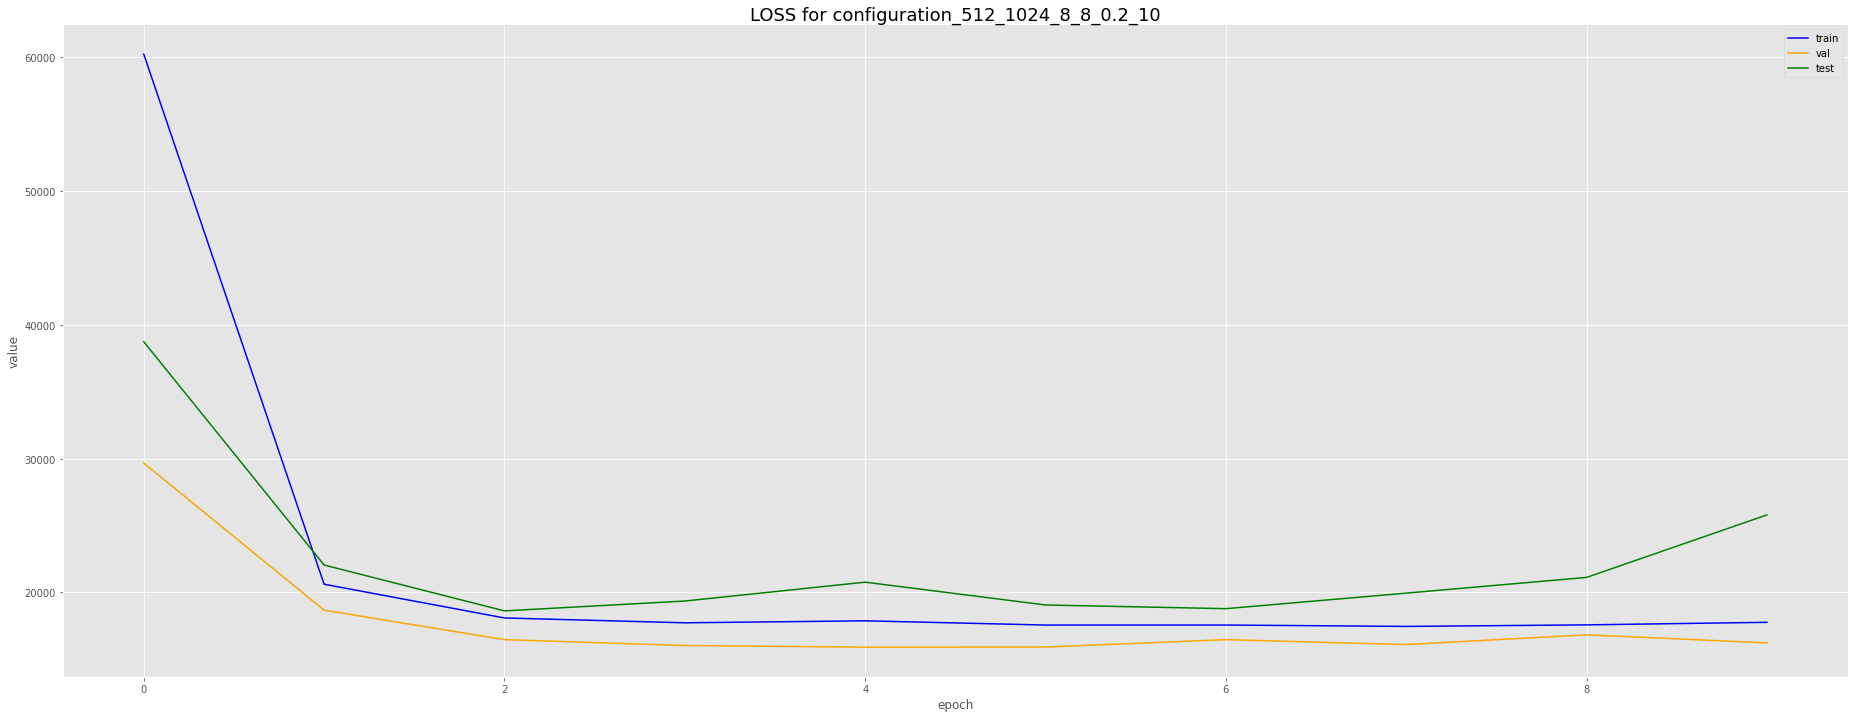

In [ ]:
loss_obj = [ visualization[step]['loss'] for step in steps ]
plot_metrics(loss_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

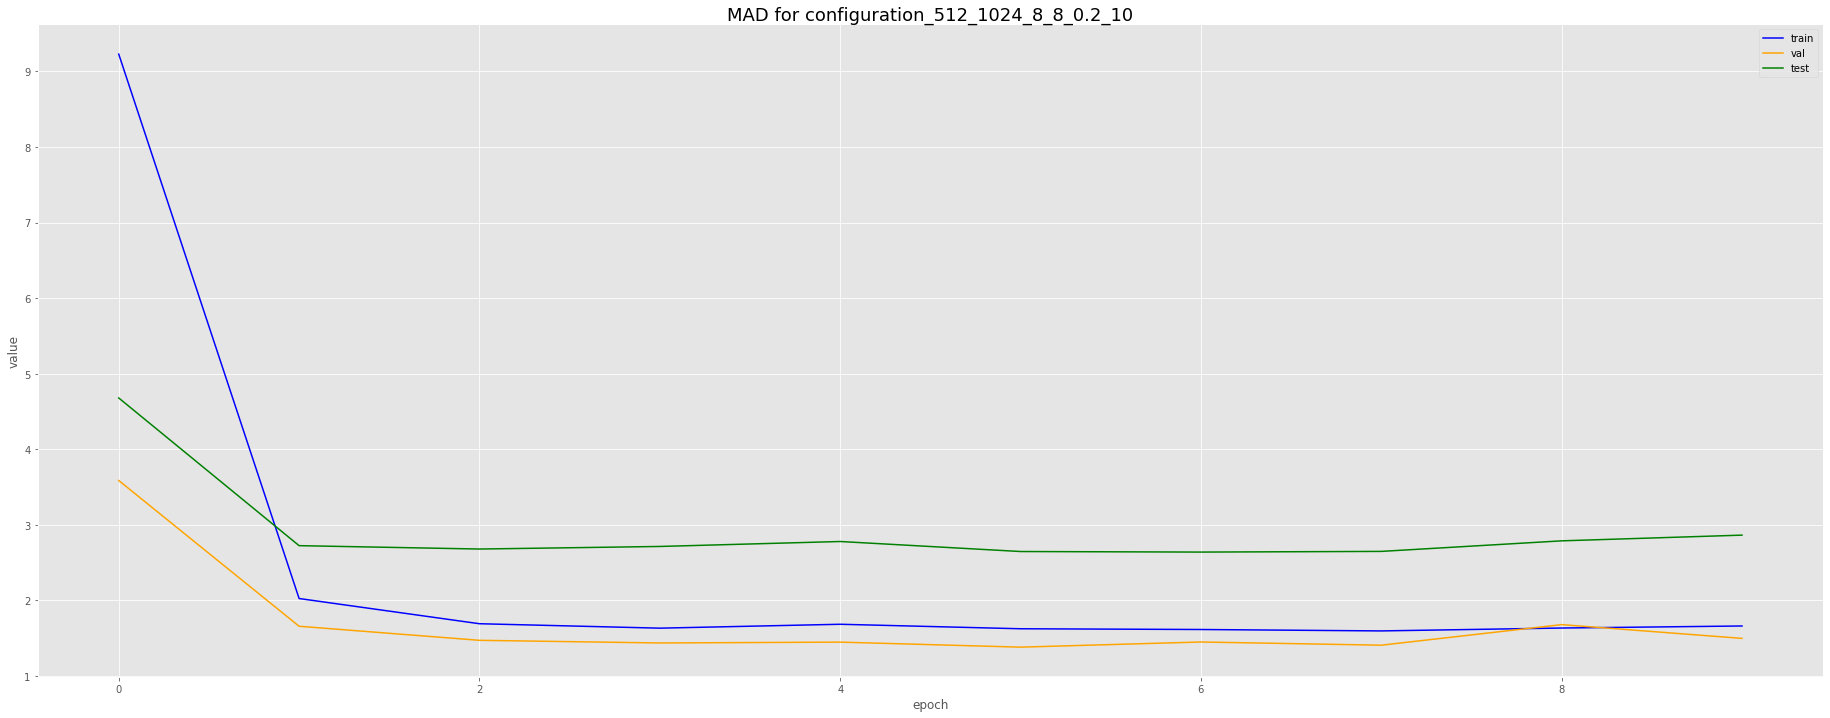

In [ ]:
mad_obj = [ visualization[step]['mad'] for step in steps ]
plot_metrics(mad_obj,metric='MAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

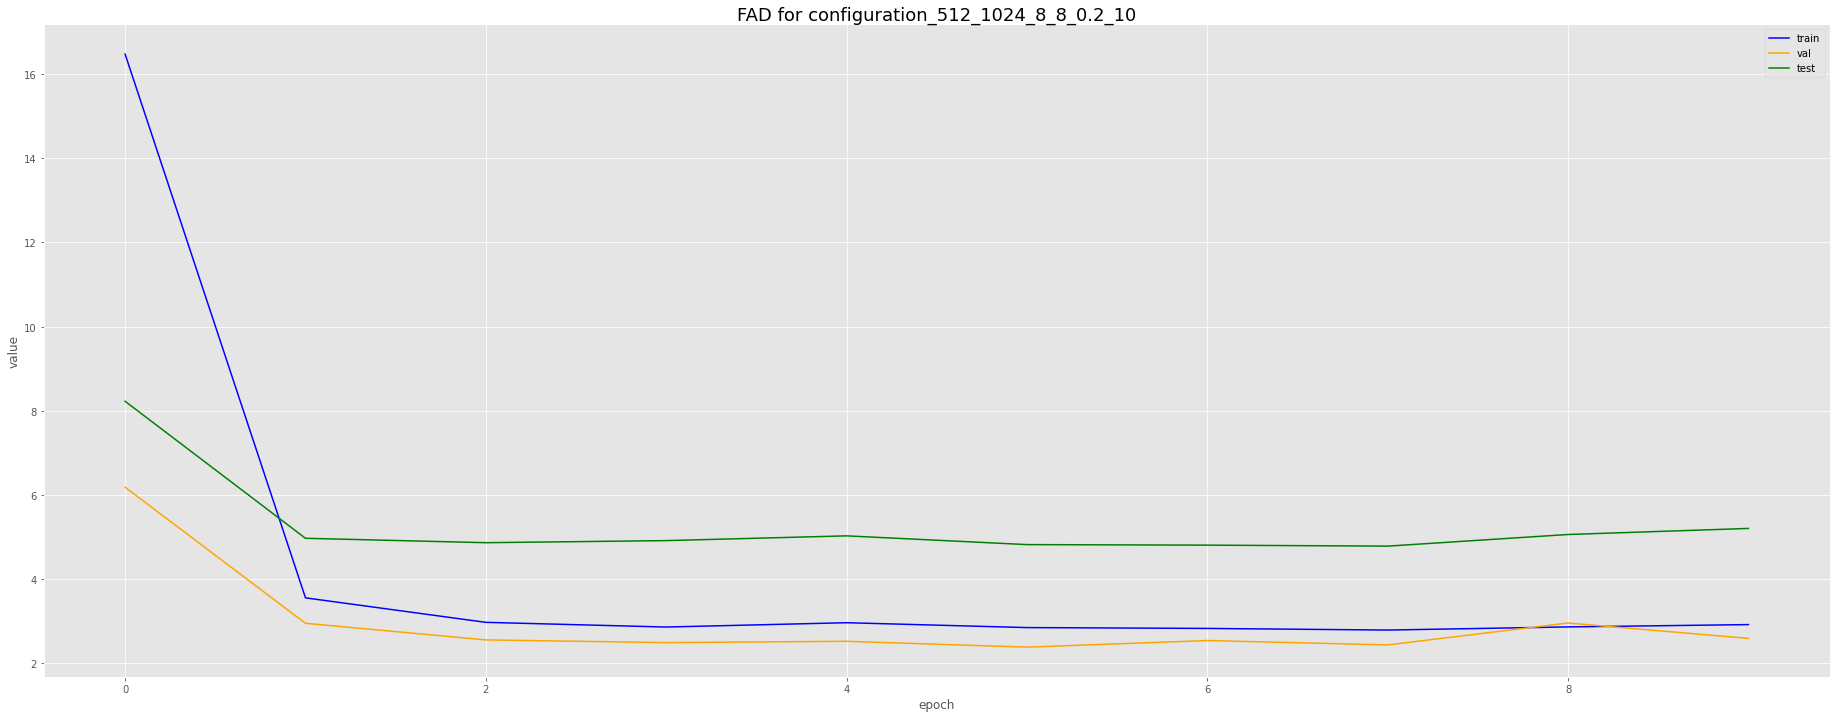

In [ ]:
fad_obj = [ visualization[step]['fad'] for step in steps ]
plot_metrics(fad_obj,metric='FAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

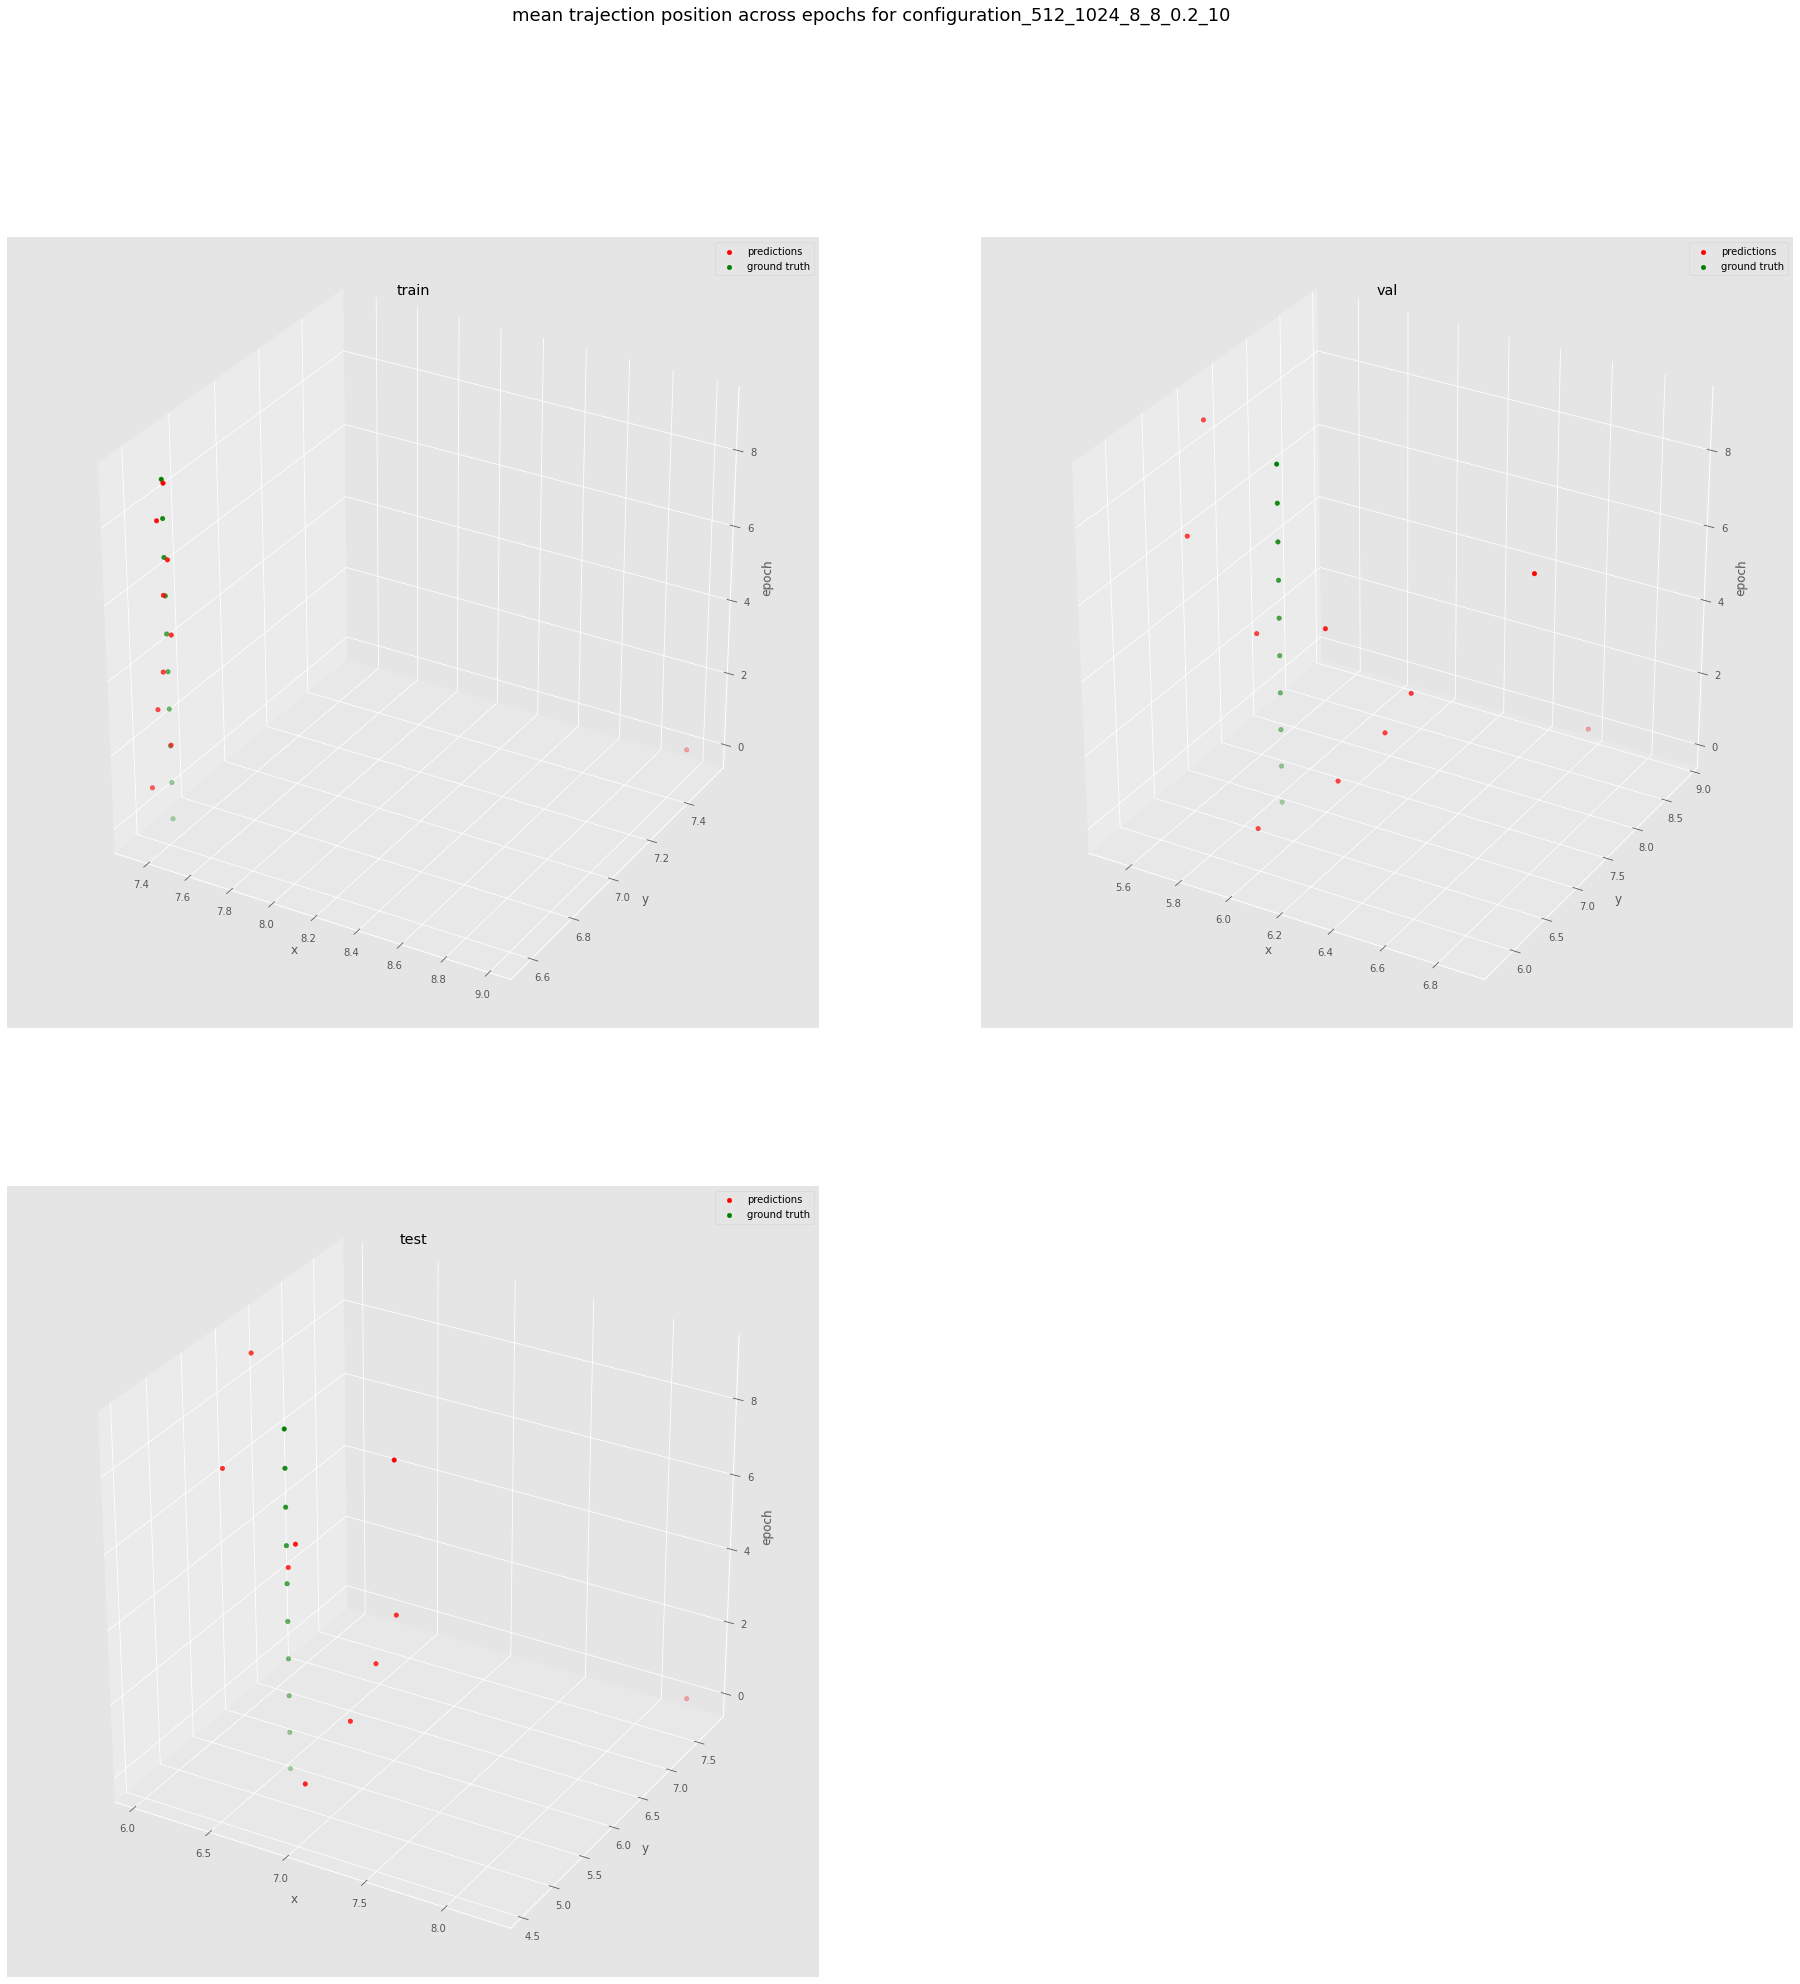

In [ ]:
pred_obj = [ visualization[step]['pr_posit'] for step in steps ]
gt_obj = [ visualization[step]['gt_posit'] for step in steps ]
plot_trajection(pred_obj,gt_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

Here your report

it is possible to observe that the results of the  Gaussian model are worse then the base one. From the loss's graph, we can see the model learns just for 2/3 epochs, and then it stops learning. Therefore, we can claim that this model suffers from strong underfitting  with respect to the previous model. However, we can see that the validation and training curves have a similar behaviour during training, so that the model generalizes well. We have obtained comparable results not only with this hyperparameters configuration as shown above, but also with other configurations.These poor performances may be due to different reasons:    
*   Implementation errors
*   Backpropagating one time for each batch after having sum up all the losses of the different predictions steps instead of backprogating after each prediction step may lead to a loss of information
*   The predictions are now stochastic and not deterministic
*   The batch size could be too low to estimate the true Multivariate Normal
---

---

### b. Quantized

Transformer was originally introduced in the NLP i.e. for next word classification task.
    
To emulate this case we change dataset (clustering all possible speed in C classes) and model to classify the most likely one (with CE loss).

Here we provide a script for the quantized dataset, so you may adapt the final part of the model to output probability score for each class (output_size=1000 + softmax) followed by CE loss.

---

Note: In the quantized framework the start of sequence token is adapted: 

The class indices spans from 0 to 999, so we add index 1000 to represent the start of sequence token

The following lines are meant to be hint, wisely integrate them with the code in the previous cells.  

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'quant'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# Load precomputed clusters to quantize the data
mat = scipy.io.loadmat(os.path.join('datasets', dataset_name, "clusters.mat"))
clusters=mat['centroids']
num_classes = clusters.shape[0]

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_eth_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading students003_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
batch_size = 512 # Default is 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = num_classes
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = num_classes+1
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = num_classes

emb_size = 512
ff_size = 512
heads = 8
layers = 3
dropout = 0.5


model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

In [ ]:
def train_step(model, batch, device):
    # Inside the train and eval step we need to convert speed/position to cluster index

    batch_size = batch['src'].shape[0]

    # Get input batch except first token, possibily the start of sequence token
    # 2:4 is the "speeds" part of the batch
    speeds_inp=batch['src'][:,1:,2:4]

    # Associate the nearest class to each speed/position
    inp=torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

    # We use one hot encoding to transform indices in one hot vectors
    inp = F.one_hot(inp, num_classes = num_classes).float()

    # We do the same for target
    speeds_trg = batch['trg'][:,:,2:4]
    target = torch.tensor(scipy.spatial.distance.cdist(speeds_trg.reshape(-1, 2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

    # Class are indices from 0 to 999. 
    # We add index 1000 to represent the start of sequence token
    start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)

    # Final decoder input is the concatenation of target and the start of sequence token
    dec_inp = torch.cat((start_of_seq, target), 1)

    # When we do one_hot encoding the element in position [1000] is the mask value
    # 0 for every element of the original target batch and 1 for the start of sequence token
    dec_inp = F.one_hot(dec_inp.long(), num_classes=num_classes+1).float()

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    # Compute cross entropy loss, ignoring the start of sequence token in the predictions
    # By adding the token to target and keeping the one in pred the results don't change (tested)
    loss = F.cross_entropy(pred[:,1:,:].contiguous().view(-1, num_classes), target.view(-1), reduction='mean')

    return pred, loss


def eval_step(model, batch, device, preds=12):
    # Inside the train and eval step we need to convert speed/position to cluster index


    batch_size = batch['src'].shape[0]

    # Get input batch except first token, possibily the start of sequence token
    # 2:4 is the "speeds" part of the batch
    speeds_inp=batch['src'][:,1:,2:4]
    
    # Associate the nearest class to each speed/position
    inp=torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

    # We use one hot encoding to transform indices in one hot vectors
    inp = F.one_hot(inp, num_classes = num_classes).float()

    # We do the same for target
    speeds_trg = batch['trg'][:,:,2:4]
    target = torch.tensor(scipy.spatial.distance.cdist(speeds_trg.reshape(-1, 2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.

    # Class are indices from 0 to 999. 
    # We add index 1000 to represent the start of sequence token
    start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)
    
    # The decoder input is the only start of sequence token [1000]
    # "Please note that now model has to predict also the third channel mask (See loss2 in the main loop)"
    # The above sentence is not true for this exercise since in the given code for the quantized model
    # the output size is num_classes, which means there is not enough room for the mask channel
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)

    dec_inp = start_of_seq
    dec_inp = F.one_hot(dec_inp, num_classes=num_classes+1).float()

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        # Add 0 for the channel mask
        out = F.pad(out, (0, 1), "constant", 0)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)
        

    # Like train
    loss = F.cross_entropy(dec_inp[:,1:,:1000].contiguous().view(-1, num_classes), target.view(-1), reduction='mean')

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :], loss

In [ ]:
# Argument for the optimizer 
factor = 0.1 # default is 1.
warmup = 50 # default is 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 15         # Total number of epoch
ckp_save_step = 5      # Frequency for saving the model
log_step = 1           # Frequency for printing the loss

# The following variables are added for visualization purposes as required in the next part (Visualization)
# Make 'visualization' dictionary to store metrics
steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']

visualization = {step: {metric: [] for metric in metrics} for step in steps}

print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):
        
        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed, loss = train_step(model, batch, device)

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
        # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
        # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
        # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
        # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
        # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds

        # We need indices for the clusters so we do an argmax to get it from the one hot encoding
        pred_speed = pred_speed.argmax(axis=2)
        # Get predicted trajectories by summing the original position to the prediction
        preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[pred_speed.cpu().numpy()].cumsum(1)
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)[:,1:,:]
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # Update 'visualization' dictionary
    visualization['train']['loss'].append(train_loss/len(tr_dl))
    visualization['train']['mad'].append(mad)
    visualization['train']['fad'].append(fad)
    visualization['train']['pr_posit'].append(pr_posit)
    visualization['train']['gt_posit'].append(gt_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed, loss = eval_step(model, batch, device, preds=preds_num)

            val_loss += loss.item() * batch['trg'].shape[0]

            # We need indices for the clusters so we do an argmax to get it from the one hot encoding
            pred_speed = pred_speed.argmax(axis=2)
            # Get predicted trajectories by summing the original position to the prediction
            preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[pred_speed.cpu().numpy()].cumsum(1)
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        
        # Update 'visualization' dictionary
        visualization['val']['loss'].append(val_loss/len(val_dl))
        visualization['val']['mad'].append(mad)
        visualization['val']['fad'].append(fad)
        visualization['val']['pr_posit'].append(pr_posit)
        visualization['val']['gt_posit'].append(gt_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed, loss = eval_step(model, batch, device, preds=preds_num)

            test_loss += loss.item() * batch['trg'].shape[0]

            # We need indices for the clusters so we do an argmax to get it from the one hot encoding
            pred_speed = pred_speed.argmax(axis=2)
            # Get predicted trajectories by summing the original position to the prediction
            preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[pred_speed.cpu().numpy()].cumsum(1)

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # Update 'visualization' dictionary
        visualization['test']['loss'].append(test_loss/len(test_dl))
        visualization['test']['mad'].append(mad)
        visualization['test']['fad'].append(fad)
        visualization['test']['pr_posit'].append(pr)
        visualization['test']['gt_posit'].append(gt)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        #torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'visualization_dict' : visualization
        }, f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 001/015 <---  LR: 0.00000
Total Train Loss: 3663.8665 - MAD:  1.8302 - FAD:  3.0450
Total Eval  Loss: 3487.5287 - MAD:  1.4879 - FAD:  2.5477
Total Test  Loss: 3388.6157 - MAD:  2.5453 - FAD:  4.6033 

---> Epoch 002/015 <---  LR: 0.00000
Total Train Loss: 3628.2445 - MAD:  1.8228 - FAD:  3.0367
Total Eval  Loss: 3455.1489 - MAD:  1.6104 - FAD:  2.8390
Total Test  Loss: 3385.4222 - MAD:  2.4912 - FAD:  4.5204 

---> Epoch 003/015 <---  LR: 0.00000
Total Train Loss: 3555.5359 - MAD:  1.7591 - FAD:  2.9452
Total Eval  Loss: 3411.4935 - MAD:  1.6722 - FAD:  2.9702
Total Test  Loss: 3381.9261 - MAD:  2.4735 - FAD:  4.4916 

---> Epoch 004/015 <---  LR: 0.00001
Total Train Loss: 3461.4014 - MAD:  1.5962 - FAD:  2.7427
Total Eval  Loss: 3378.1496 - MAD:  1.4496 - FAD:  2.6631
Total Test  Loss: 3385.2779 - MAD:  2.4759 - FAD:  4.4718 

---> Epoch 005/015 <---  LR: 0.00001
Total Train Loss: 3358.8141 - MAD:  1.4343 - FAD:  2.5547
Total Eval  Loss: 3353.6994 - MAD:

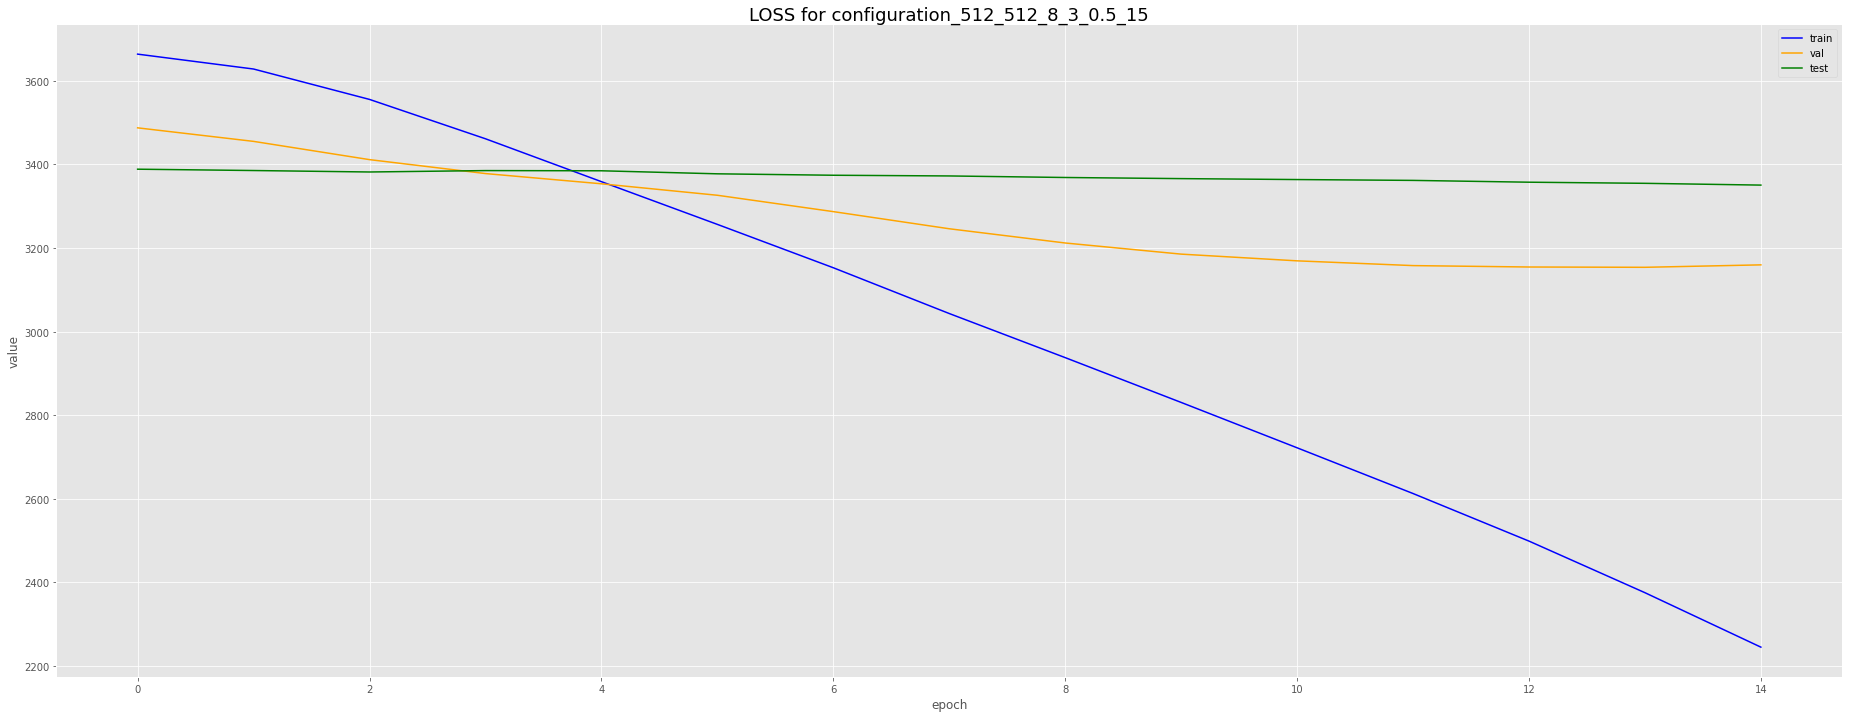

In [ ]:
loss_obj = [ visualization[step]['loss'] for step in steps ]
plot_metrics(loss_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

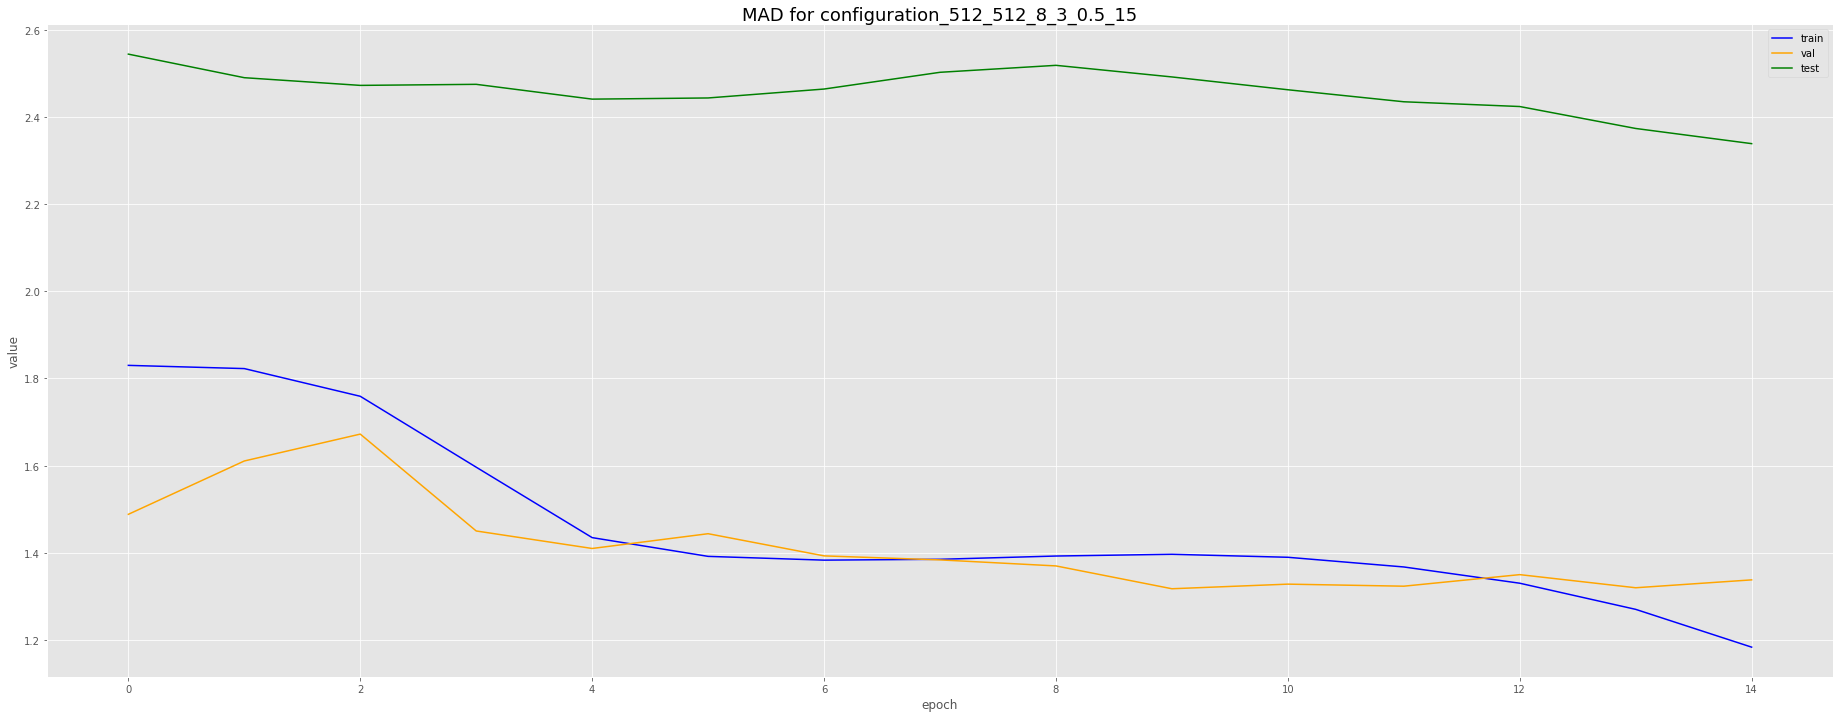

In [ ]:
mad_obj = [ visualization[step]['mad'] for step in steps ]
plot_metrics(mad_obj,metric='MAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

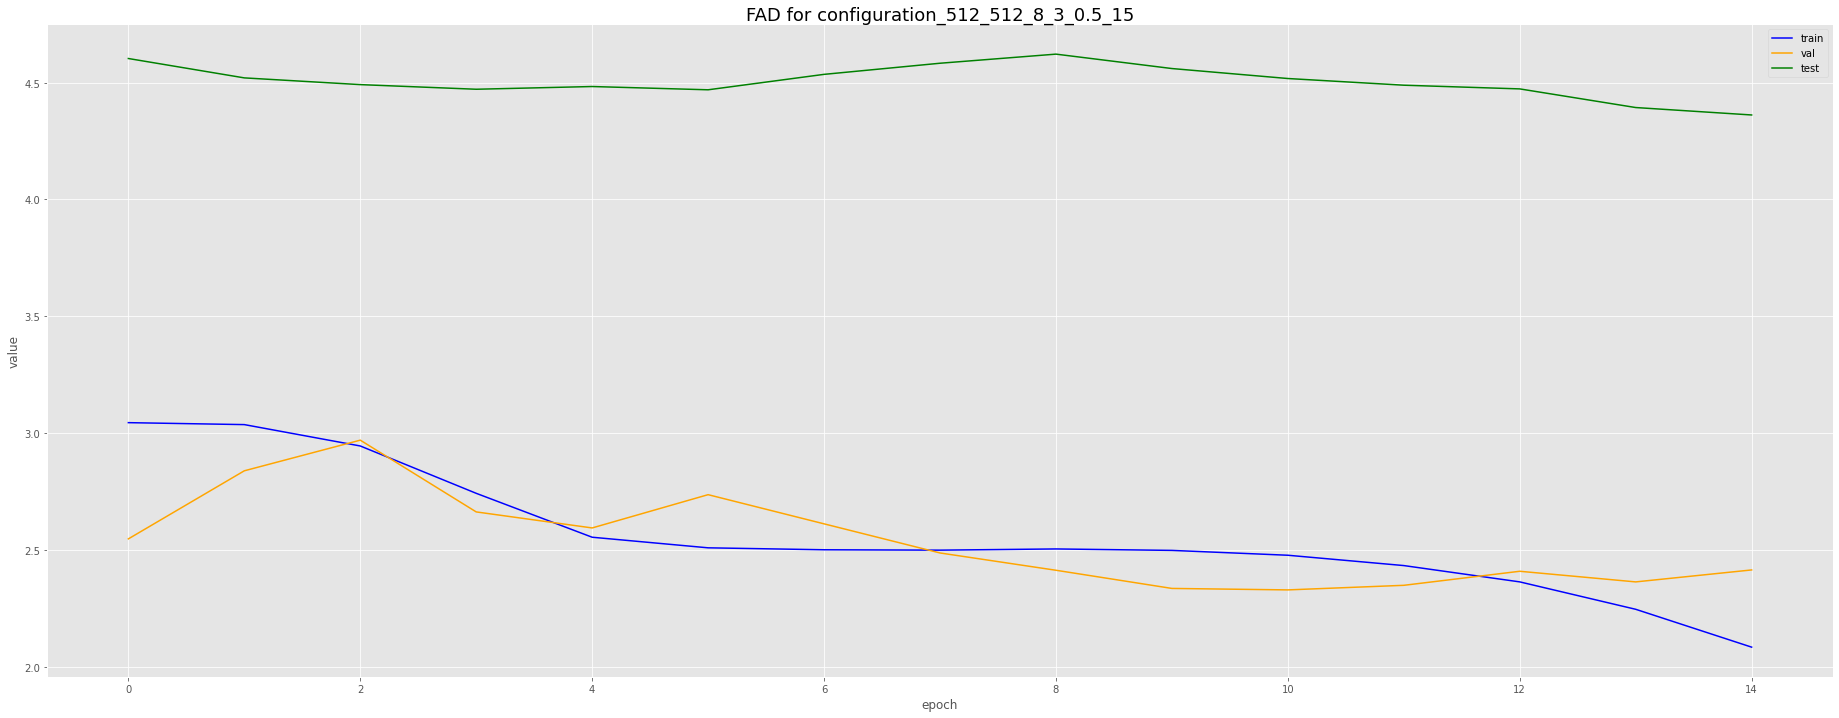

In [ ]:
fad_obj = [ visualization[step]['fad'] for step in steps ]
plot_metrics(fad_obj,metric='FAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

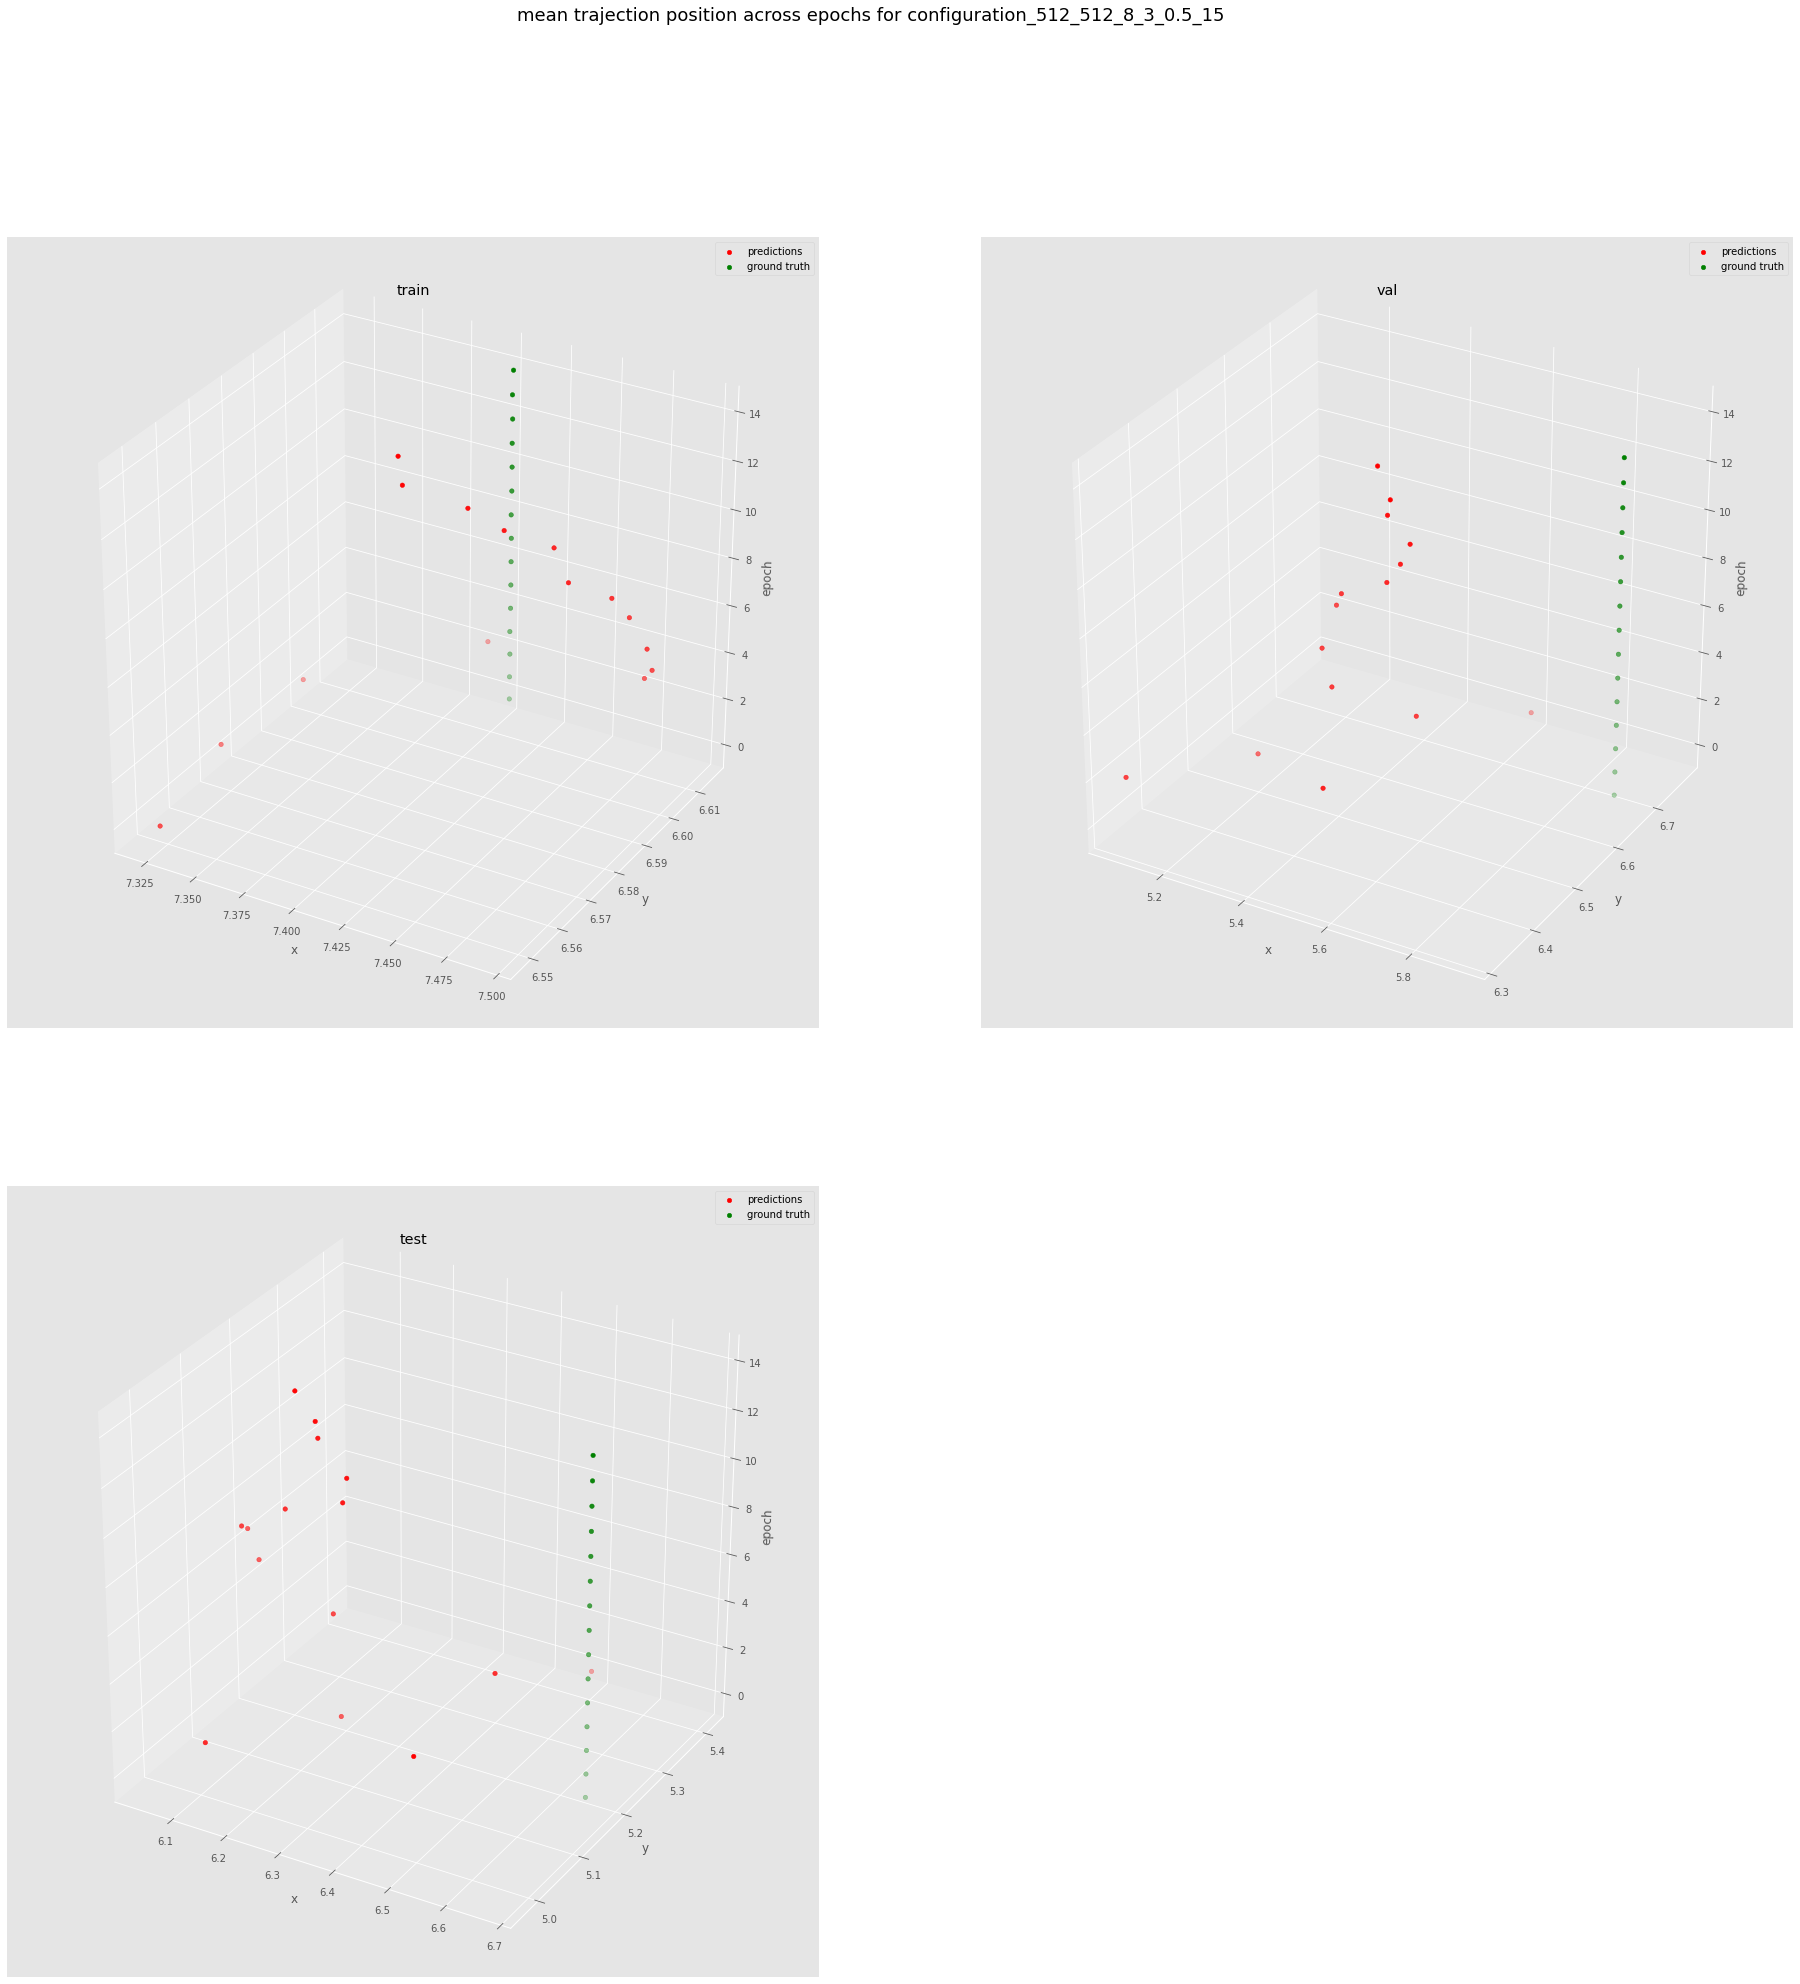

In [ ]:
pred_obj = [ visualization[step]['pr_posit'] for step in steps ]
gt_obj = [ visualization[step]['gt_posit'] for step in steps ]
plot_trajection(pred_obj,gt_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

In [ ]:
# Given Hints

# Inside the train and eval step we need to convert speed/position to cluster index
batch_size = batch['src'].shape[0]

# Associate the nearest class to each speed/position
speeds_inp=batch['src'][:,1:,2:4]
inp=torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)

speeds_trg = batch['trg'][:,:,2:4]
target = torch.tensor(scipy.spatial.distance.cdist(speeds_trg.reshape(-1, 2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)




# Class are indices from 0 to 999. 
# We add index 1000 to represent the start of sequence token
start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)



# We predict class indexes of future speeds/positions
output = model(inp, dec_inp, src_att, trg_att)

loss = F.cross_entropy(output.view(-1, num_classes), target.view(-1), reduction='mean')



# To compute metrics we need positions. Then we convert back each predicted index to the relative centroid speed/position values
preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[output.cpu().numpy()].cumsum(1)
pr.append(preds_tr_b)

### Report

---

After the initial training of the above implementation of the quantized framework we noticed that the training metrics decrease by a lot very fast, but they don't reflect an improvement on the evaluation of validation and test datasets. Our hypothesis at that point was that the model might be overfitting, and we tested such hypotesis by increasing the warmup period on the optimizer, thus decreasing the initial learning rate, by incrementing dropout and decreasing the number of parameters (layers and ff_size).

The final result shows that there is indeed a decrease in validation loss in the first few epochs, before eventually the overfitting model starts to lose in performance. Suspecting an error in the implementation we tried to go through each line of code (see comments in train/evaluation_step and main loop code) but were unfortunately unable to fix the issue.

## 2. Increase Prediction Horizon (Short- or Long-term Forecasting)  (***3 POINTS***)

---

You can easily increase/decrease the number of predictions (i.e. pred = 4, 8, 12, 20, 30, 50 ....) in the dataloader and see the effect on the MAD/FAD metric.

Report your results in a table and/or plot and comment what you see.

---

In [ ]:
# Here your code 


# Arguments to setup the datasets
dataset_name = 'zara1'
framework = '15epochs0001_01_5'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 100
torch.manual_seed(1234)
# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_eth_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading students003_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


Here your report

we get the following results using the base model varying the number of predictions and observations evaluated using 15 epochs.

| num_obs | num_preds | Train_MAD | Eval_MAD | Test_MAD | Train_FAD | Eval_FAD | Test_FAD |
|-------|--------|---------|----------|---------|----------|---------|---------|
| 25    | 4      | 0.0634  | 0.1179   | 0.1261  | 0.0876   | 0.2092  | 0.2231  |
| 15    | 4      | 0.0683  | 0.1335   | 0.1108  | 0.0946   | 0.2446  | 0.2043  |
| 12    | 8      | 0.0946  | 0.2775   | 0.2669  | 0.1366   | 0.5838  | 0.5710  |
| 8     | 12     | 0.1326  | 0.5737   | 0.5018  | 0.2006   | 1.170   | 1.03    |
| 8     | 20     | 0.1449  | 0.8793   | 1.010   | 0.2163   | 2.029   | 2.407   |
| 4     |  25    | 0.1640  | 1.271    | 1.4206  |0.2459    | 2.991   |3.321    |

We see  clearly the best configuration is the one with the largest number of observations for the input (25) and the smallest number of predictions (4).
in addition,like we expected,  if we decrease the input size we got worse perforances. Finally it's interesting to note that  the one that the best tradeoff in terms of prediction and input size has  obs=12 and preds=8 especially if we compare its result in terms of EVAL and Test MAD/FAD with the other models with larger number of predictions.
 


---

---

## 3. Increasing Data Number  (***3 POINTS***)

Transformers are generally very large network and need a lot of data to perform well.

Try to vary the percentage data variable (i.e. 10, 25, 50, 75, 100) and see how the performance changes.

Please report here plots and/or tables for:

1. MAD and FAD metrics 

2. Computational time

In [ ]:
perc_data_list=[20,40,60,80,100]
computational_time={key: None for key in perc_data_list}

In [ ]:
# Here your code 

# Arguments to setup the datasets
dataset_name = 'zara1'
framework = '15epochs0001_01_5'
obs_num = 8
preds_num = 12

torch.manual_seed(1234)

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = perc_data_list[4]

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)


start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_eth_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading students003_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

In [ ]:
batch_size = 512 # Default is 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

In [ ]:
# Argument for the optimizer 
factor = 1 # default is 1.
warmup = 1 # default is 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 15   # Total number of epoch
ckp_save_step = 15      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss

# The following variables are added for visualization purposes as required in the next part (Visualization)
# Make 'visualization' dictionary to store metrics
steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']

visualization = {step: {metric: [] for metric in metrics} for step in steps}

print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):
        
        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # Update 'visualization' dictionary
    visualization['train']['loss'].append(train_loss/len(tr_dl))
    visualization['train']['mad'].append(mad)
    visualization['train']['fad'].append(fad)
    visualization['train']['pr_posit'].append(pr_posit)
    visualization['train']['gt_posit'].append(gt_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        
        # Update 'visualization' dictionary
        visualization['val']['loss'].append(val_loss/len(val_dl))
        visualization['val']['mad'].append(mad)
        visualization['val']['fad'].append(fad)
        visualization['val']['pr_posit'].append(pr_posit)
        visualization['val']['gt_posit'].append(gt_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # Update 'visualization' dictionary
        visualization['test']['loss'].append(test_loss/len(test_dl))
        visualization['test']['mad'].append(mad)
        visualization['test']['fad'].append(fad)
        visualization['test']['pr_posit'].append(pr)
        visualization['test']['gt_posit'].append(gt)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        #torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'visualization_dict' : visualization
        }, f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
computational_time[perc_data]=time.time() - start_time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 005/015 <---  LR: 0.00295
Total Train Loss: 164.6137 - MAD:  0.2488 - FAD:  0.2923
Total Eval  Loss: 448.3672 - MAD:  1.1695 - FAD:  1.9863
Total Test  Loss: 535.4747 - MAD:  1.8007 - FAD:  2.9373 

---> Epoch 010/015 <---  LR: 0.00197
Total Train Loss: 113.7335 - MAD:  0.1387 - FAD:  0.2044
Total Eval  Loss: 294.7290 - MAD:  0.5634 - FAD:  1.2830
Total Test  Loss: 280.1798 - MAD:  0.5273 - FAD:  1.2191 

---> Epoch 015/015 <---  LR: 0.00158
Total Train Loss: 97.3445 - MAD:  0.1184 - FAD:  0.1722
Total Eval  Loss: 279.6393 - MAD:  0.5158 - FAD:  1.1379
Total Test  Loss: 309.3593 - MAD:  0.5940 - FAD:  1.3834 

Saving checkpoint... 
 
Total time: 632.9118258953094 seconds


In [ ]:
computational_time

{20: 179.33058142662048,
 40: 316.8896234035492,
 60: 466.97044706344604,
 80: 575.574476480484,
 100: 632.9117426872253}

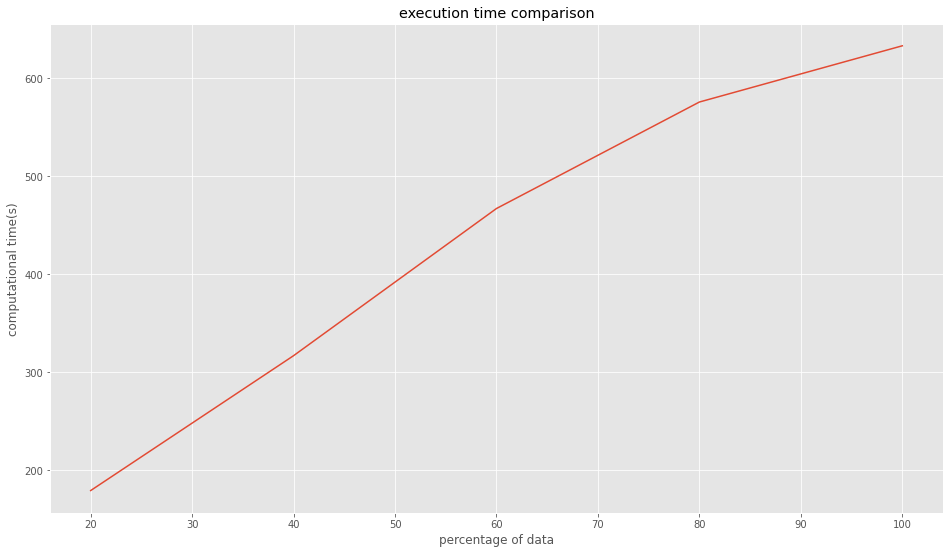

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.style.use('ggplot')
plt.title('execution time comparison')
percentage=[20,40,60,80,100]
values=[179.33,316.89,466.97,575.57,632.91]

plt.plot(percentage,values)
plt.xlabel('percentage of data')
plt.ylabel('computational time(s)')

plt.savefig(f'/content/drive/MyDrive/TF4AML/plots/percentage.png')

plt.show()

Here your report

---

**show the computational time plot**

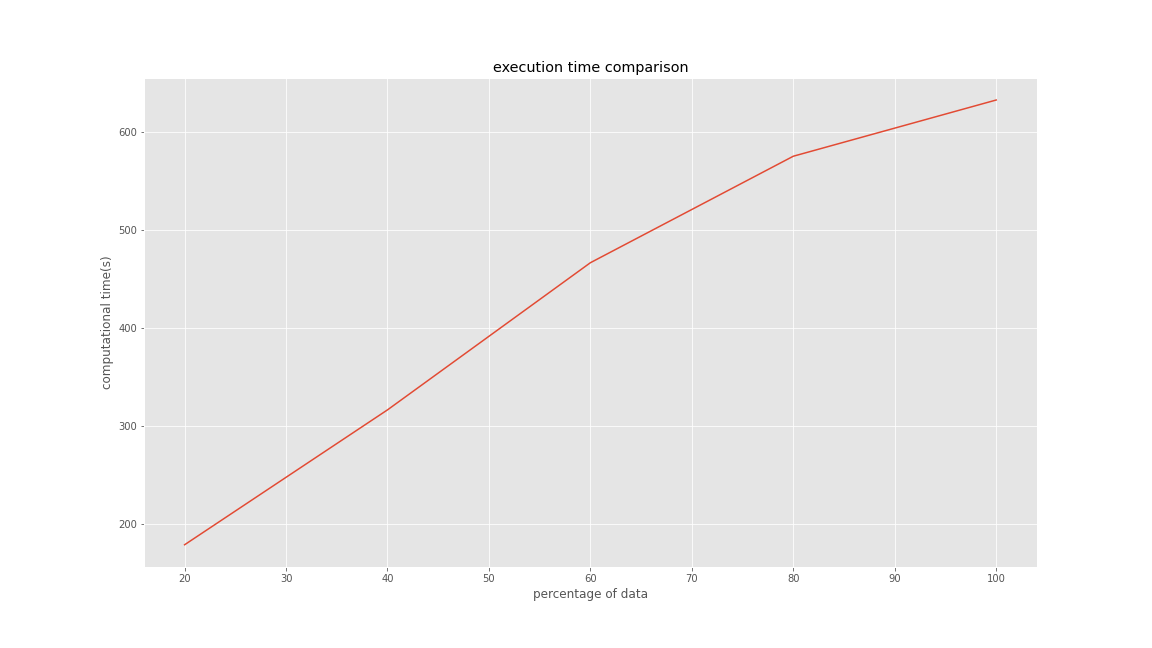

In [ ]:
from PIL import Image

path_time='/content/drive/MyDrive/TF4AML/plots/percentage.png'

img=Image.open(path_time)

img

**performance table using different percentages of data**

In the following table we will compare the results of a reference model, trained for 15 epochs, by only changing the percentage of data used during training.

| percentage | train loss | train MAD | train FAD | val loss | val MAD | val FAD |
|------------|------------|-----------|-----------|----------|---------|---------|
| 20         | 394,7088   | 1,032     | 1,8046    | 435,4976 | 1,1129  | 2,1872  |
| 40         | 175,8304   | 0,2804    | 0,3441    | 435,2025 | 1,2156  | 2,418   |
| 60         | 111,3984   | 0,1292    | 0,1868    | 309,5401 | 0,5855  | 1,3252  |
| 80         | 99,032     | 0,1194    | 0,1743    | 301,2644 | 0,5416  | 1,2033  |
| 100        | 97,3435    | 0,1184    | 0,1722    | 279,6393 | 0,5158  | 1,1379  |

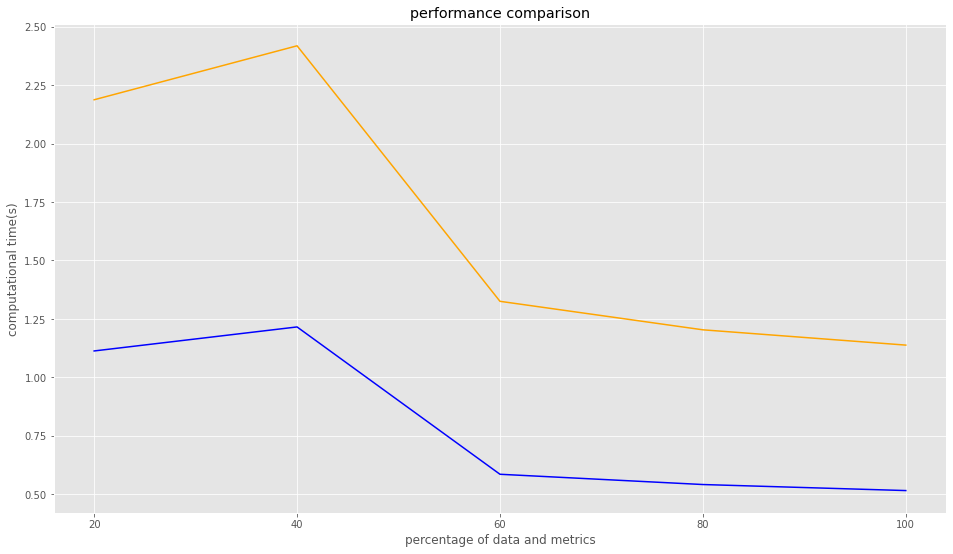

In [ ]:
percentage=[20,40,60,80,100]
val_MAD=[1.1129,1.2156,0.5855,0.5416,0.5158]
val_FAD= [2.1872,2.418,1.3252,1.2033,1.1379]


import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.style.use('ggplot')
plt.title('performance comparison')
plt.plot(percentage,val_MAD,label='MAD',color='blue')
plt.plot(percentage,val_FAD,label='FAD',color='orange')

plt.xlabel('percentage of data and metrics')
plt.xticks([20,40,60,80,100])
plt.ylabel('computational time(s)')

plt.savefig(f'/content/drive/MyDrive/TF4AML/plots/percentage_metrics.png')

plt.show()


It is possible to see that after a sharp decrease from 40% to 60% of data usage, the performance of the model slightly increment for both MAD and FAD on the validation set. Provided that the computational time keeps on growing almost linearly as shown above in the computational time graph, we may balance the tradeoff between model performance and training time by choosing 60 as optimal percentage of data.

## 4. Change input Type  (***2 POINTS*** - Bonus)

---

What happens if we change the input form speed type (u,v) to position one (x,y)?

Report then some quantitative results and plot trajectory predicted with both method to evaluate qualitative differences.

---

In [ ]:
# Here your code 

# Arguments to setup the datasets
dataset_name = 'zara1'
framework = '15epochs0001_01_5'
obs_num = 8
preds_num = 12

torch.manual_seed(1234)

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 60

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)


start loading dataset
validation set size -> 0
001 / 007 - loading uni_examples_train.txt
002 / 007 - loading crowds_zara02_train.txt
003 / 007 - loading biwi_eth_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading students001_train.txt
007 / 007 - loading crowds_zara03_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_val.txt
002 / 007 - loading students001_val.txt
003 / 007 - loading students003_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara03_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'position'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

In [ ]:
batch_size = 512 # Default is 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

In [ ]:
# Argument for the optimizer 
factor = 1 # default is 1.
warmup = 1 # default is 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 15   # Total number of epoch
ckp_save_step = 15      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss

# The following variables are added for visualization purposes as required in the next part (Visualization)
# Make 'visualization' dictionary to store metrics
steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']

visualization = {step: {metric: [] for metric in metrics} for step in steps}

print("Start Training...\n")


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):
        
        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

    # Update 'visualization' dictionary
    visualization['train']['loss'].append(train_loss/len(tr_dl))
    visualization['train']['mad'].append(mad)
    visualization['train']['fad'].append(fad)
    visualization['train']['pr_posit'].append(pr_posit)
    visualization['train']['gt_posit'].append(gt_posit)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        
        # Update 'visualization' dictionary
        visualization['val']['loss'].append(val_loss/len(val_dl))
        visualization['val']['mad'].append(mad)
        visualization['val']['fad'].append(fad)
        visualization['val']['pr_posit'].append(pr_posit)
        visualization['val']['gt_posit'].append(gt_posit)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])


        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

        # Update 'visualization' dictionary
        visualization['test']['loss'].append(test_loss/len(test_dl))
        visualization['test']['mad'].append(mad)
        visualization['test']['fad'].append(fad)
        visualization['test']['pr_posit'].append(pr)
        visualization['test']['gt_posit'].append(gt)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        #torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'visualization_dict' : visualization
        }, f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time

print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 005/015 <---  LR: 0.00363
Total Train Loss: 198.8596 - MAD:  1.0573 - FAD:  0.8108
Total Eval  Loss: 636.6220 - MAD:  4.2791 - FAD:  4.9083
Total Test  Loss: 506.9992 - MAD:  3.4767 - FAD:  4.6460 

---> Epoch 010/015 <---  LR: 0.00242
Total Train Loss: 113.6845 - MAD:  0.6544 - FAD:  0.3486
Total Eval  Loss: 629.2932 - MAD:  4.5939 - FAD:  6.0297
Total Test  Loss: 540.7799 - MAD:  4.0644 - FAD:  5.7477 

---> Epoch 015/015 <---  LR: 0.00194
Total Train Loss: 60.6431 - MAD:  0.3441 - FAD:  0.3081
Total Eval  Loss: 258.7693 - MAD:  1.8700 - FAD:  3.4677
Total Test  Loss: 227.5451 - MAD:  1.6907 - FAD:  2.9864 

Saving checkpoint... 
 
Total time: 477.37959122657776 seconds


In [ ]:
# Here your code 

import matplotlib.pyplot as plt

path_save="plots/plots_position_bonus"

# Create 'plots' directory
if not os.path.isdir(path_save):
    os.mkdir(f'/content/drive/MyDrive/TF4AML/{path_save}')

def plot_metrics(objects:list,metric='LOSS',sub_path='default_configuration'):

     labels=['train','val','test']
     colors=['blue','orange','green']

     plt.style.use('ggplot')

     fig=plt.figure(figsize=(32,12))
     

     plt.plot(list(objects[0]),color=colors[0],label='train')
     plt.plot(list(objects[1]),color=colors[1],label='val')
     plt.plot(list(objects[2]),color=colors[2],label='test')

     plt.title(f'{metric} for {sub_path}',fontsize=18,va='center',color='black')
     plt.xlabel('epoch')
     #plt.yscale('log')
     plt.ylabel('value')
     plt.legend()


     plt.savefig(f'/content/drive/MyDrive/TF4AML/{path_save}/{metric}_{sub_path}.png')
     
     plt.show()
  
     return

def plot_trajection(pred_obj:list,gt_obj:list,sub_path='default_configuration'):

     labels=['train','val','test']

     colors=['blue','orange','green']

     plt.style.use('ggplot')

     fig = plt.figure(figsize=(32,32))
     

     plt.suptitle(f'mean trajection position across epochs for {sub_path}',fontsize=18,color='black')

     

     pos=[221,222,223]

     for j in range(3):

       ax = fig.add_subplot(pos[j],projection='3d')

       x_pred=np.mean(list(pred_obj[j]),axis=(1,2))[:,0] #mean across samples, sequence.
       y_pred=np.mean(list(pred_obj[j]),axis=(1,2))[:,1]
       z_pred= [i for i in range(len(x_pred))]

       x_true=np.mean(list(gt_obj[j]),axis=(1,2))[:,0]
       y_true=np.mean(list(gt_obj[j]),axis=(1,2))[:,1]

       ax.scatter(x_pred,y_pred,z_pred,color='r',label='predictions')
       ax.scatter(x_true,y_true,z_pred,color='g',label='ground truth')
       ax.set_title(labels[j],color='black')
       ax.set_xlabel('x')
       ax.set_ylabel('y')
       ax.set_zlabel('epoch')
       ax.legend()

     plt.savefig(f'/content/drive/MyDrive/TF4AML/{path_save}/trajection_{sub_path}.png')

     plt.show()

     return

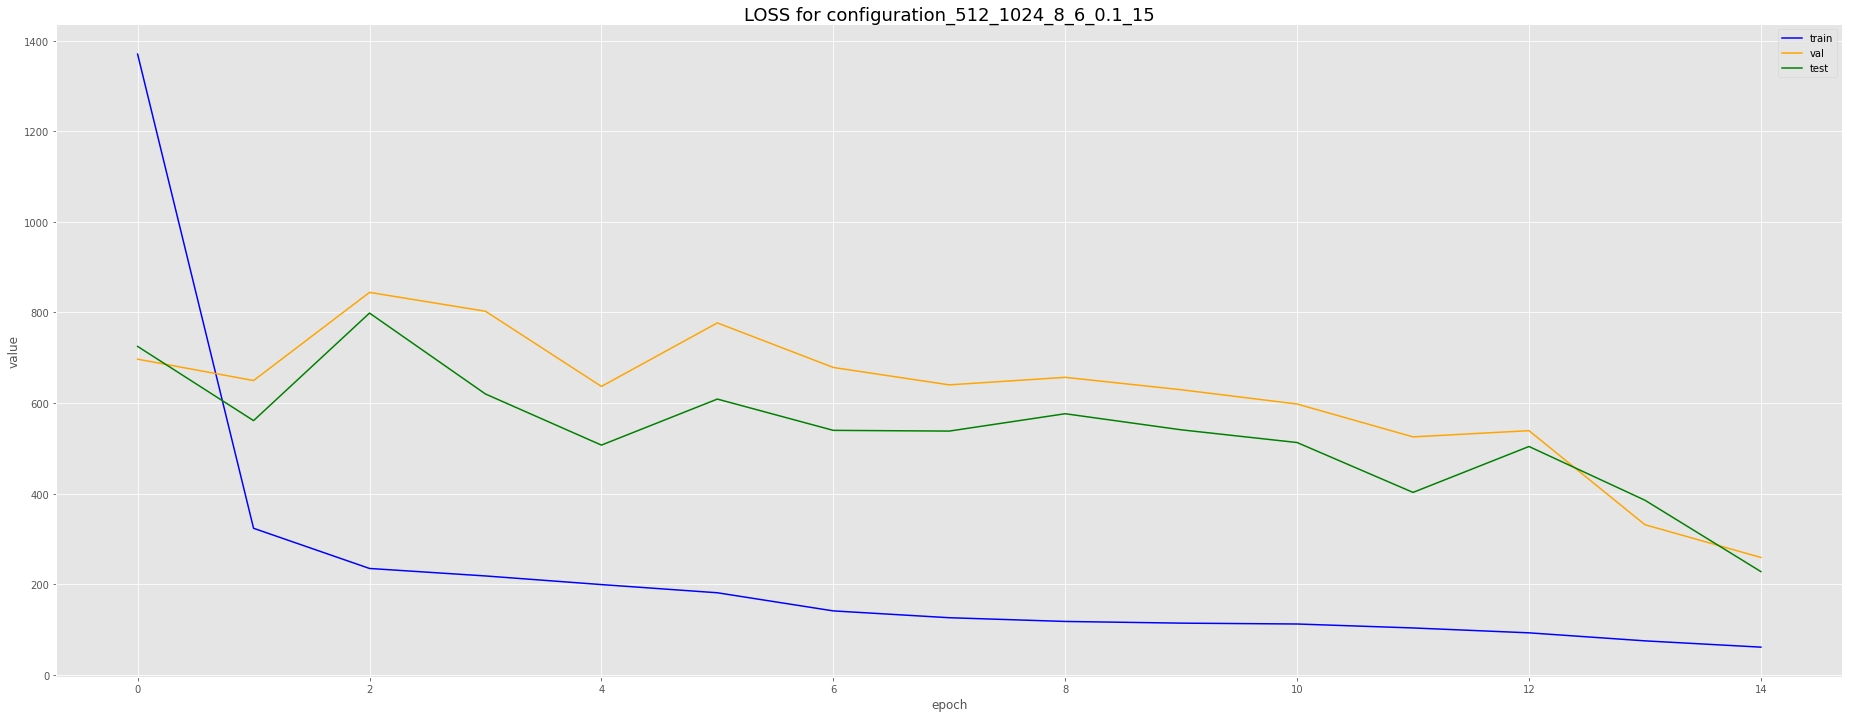

In [ ]:
loss_obj = [ visualization[step]['loss'] for step in steps ]
plot_metrics(loss_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

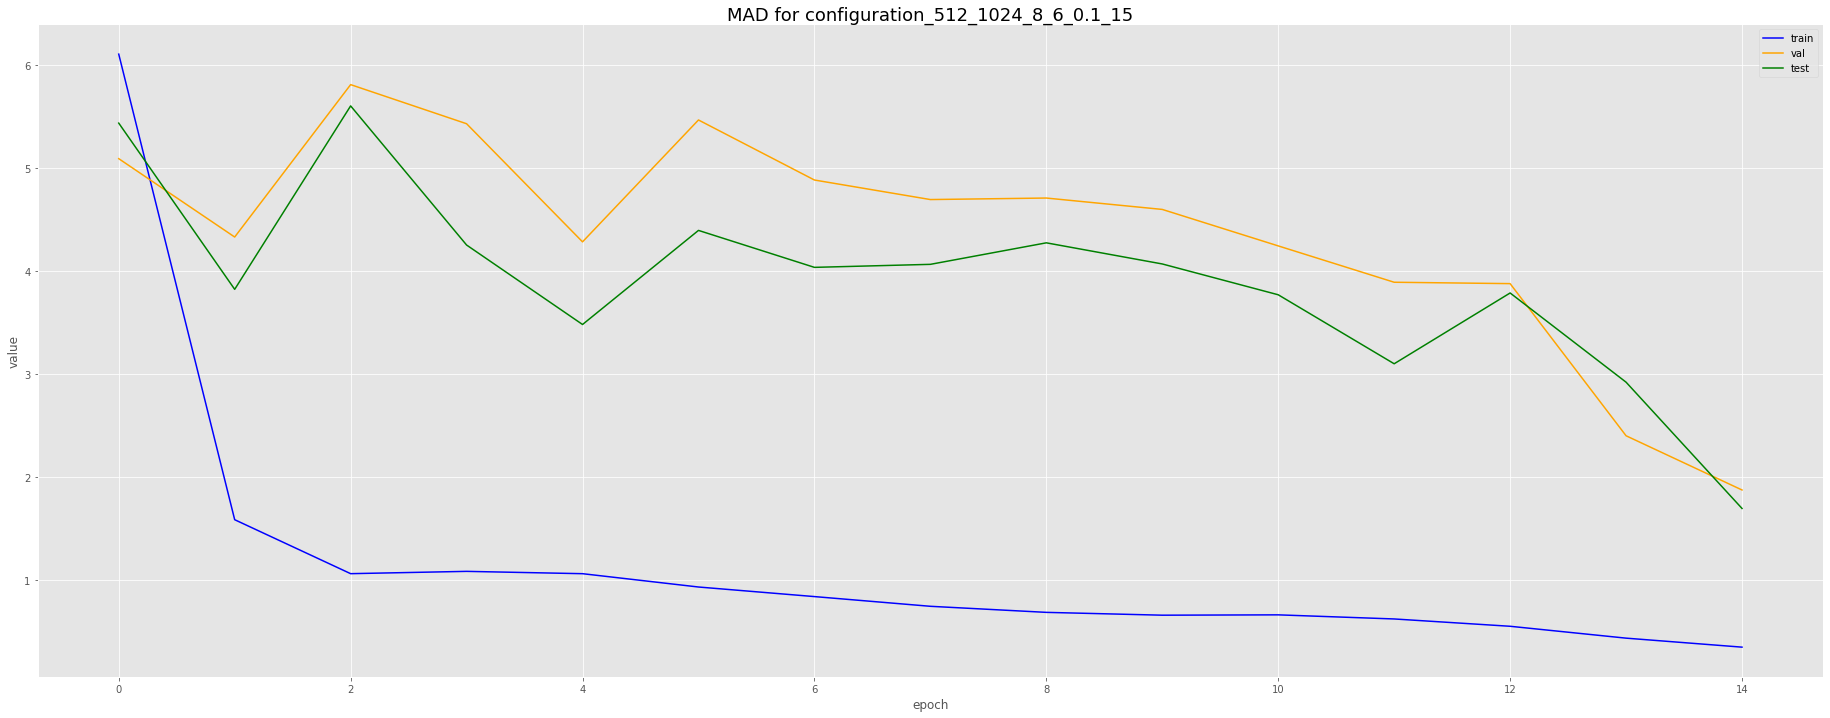

In [ ]:
mad_obj = [ visualization[step]['mad'] for step in steps ]
plot_metrics(mad_obj,metric='MAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

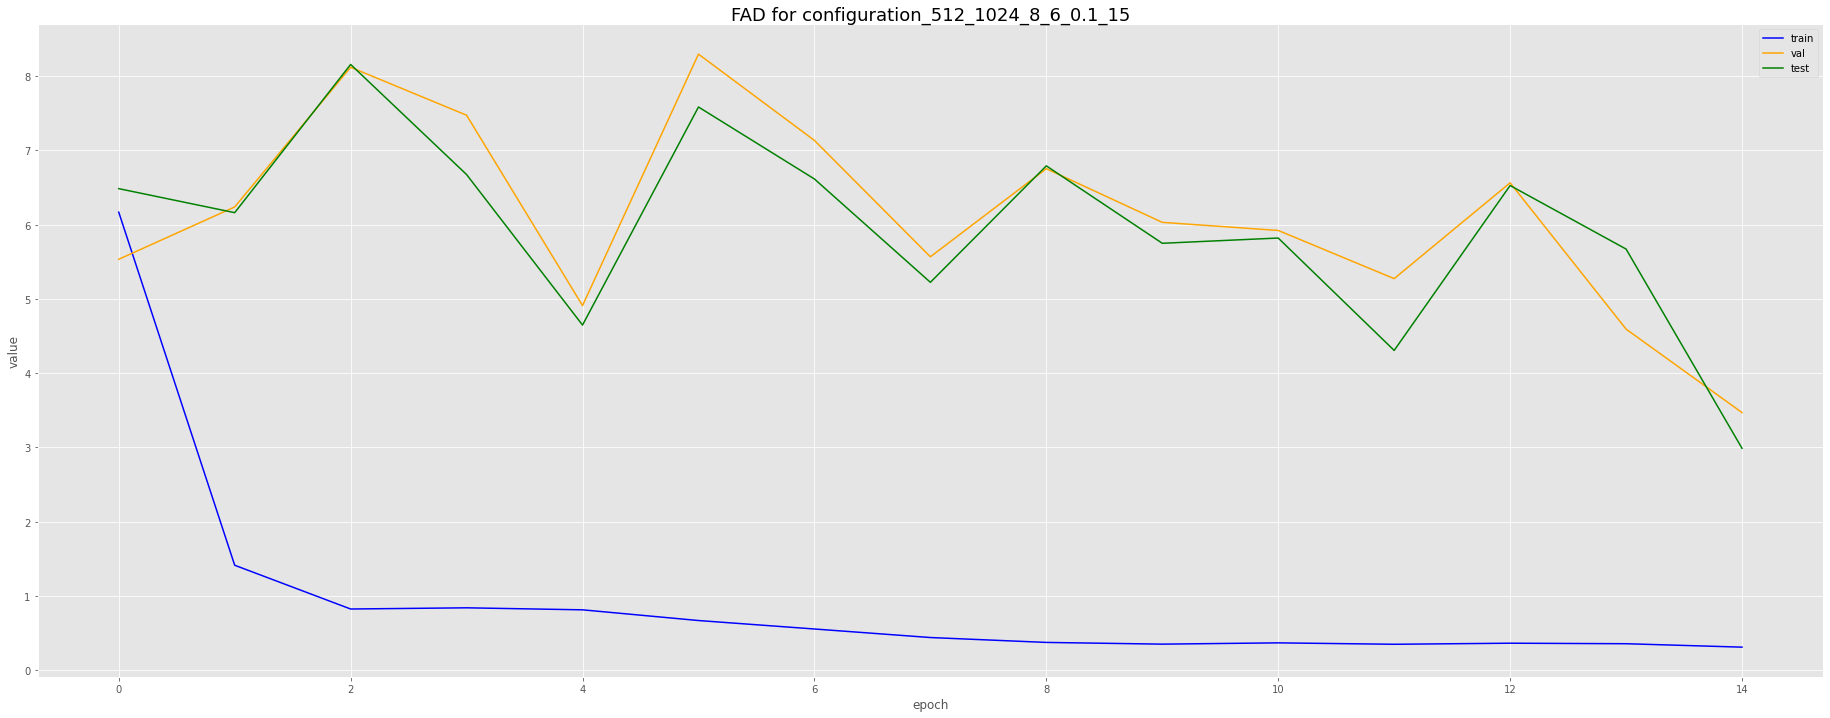

In [ ]:
fad_obj = [ visualization[step]['fad'] for step in steps ]
plot_metrics(fad_obj,metric='FAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

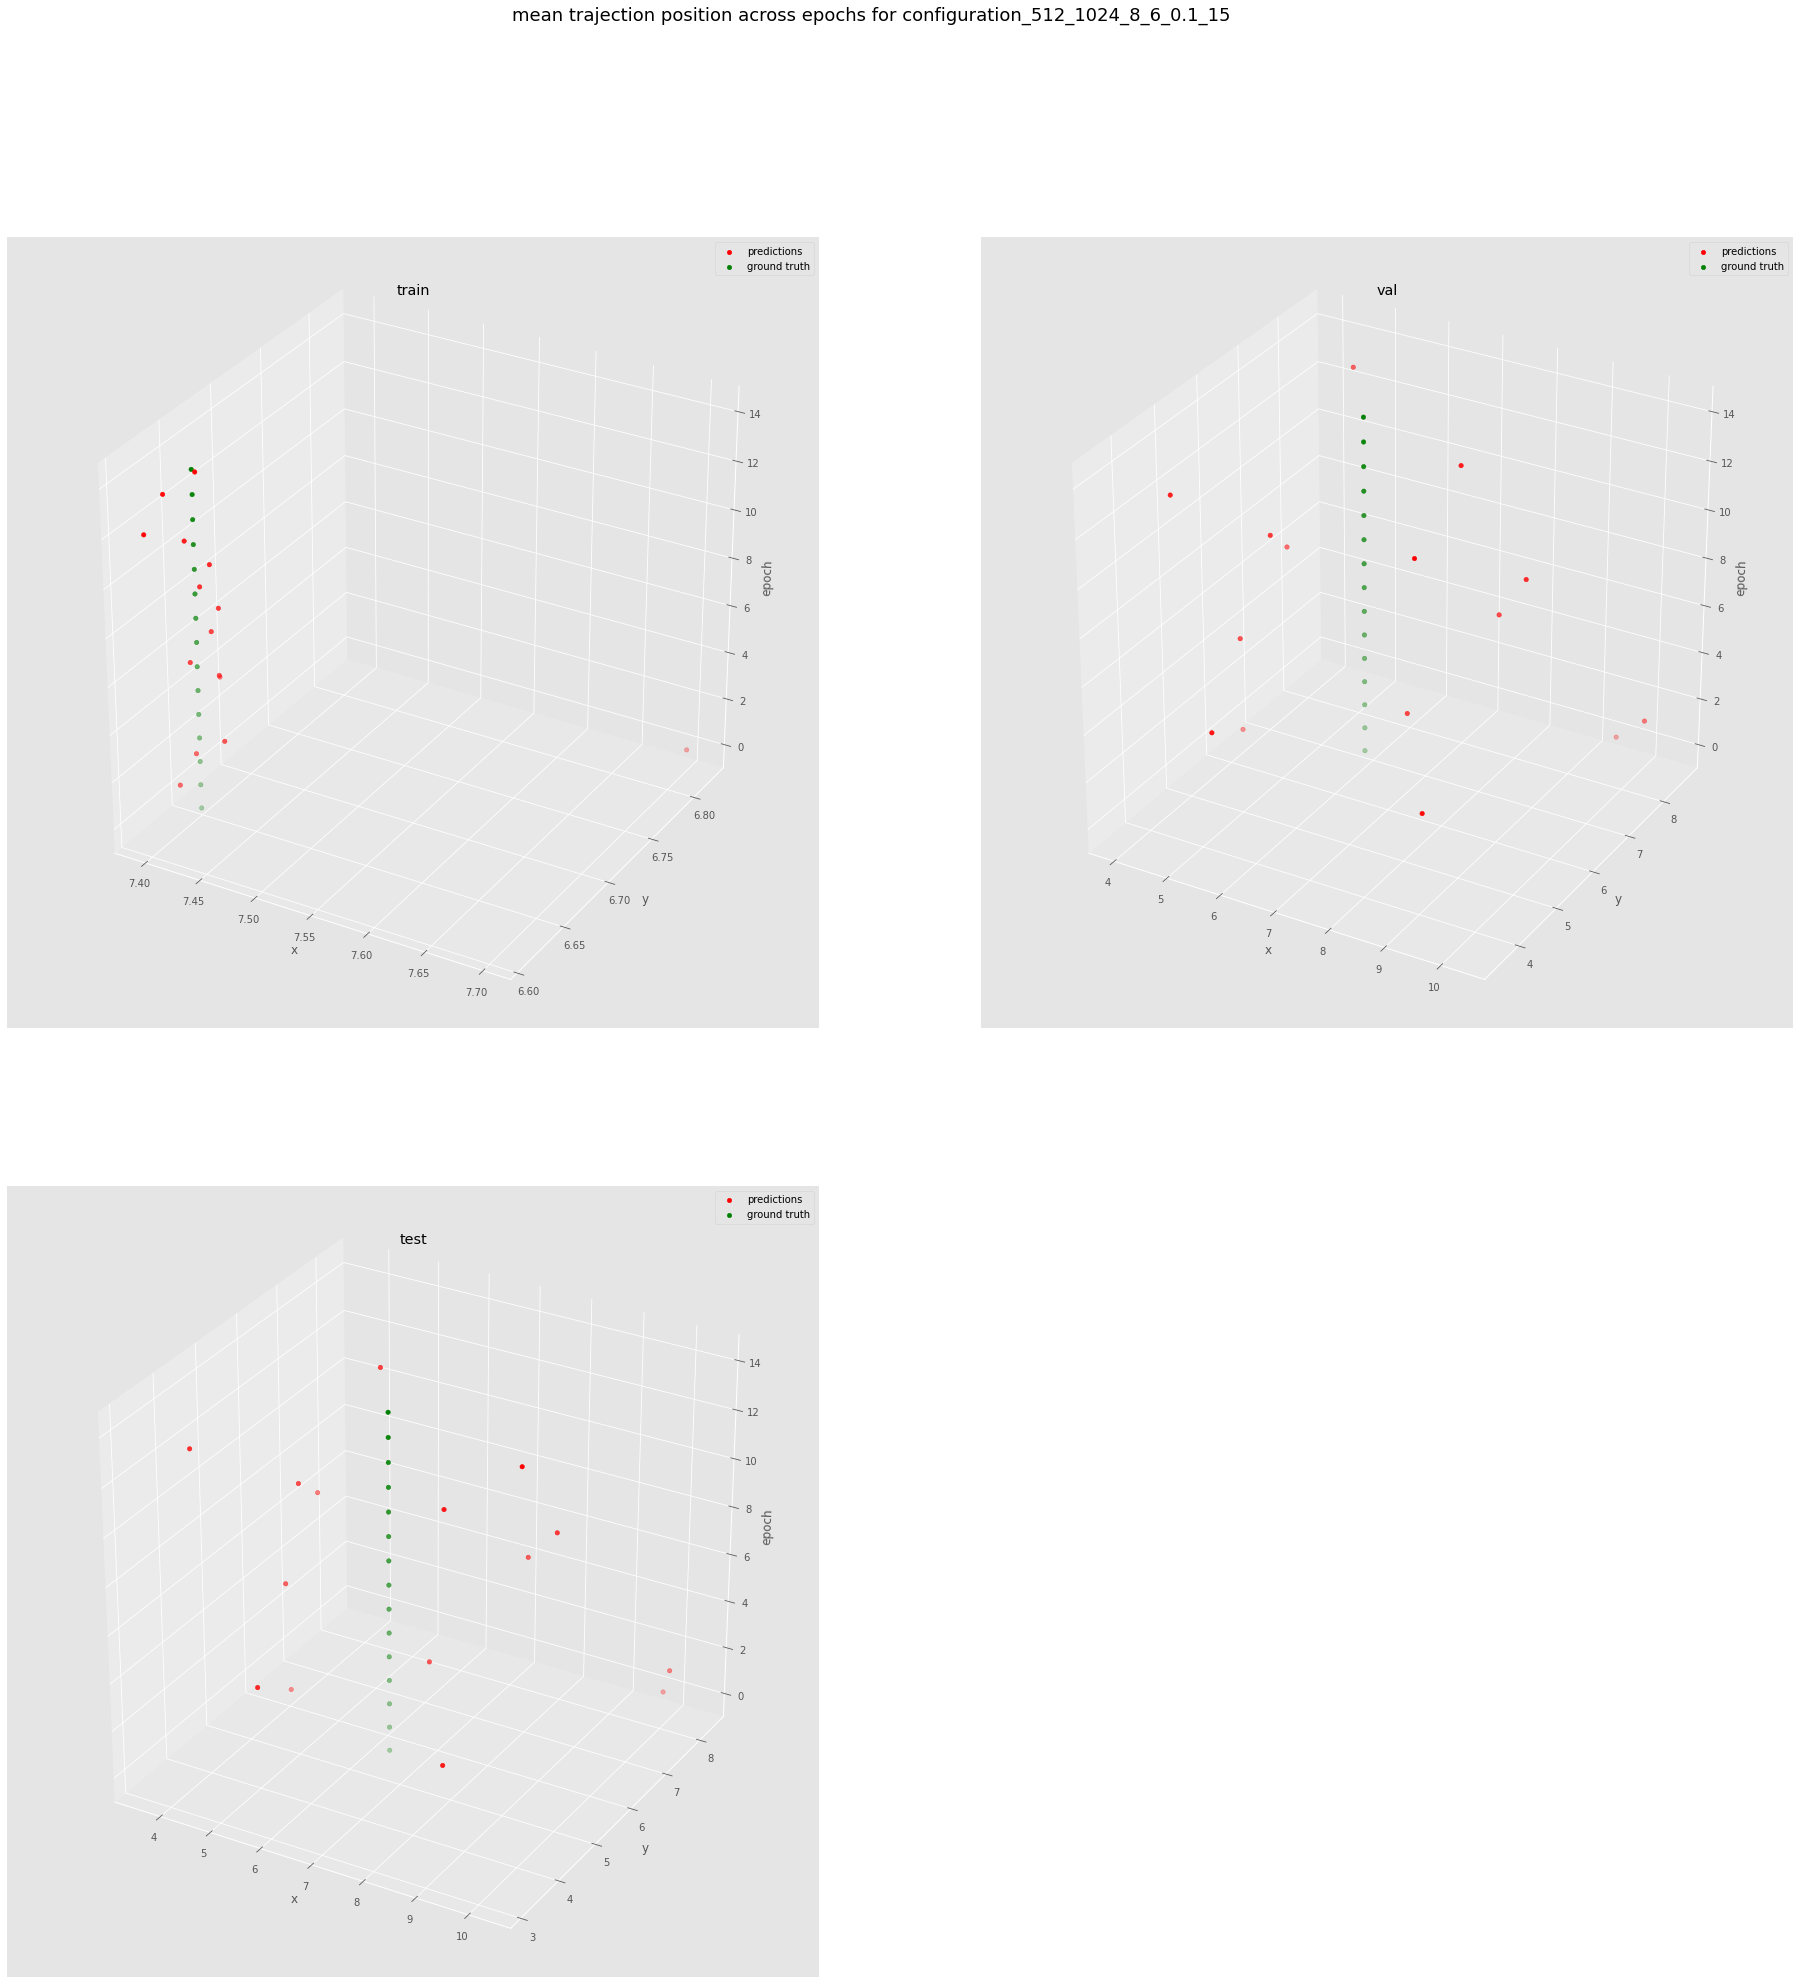

In [ ]:
pred_obj = [ visualization[step]['pr_posit'] for step in steps ]
gt_obj = [ visualization[step]['gt_posit'] for step in steps ]
plot_trajection(pred_obj,gt_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

Here your report

In the following table we show the comparison between the speed setting and the position setting

| type     | train loss | train MAD | train FAD | val loss | val MAD | val FAD |
|----------|------------|-----------|-----------|----------|---------|---------|
| speed    | 114,1907   | 0,1366    | 0,1979    | 319,2128 | 0,5826  | 1,3283  |
| position | 60,6431    | 0,3441    | 0,3081    | 258,7693 | 1,8700  | 3,4677  |

it is observable that the speed setting obtains the best performance on both MAD and FAD.

In the following graphs we show the mean trajections for speed (u,v) and position(x,y) computed across all dimensions for each epoch.

**speed**

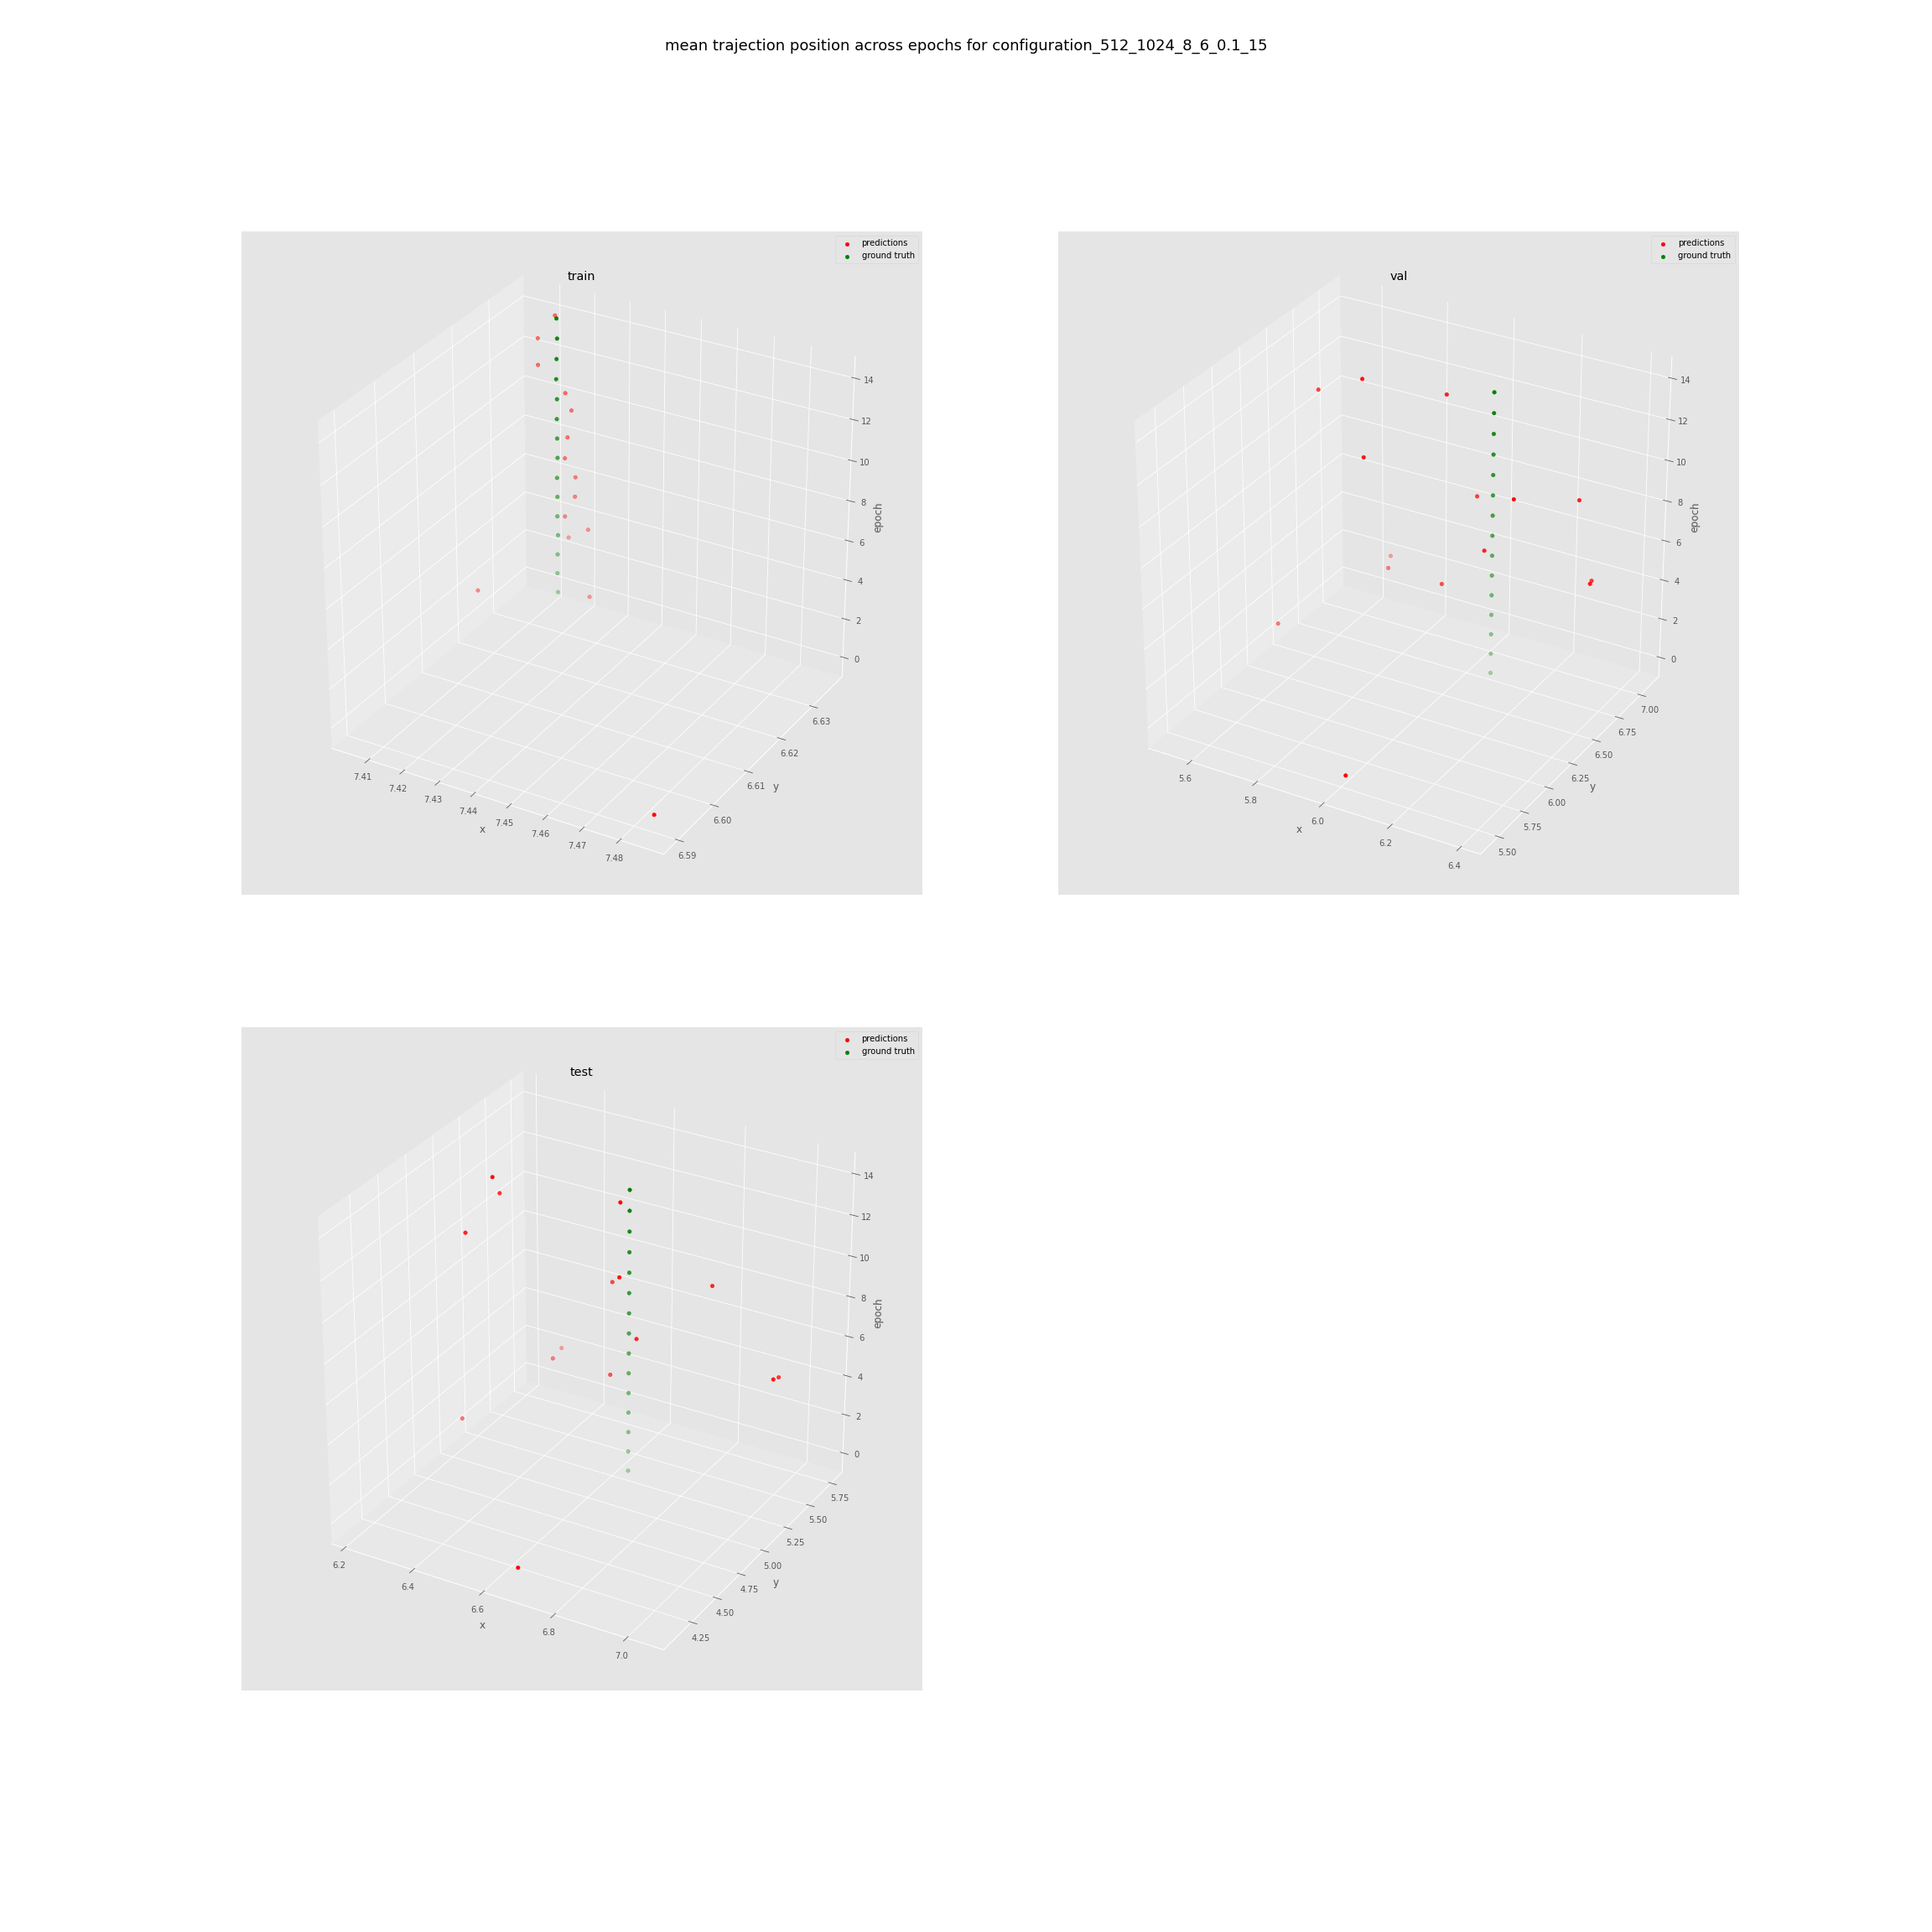

In [ ]:
from PIL import Image

path_speed='/content/drive/MyDrive/TF4AML/plots/plots_speed_bonus/trajection_configuration_512_1024_8_6_0.1_15.png'

img=Image.open(path_speed)

img

**position**

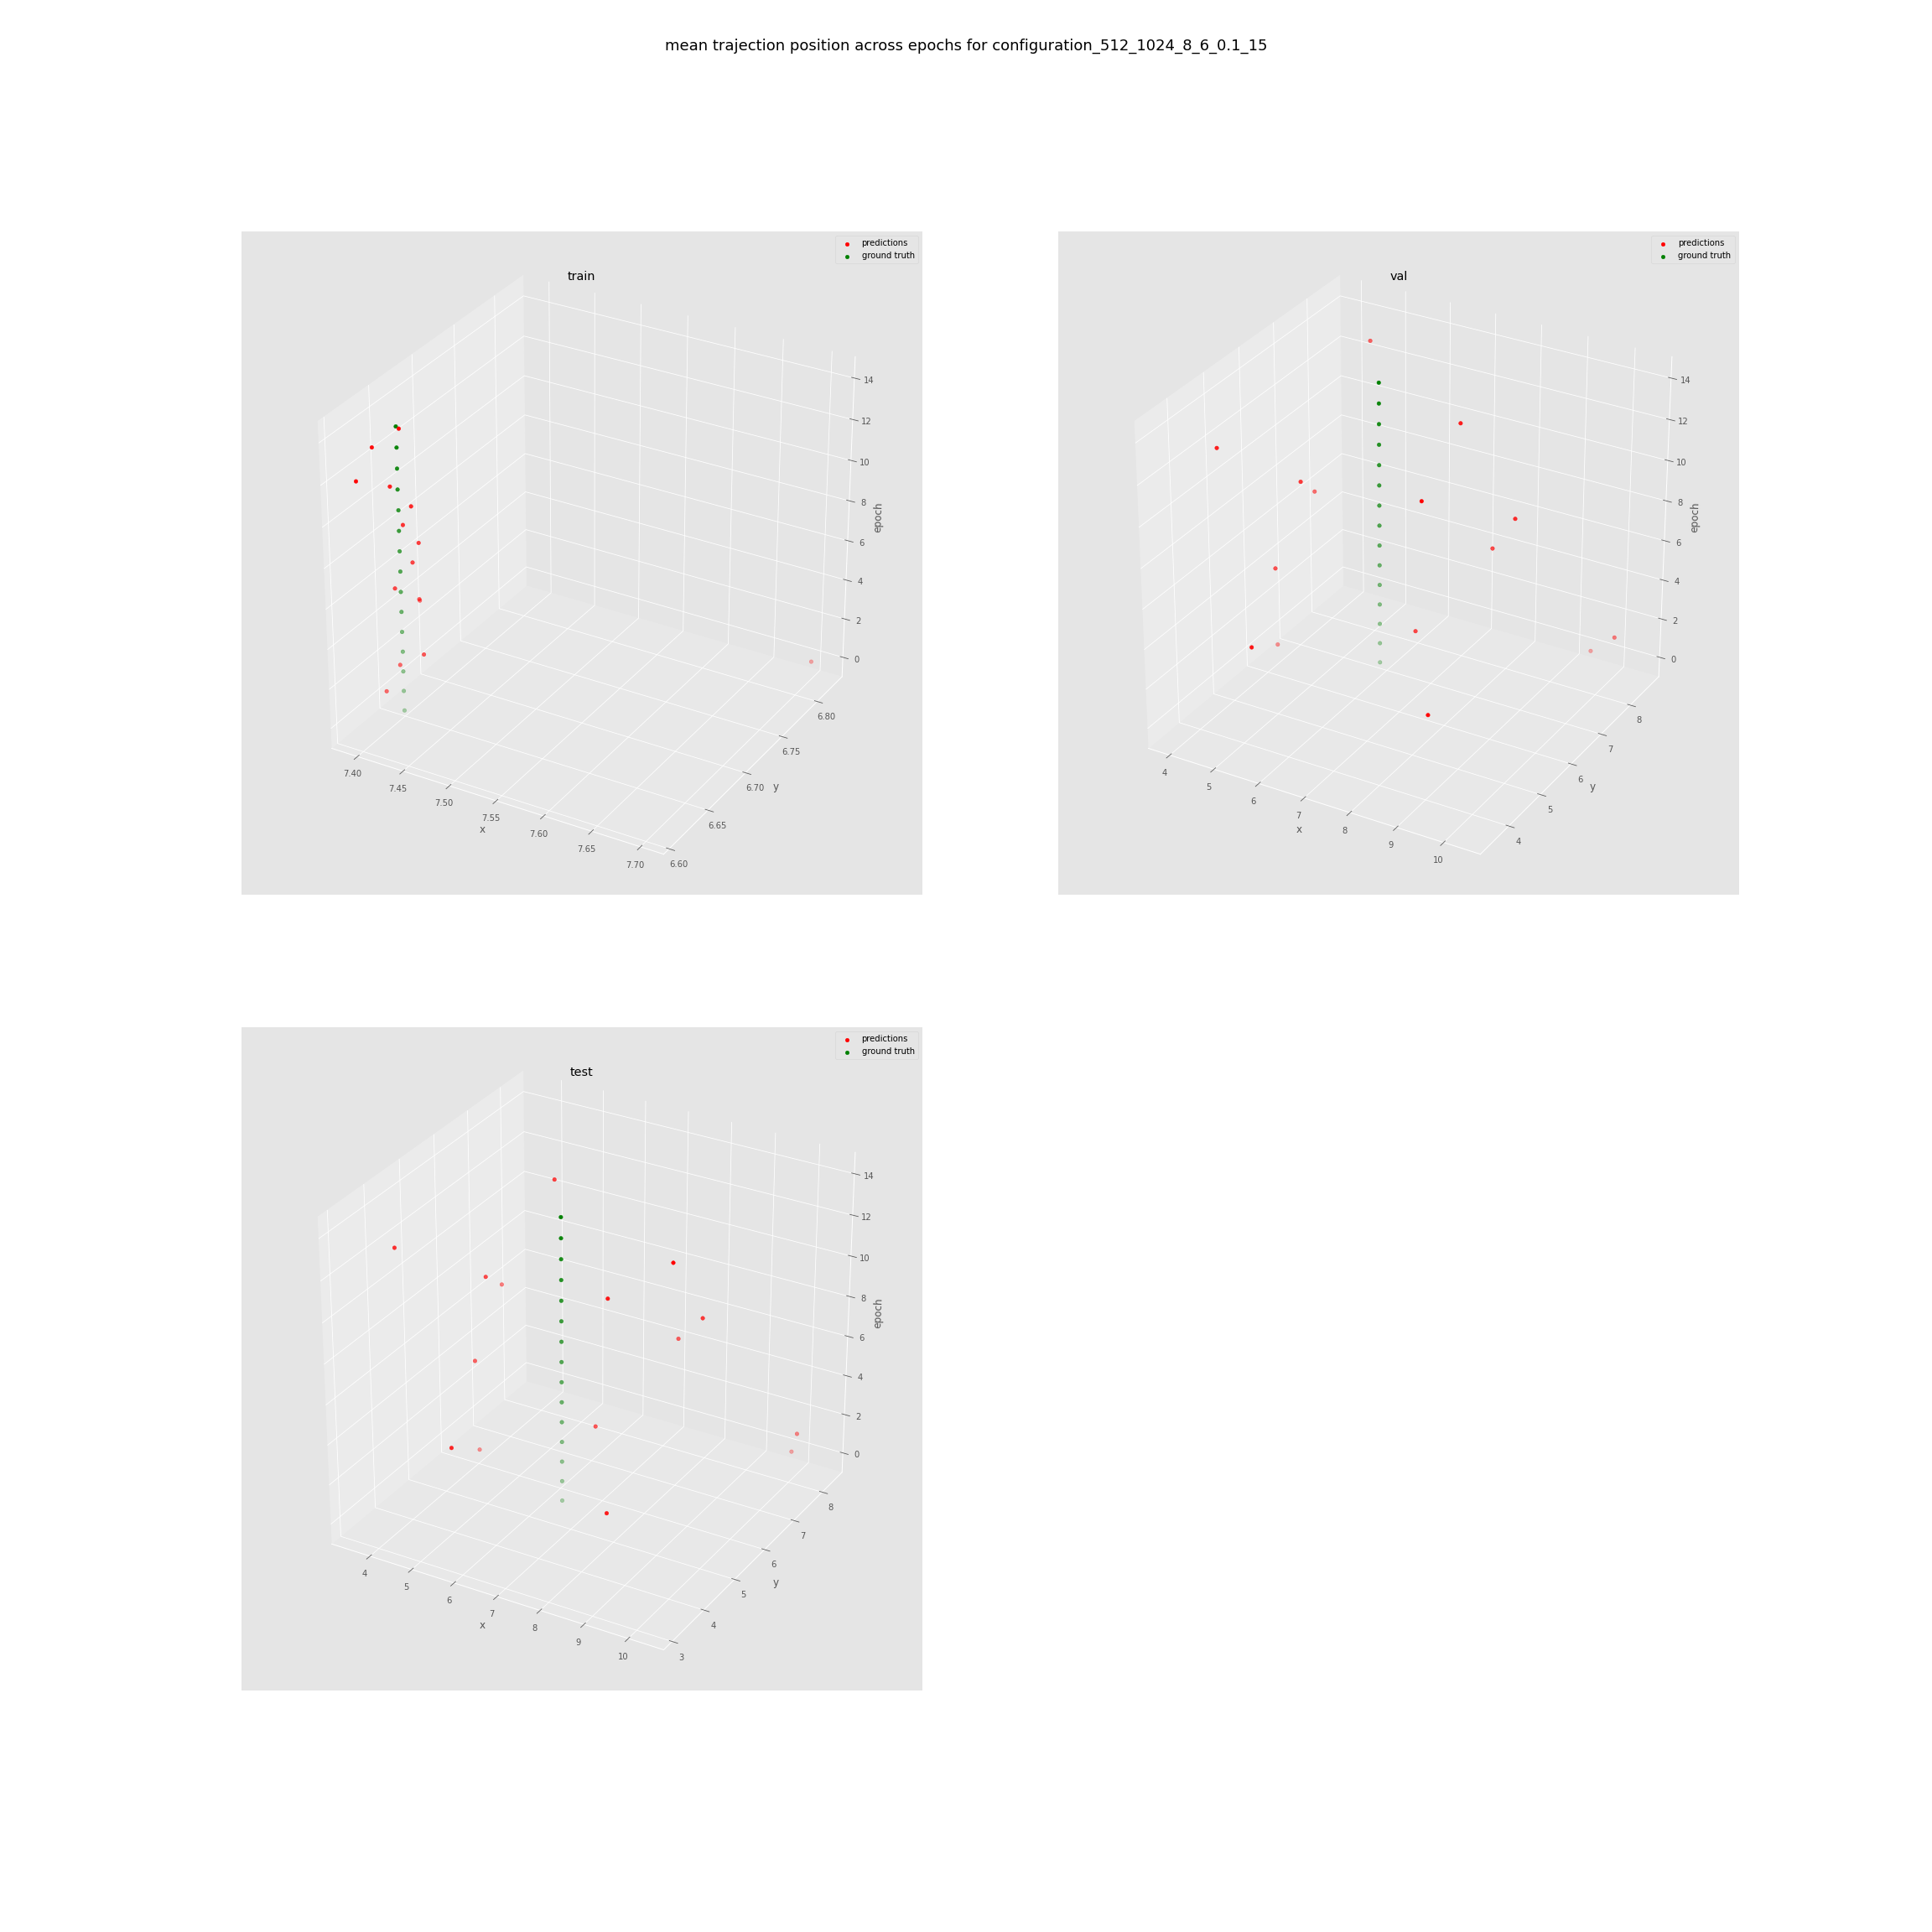

In [ ]:
path_position='/content/drive/MyDrive/TF4AML/plots/plots_position_bonus/trajection_configuration_512_1024_8_6_0.1_15.png'

img=Image.open(path_position)

img

it is observable from the mean trajection plots, especially in validation and test, that in the speed setting the mean prediction tends to be closer to the Ground Truth along the epochs.

## 5. Positional Encoding  (***3 POINTS*** - Bonus)

A number of positional encodings have been proposed. 

Implement the plain positional encoding [0,1,2,3,4,...] and report your comments and results.

Change the commented class we prepared in the positional_encoding.py file and copy the class here. 

In [ ]:
# Here is the class


class PositionalEncoding(nn.Module):
    """
    You can use this class to create another positional encoding to your input.
    Remember to comment previous class.
    """

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Your code here
		self.dropout = nn.Dropout(p=dropout)

		pe = torch.zeros(max_len, d_model)
		position = torch.arange(0, max_len).unsqueeze(1).float()
		pe[:,:] = position
		pe = pe.unsqueeze(0)
		self.register_buffer('pe', pe)


    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


In [ ]:
# Instanciate a new model and loading its parameters

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512 #emb_size = 512
ff_size = 1024 #ff_size = 2048
heads = 8
layers = 8
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Loading arguments
epoch = 15
dataset_name = 'zara1'

path = f'save_folder/pos_enc/{dataset_name}/00015.pth' # defaualt was save_folder/regr/
checkpoint = torch.load(path) #, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
visualization = checkpoint['visualization_dict']

steps = ['train', 'val', 'test']
metrics = ['loss', 'mad', 'fad', 'pr_posit', 'gt_posit']

# Setup correctly optimizer and its LR as well
factor = 1.
warmup = 1

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optim._step = epoch-1

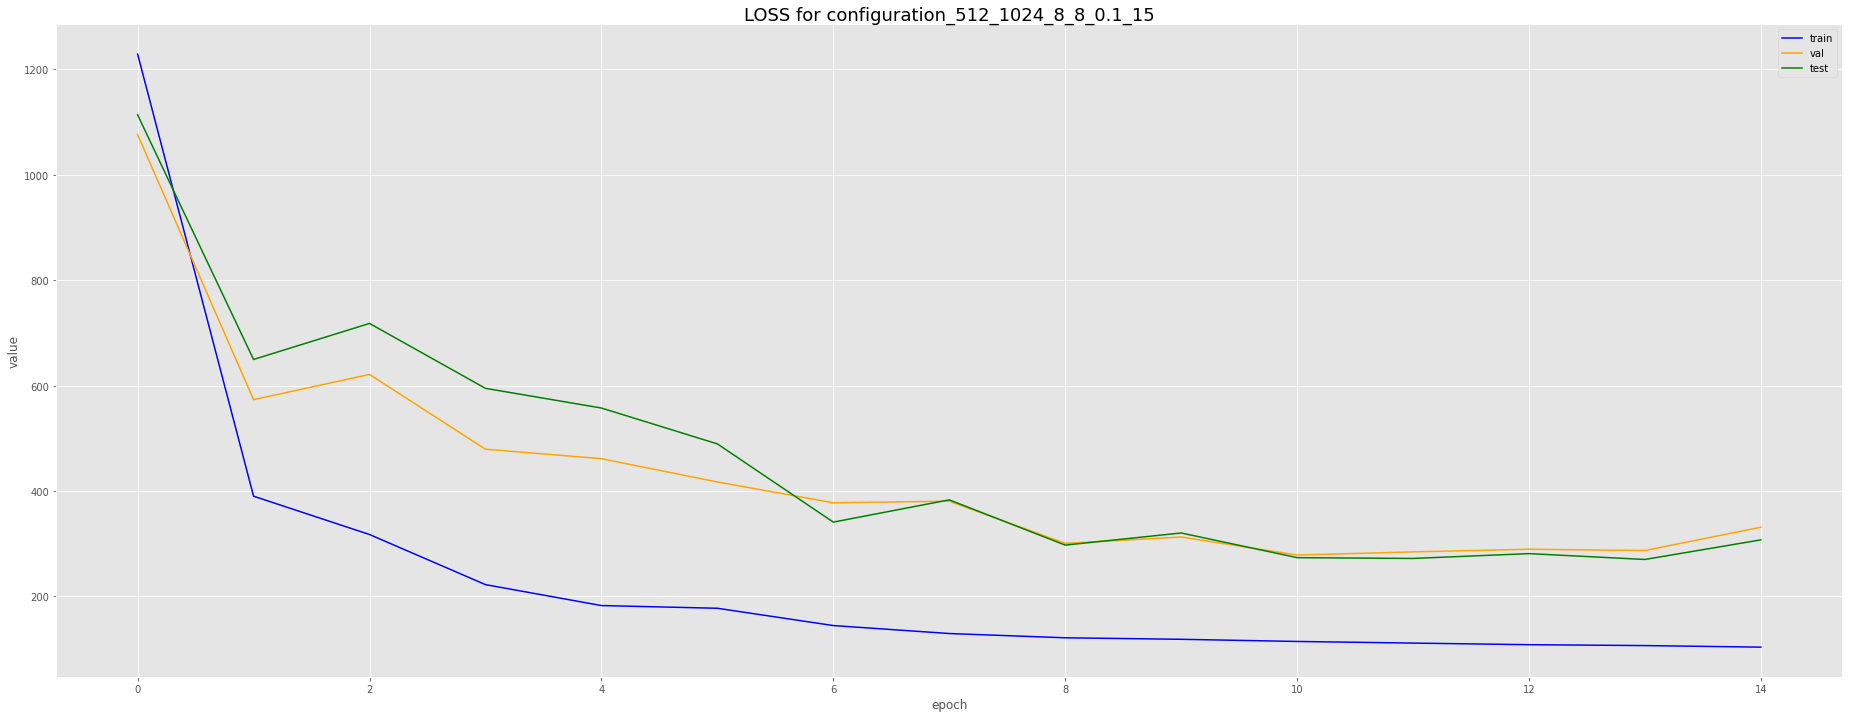

In [ ]:
loss_obj = [ visualization[step]['loss'] for step in steps ]
plot_metrics(loss_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

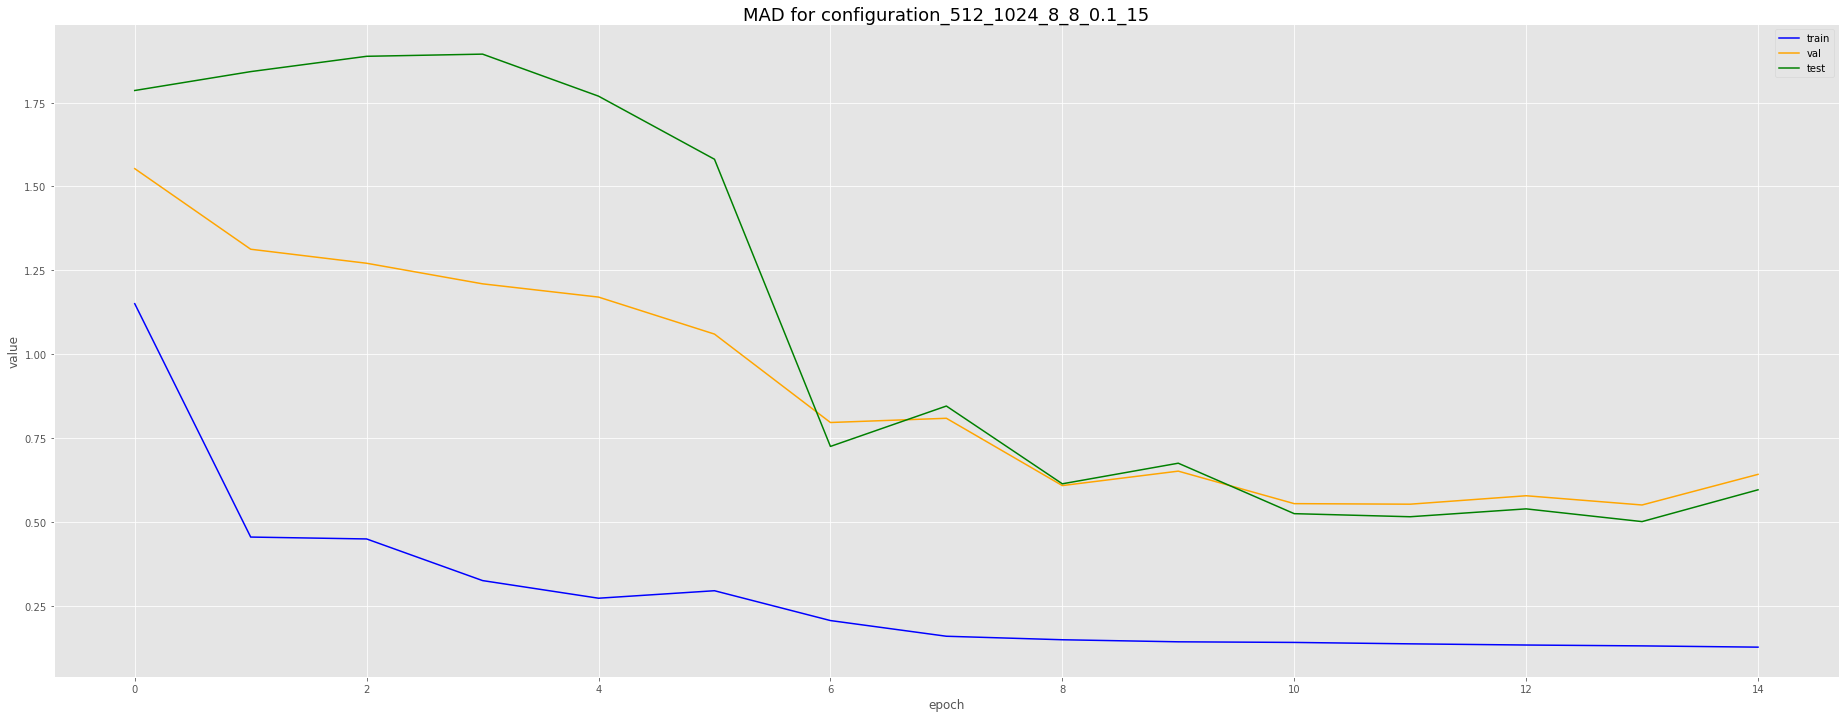

In [ ]:
mad_obj = [ visualization[step]['mad'] for step in steps ]
plot_metrics(mad_obj,metric='MAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

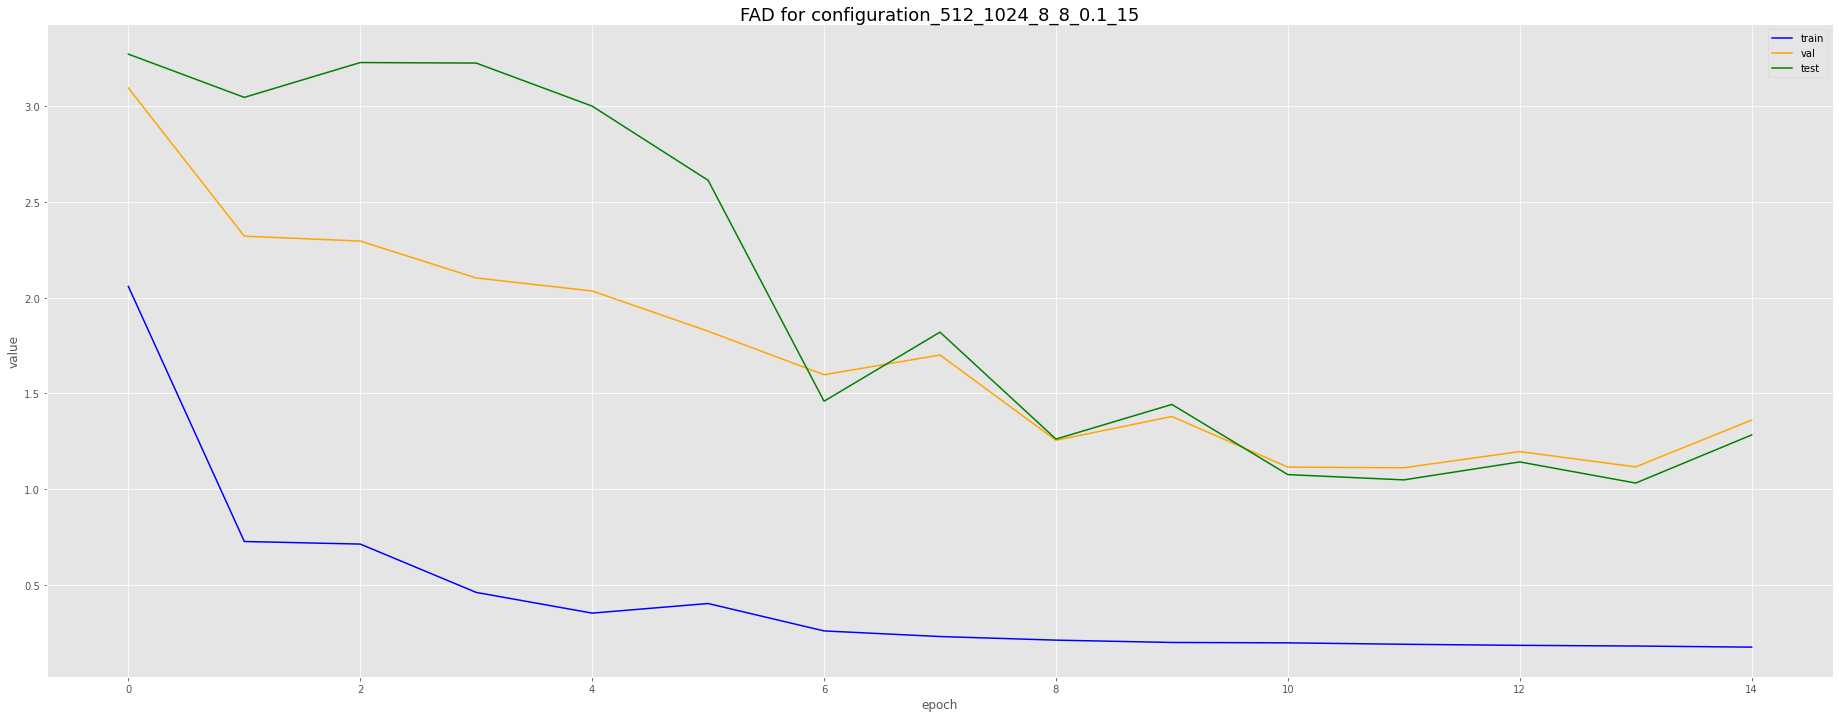

In [ ]:
fad_obj = [ visualization[step]['fad'] for step in steps ]
plot_metrics(fad_obj,metric='FAD',sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

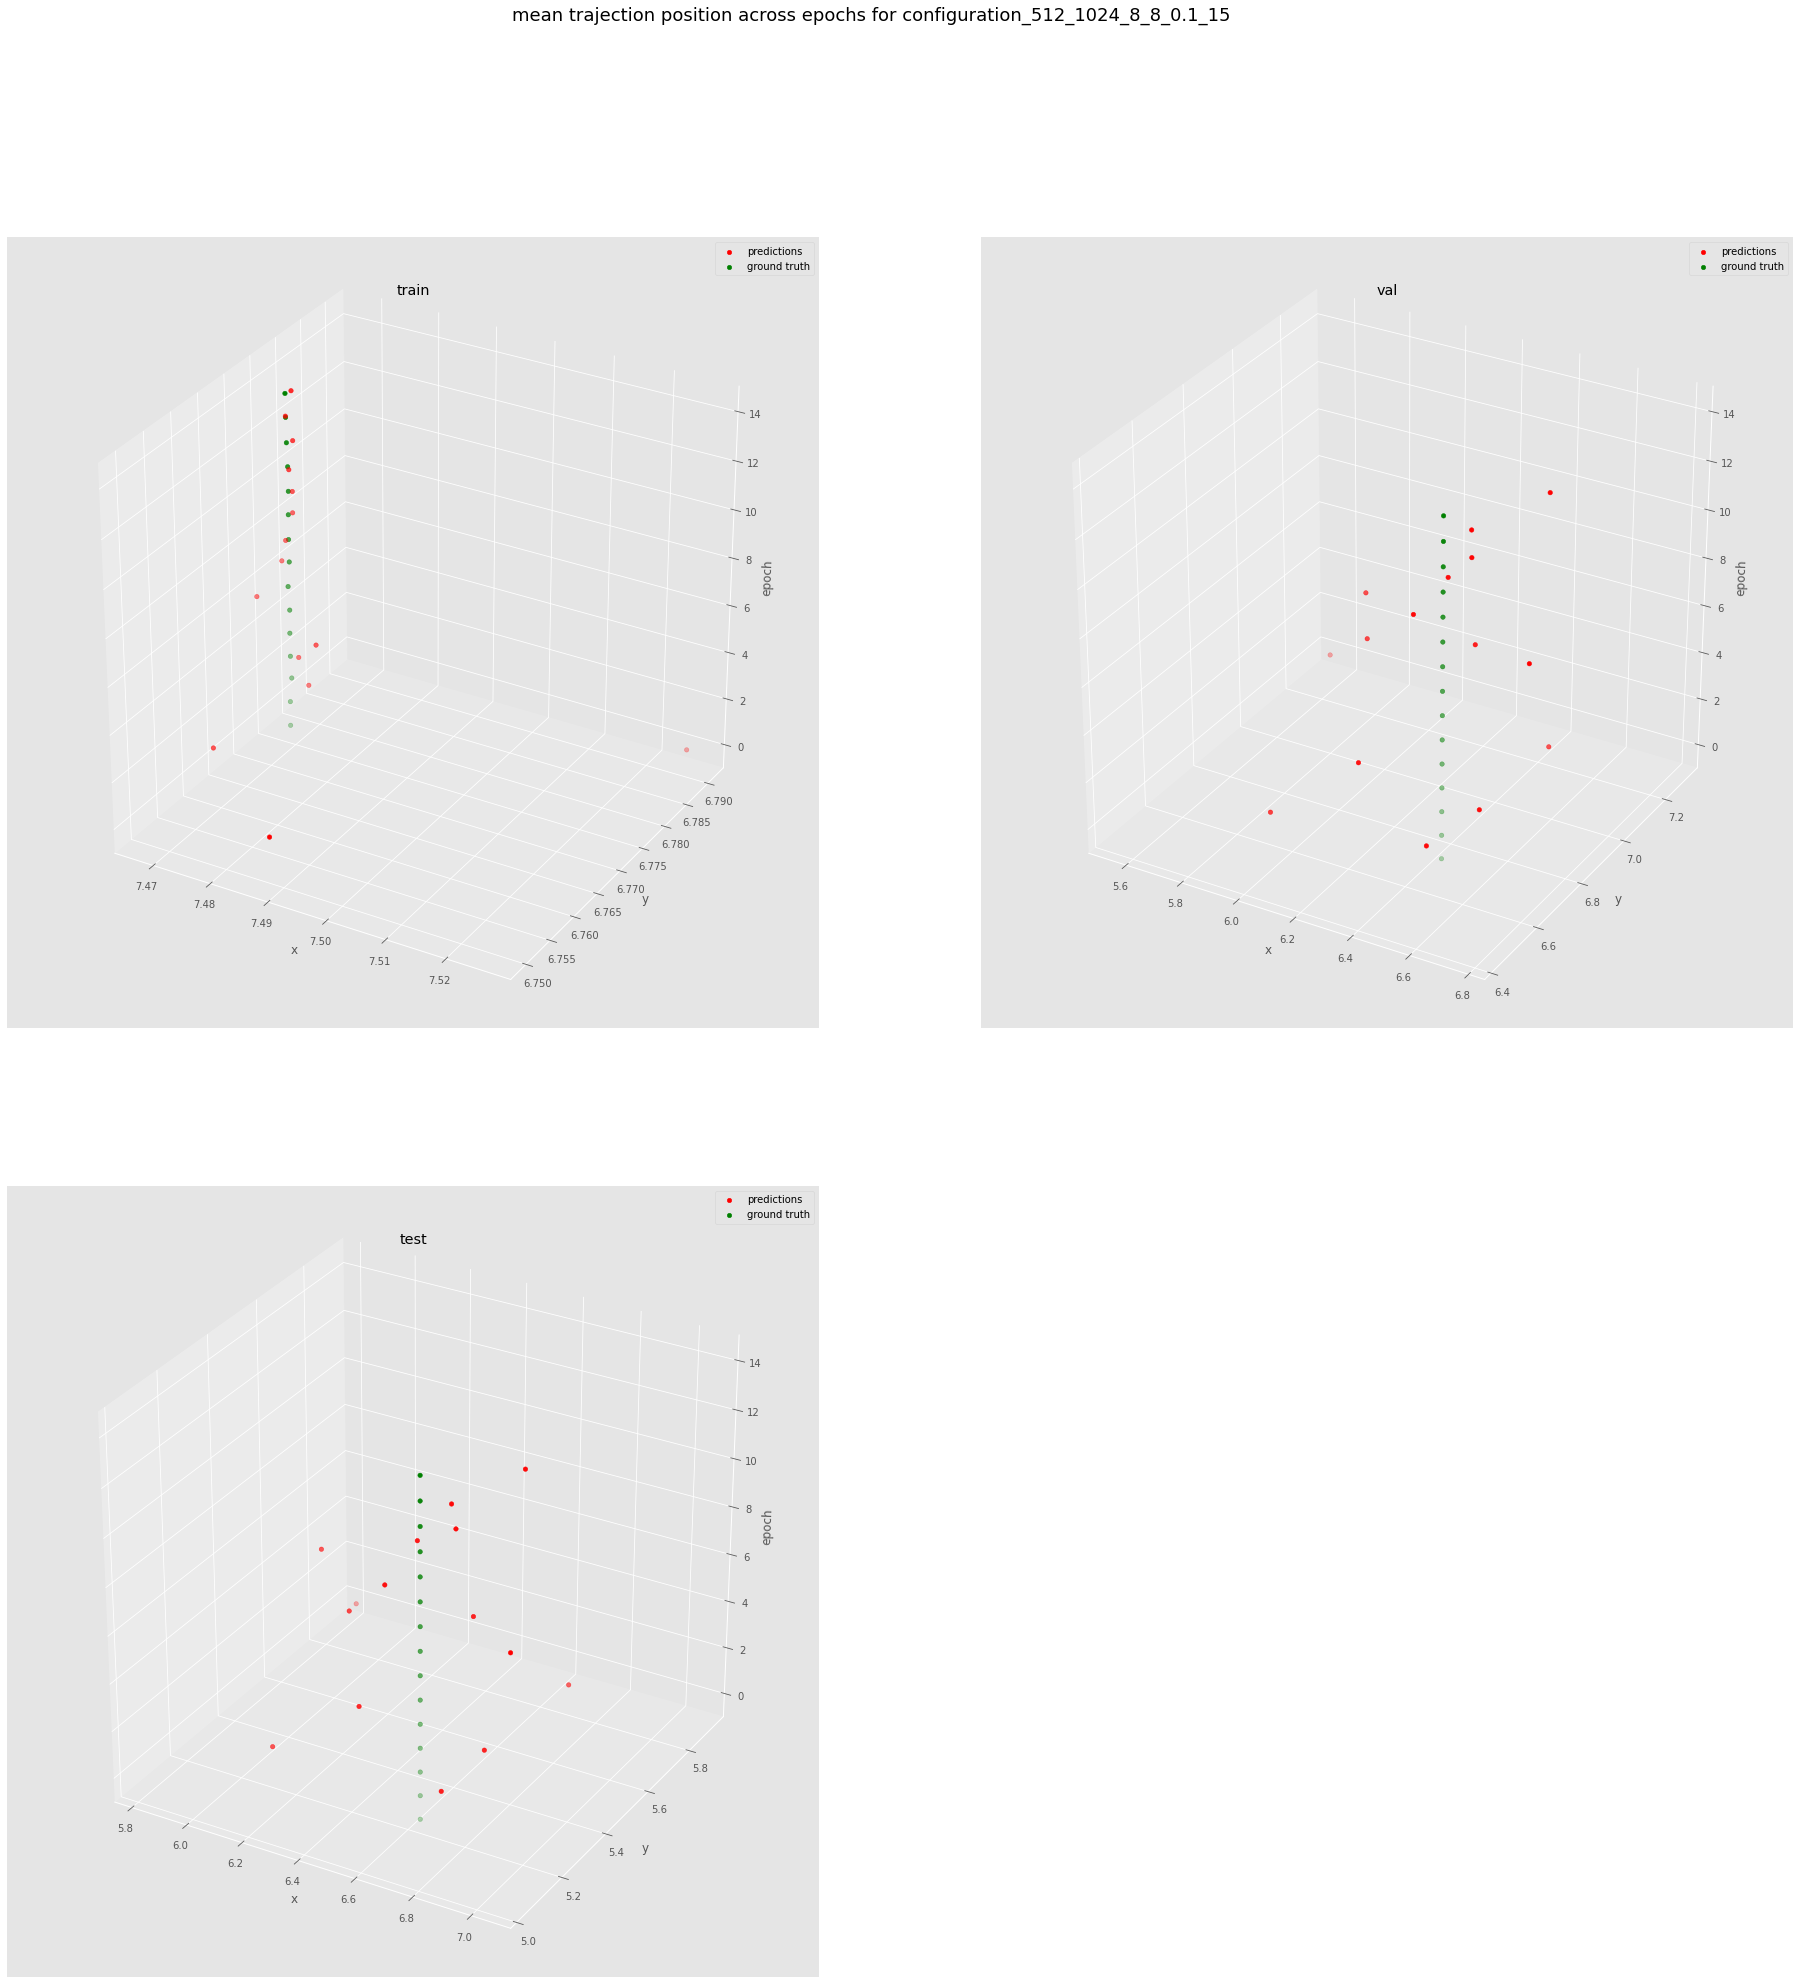

In [ ]:
pred_obj = [ visualization[step]['pr_posit'] for step in steps ]
gt_obj = [ visualization[step]['gt_posit'] for step in steps ]
plot_trajection(pred_obj,gt_obj,sub_path=f'configuration_{emb_size}_{ff_size}_{heads}_{layers}_{dropout}_{max_epoch}')

From the plots above we can see that the model with the plain encoding started overfitting in the last epoch, and from the same plots we surmise that the best results were achieved in epoch 14:

In [ ]:
for step in visualization:
  print("%s loss %f" % (step, visualization[step]['loss'][13]))
  print("%s MAD %f" % (step, visualization[step]['mad'][13]))
  print("%s FAD %f" % (step, visualization[step]['fad'][13]))

train loss 106.589964
train MAD 0.131497
train FAD 0.183724
val loss 287.000577
val MAD 0.551187
val FAD 1.117378
test loss 270.020504
test MAD 0.501691
test FAD 1.033236


Here your report

This is the table comparing loss, mad and, fad of the given model with tuned parameters and the same model with plain positional encoding.

| type     | train loss | train MAD | train FAD | val loss | val MAD | val FAD |
|----------|------------|-----------|-----------|----------|---------|---------|
| vaswani    | 114,1907   | 0,1366    | 0,1979    | 319,2128 | 0,5826  | 1,3283  |
| plain | 106,5899    | 0,1314  | 0,1837    | 287,0005 | 0,5511  | 1,1173  |

With the our hyper-parameters it looks like the plain encoding works slightly better, but by such an amount that we could say that the two models are comparable in performance.



---

This notebook was created by Luca Franco and Alessandro Flaborea.